In [ ]:
%%capture
%run '/content/drive/MyDrive/Federated_Learning/MNIST/NonIID/PathologicalPartition/Decentralized/MNIST_Pathological_Requirement.ipynb'

In [ ]:
def train(net,trainloader,epochs:int,global_params=None,mu:float=0.0,verbose=False): # adding proximal term coefficient (mu)
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters())
    net.train()

    for epoch in range(epochs):
        correct,total,epoch_loss=0,0,0.0
        for batch in trainloader:
            images, labels = batch["image"].to(DEVICE), batch["label"].to(DEVICE)
            optimizer.zero_grad()
            outputs=net(images)
            ce_loss=criterion(outputs,labels)
            # If global model parameters are given and mu is non-zero, apply FedProx algorithm
            if global_params is not None and mu>0:
                prox_term=0.0
                for param,global_param in zip(net.parameters(),global_params):
                    prox_term+=((param-global_param.to(DEVICE))**2).sum()
                ce_loss+=(mu/2)*prox_term # Adding the proximal penalty to the cross-entropy loss

            ce_loss.backward()
            optimizer.step()
            epoch_loss+=ce_loss.item()
            total+=labels.size(0)
            correct+=(outputs.argmax(dim=1)==labels).sum().item()

        if verbose:
            print(f"Epoch {epoch+1}: Train Loss = {epoch_loss:.4f}, Accuracy = {correct / total:.4f}")

In [ ]:
def test(net, testloader):
    """Evaluate the network on the entire test set."""
    criterion = torch.nn.CrossEntropyLoss()
    correct, total, loss = 0, 0, 0.0
    net.eval()
    with torch.no_grad():
        for batch in testloader:
            images, labels = batch["image"].to(DEVICE), batch["label"].to(DEVICE)
            outputs = net(images)
            loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    loss /= len(testloader.dataset)
    accuracy = correct / total
    return loss, accuracy

In [ ]:
class FlowerClient(NumPyClient):
    def __init__(self, net, trainloader, valloader):
        self.net=net
        self.trainloader=trainloader
        self.valloader=valloader

    def get_parameters(self, config):
        return get_parameters(self.net)

    def fit(self, parameters, config):
        set_parameters(self.net,parameters)
        mu=float(config.get("mu",0.0))
        global_params=[torch.tensor(p,dtype=torch.float32).to(DEVICE) for p in parameters]
        train(self.net,self.trainloader,epochs=1,global_params=global_params,mu=mu)
        return get_parameters(self.net), len(self.trainloader), {}

    def evaluate(self, parameters, config):
        set_parameters(self.net, parameters)
        loss, accuracy = test(self.net, self.valloader)
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}

In [ ]:
def client_fn(context: Context) -> Client:
    """Create a Flower client representing a single organization."""
    net = Net().to(DEVICE)
    print(f"Context data: {context.__dict__}")

    partition_id = int(context.node_id) % NUM_CLIENTS if hasattr(context, 'node_id') else 0
    if hasattr(context, 'node_config') and 'partition_id' in context.node_config:
        partition_id = context.node_config['partition_id']

    print(f"Using partition_id: {partition_id}")
    trainloader, valloader, _ = load_datasets(partition_id=partition_id)
    return FlowerClient(net, trainloader, valloader).to_client()

client = ClientApp(client_fn=client_fn)

In [ ]:
def weighted_average(metrics: List[Tuple[int, Metrics]]) -> Metrics:
    accuracies = [num_examples * m["accuracy"] for num_examples, m in metrics]
    examples = [num_examples for num_examples, _ in metrics]

    return {"accuracy": sum(accuracies) / sum(examples)}

In [ ]:
from flwr.server.strategy.fedavg import FedAvg
test_accuracies = []

class CustomFedAvg(FedAvg):
    def aggregate_evaluate(self, server_round, results, failures):
        aggregated_result=super().aggregate_evaluate(server_round,results,failures)

        if aggregated_result is not None:
            loss,metrics=aggregated_result
            accuracy=metrics.get("accuracy",0.0)
            test_accuracies.append(accuracy)
            print(f"Round {server_round}: Test Accuracy: {accuracy:.4f}")
        return aggregated_result

In [ ]:
def fit_config_fn(server_round: int):
    """Return training configuration dict for each round."""
    config={
        "current_round":server_round,
        "mu":0.01,
    }
    return config

strategy = CustomFedAvg(
    fraction_fit=1.0,
    fraction_evaluate=0.5,
    min_fit_clients=10,
    min_evaluate_clients=5,
    min_available_clients=10,
    evaluate_metrics_aggregation_fn=weighted_average,
    on_fit_config_fn=fit_config_fn,
)

In [ ]:
def server_fn(context: Context) -> ServerAppComponents:
    config = ServerConfig(num_rounds=50)
    return ServerAppComponents(strategy=strategy, config=config)

server = ServerApp(server_fn=server_fn)

In [ ]:
backend_config = {"client_resources": {"num_cpus": 1, "num_gpus": 0.0}}

if DEVICE == "cuda":
    backend_config = {"client_resources": {"num_cpus": 1, "num_gpus": 1.0}}

In [ ]:
run_simulation(
    server_app=server,
    client_app=client,
    num_supernodes=NUM_CLIENTS,
    backend_config=backend_config,
)

DEBUG:flwr:Asyncio event loop already running.
INFO :      Starting Flower ServerApp, config: num_rounds=50, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Requesting initial parameters from one random client
(pid=2569) 2025-04-28 18:53:41.202797: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=2569) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(pid=2569) E0000 00:00:1745866421.284473    2569 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=2569) E0000 00:00:1745866421.313521    2569 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(ClientAppActor pid=2569) /usr/local/lib/python3.11/dist-packages/jupyter_client/co

(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 12897425978334679047, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2569)   array_records={},
(ClientAppActor pid=2569)   metric_records={},
(ClientAppActor pid=2569)   config_records={}
(ClientAppActor pid=2569) ), 'run_config': {}}
(ClientAppActor pid=2569) Using partition_id: 7


Generating test split: 100%|██████████| 10000/10000 [00:00<00:00, 163378.58 examples/s]
(ClientAppActor pid=2569) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2569)   warnings.warn(
INFO :      Received initial parameters from one random client
INFO :      Starting evaluation of initial global parameters
INFO :      Evaluation returned no results (`None`)
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=2569) Partition 7 size: 9807
(ClientAppActor pid=2569) Partition 7 train size: 7845
(ClientAppActor pid=2569) Partition 7 test size: 1962
(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 6278138750764662690, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2569)   array_records={},
(ClientAppActor pid=2569)   metric_records={},
(ClientAppActor pid=2569)   config_records={}
(ClientAppActor pid=2569) ), 'run_config': {}}
(ClientAppActor pid=2569) Using partition_id: 0


(ClientAppActor pid=2569) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2569)   warnings.warn(


(ClientAppActor pid=2569) Partition 0 size: 3020
(ClientAppActor pid=2569) Partition 0 train size: 2416
(ClientAppActor pid=2569) Partition 0 test size: 604


(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/jupyter_client/connect.py:28: DeprecationWarning: Jupyter is migrating its paths to use standard platformdirs
(ClientAppActor pid=2568) given by the platformdirs library.  To remove this warning and
(ClientAppActor pid=2568) see the appropriate new directories, set the environment variable
(ClientAppActor pid=2568) `JUPYTER_PLATFORM_DIRS=1` and then run `jupyter --paths`.
(ClientAppActor pid=2568) The use of platformdirs will be the default in `jupyter_core` v6
(ClientAppActor pid=2568)   from jupyter_core.paths import jupyter_data_dir, jupyter_runtime_dir, secure_write


(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 14439386944870861194, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2568)   array_records={},
(ClientAppActor pid=2568)   metric_records={},
(ClientAppActor pid=2568)   config_records={}
(ClientAppActor pid=2568) ), 'run_config': {}}
(ClientAppActor pid=2568) Using partition_id: 4


(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2568)   warnings.warn(


(ClientAppActor pid=2568) Partition 4 size: 3017
(ClientAppActor pid=2568) Partition 4 train size: 2413
(ClientAppActor pid=2568) Partition 4 test size: 604
(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 4006453300315560794, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2569)   array_records={},
(ClientAppActor pid=2569)   metric_records={},
(ClientAppActor pid=2569)   config_records={}
(ClientAppActor pid=2569) ), 'run_config': {}}
(ClientAppActor pid=2569) Using partition_id: 4


(ClientAppActor pid=2569) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2569)   warnings.warn(


(ClientAppActor pid=2569) Partition 4 size: 3017
(ClientAppActor pid=2569) Partition 4 train size: 2413
(ClientAppActor pid=2569) Partition 4 test size: 604
(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 11801514179762901352, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2568)   array_records={},
(ClientAppActor pid=2568)   metric_records={},
(ClientAppActor pid=2568)   config_records={}
(ClientAppActor pid=2568) ), 'run_config': {}}
(ClientAppActor pid=2568) Using partition_id: 2


(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2568)   warnings.warn(


(ClientAppActor pid=2568) Partition 2 size: 3947
(ClientAppActor pid=2568) Partition 2 train size: 3157
(ClientAppActor pid=2568) Partition 2 test size: 790
(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 8658327154383673855, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2569)   array_records={},
(ClientAppActor pid=2569)   metric_records={},
(ClientAppActor pid=2569)   config_records={}
(ClientAppActor pid=2569) ), 'run_config': {}}
(ClientAppActor pid=2569) Using partition_id: 5


(ClientAppActor pid=2569) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2569)   warnings.warn(


(ClientAppActor pid=2569) Partition 5 size: 2851
(ClientAppActor pid=2569) Partition 5 train size: 2280
(ClientAppActor pid=2569) Partition 5 test size: 571
(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 13740947717246972021, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2568)   array_records={},
(ClientAppActor pid=2568)   metric_records={},
(ClientAppActor pid=2568)   config_records={}
(ClientAppActor pid=2568) ), 'run_config': {}}
(ClientAppActor pid=2568) Using partition_id: 1


(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2568)   warnings.warn(


(ClientAppActor pid=2568) Partition 1 size: 5987
(ClientAppActor pid=2568) Partition 1 train size: 4789
(ClientAppActor pid=2568) Partition 1 test size: 1198
(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 12897425978334679047, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2569)   array_records={},
(ClientAppActor pid=2569)   metric_records={},
(ClientAppActor pid=2569)   config_records={}
(ClientAppActor pid=2569) ), 'run_config': {}}
(ClientAppActor pid=2569) Using partition_id: 7


(ClientAppActor pid=2569) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2569)   warnings.warn(


(ClientAppActor pid=2569) Partition 7 size: 9807
(ClientAppActor pid=2569) Partition 7 train size: 7845
(ClientAppActor pid=2569) Partition 7 test size: 1962
(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 14365117762882375815, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2568)   array_records={},
(ClientAppActor pid=2568)   metric_records={},
(ClientAppActor pid=2568)   config_records={}
(ClientAppActor pid=2568) ), 'run_config': {}}
(ClientAppActor pid=2568) Using partition_id: 5


(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2568)   warnings.warn(


(ClientAppActor pid=2568) Partition 5 size: 2851
(ClientAppActor pid=2568) Partition 5 train size: 2280
(ClientAppActor pid=2568) Partition 5 test size: 571
(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 6571022725872414138, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2568)   array_records={},
(ClientAppActor pid=2568)   metric_records={},
(ClientAppActor pid=2568)   config_records={}
(ClientAppActor pid=2568) ), 'run_config': {}}
(ClientAppActor pid=2568) Using partition_id: 8


(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2568)   warnings.warn(


(ClientAppActor pid=2568) Partition 8 size: 3016
(ClientAppActor pid=2568) Partition 8 train size: 2412
(ClientAppActor pid=2568) Partition 8 test size: 604
(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 7180314308152736858, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2569)   array_records={},
(ClientAppActor pid=2569)   metric_records={},
(ClientAppActor pid=2569)   config_records={}
(ClientAppActor pid=2569) ), 'run_config': {}}
(ClientAppActor pid=2569) Using partition_id: 8


(ClientAppActor pid=2569) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2569)   warnings.warn(


(ClientAppActor pid=2569) Partition 8 size: 3016
(ClientAppActor pid=2569) Partition 8 train size: 2412
(ClientAppActor pid=2569) Partition 8 test size: 604


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 12897425978334679047, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2568)   array_records={},
(ClientAppActor pid=2568)   metric_records={},
(ClientAppActor pid=2568)   config_records={}
(ClientAppActor pid=2568) ), 'run_config': {}}
(ClientAppActor pid=2568) Using partition_id: 7
(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 14365117762882375815, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2569)   array_records={},
(ClientAppActor pid=2569)   metric_records={},
(ClientAppActor pid=2569)   config_records={}
(ClientAppActor pid=2569) ), 'run_config': {}}
(ClientAppActor pid=2569) Using partition_id: 5


(ClientAppActor pid=2569) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2569)   warnings.warn(


(ClientAppActor pid=2569) Partition 5 size: 2851
(ClientAppActor pid=2569) Partition 5 train size: 2280
(ClientAppActor pid=2569) Partition 5 test size: 571


(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2568)   warnings.warn(


(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 14439386944870861194, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2569)   array_records={},
(ClientAppActor pid=2569)   metric_records={},
(ClientAppActor pid=2569)   config_records={}
(ClientAppActor pid=2569) ), 'run_config': {}}
(ClientAppActor pid=2569) Using partition_id: 4
(ClientAppActor pid=2569) Partition 4 size: 3017 [repeated 2x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/user-guides/configure-logging.html#log-deduplication for more options.)
(ClientAppActor pid=2569) Partition 4 train size: 2413 [repeated 2x across cluster]
(ClientAppActor pid=2569) Partition 4 test size: 604 [repeated 2x across cluster]
(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 11801514179762901352, 'node_config': {'p

(ClientAppActor pid=2569) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2569)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2568) Partition 1 size: 5987 [repeated 2x across cluster]
(ClientAppActor pid=2569) Partition 2 train size: 3157
(ClientAppActor pid=2569) Partition 2 test size: 790
(ClientAppActor pid=2568) Partition 1 train size: 4789
(ClientAppActor pid=2568) Partition 1 test size: 1198


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 1: Test Accuracy: 0.2289
(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 14365117762882375815, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2568)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2568)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2568)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2568) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2568) Using partition_id: 5 [repeated 2x across cluster]


(ClientAppActor pid=2569) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2569)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2568) Partition 5 train size: 2280
(ClientAppActor pid=2568) Partition 5 test size: 571
(ClientAppActor pid=2568) Partition 5 size: 2851
(ClientAppActor pid=2569) Partition 7 size: 9807
(ClientAppActor pid=2569) Partition 7 train size: 7845
(ClientAppActor pid=2569) Partition 7 test size: 1962
(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 14439386944870861194, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2568)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2568)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2568)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2568) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2568) Using partition_id: 4 [repeated 2x across cluster]


(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2568)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2568) Partition 4 size: 3017
(ClientAppActor pid=2568) Partition 4 train size: 2413
(ClientAppActor pid=2568) Partition 4 test size: 604
(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 4006453300315560794, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2568)   array_records={},
(ClientAppActor pid=2568)   metric_records={},
(ClientAppActor pid=2568)   config_records={}
(ClientAppActor pid=2568) ), 'run_config': {}}
(ClientAppActor pid=2568) Using partition_id: 4


(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2568)   warnings.warn(


(ClientAppActor pid=2568) Partition 4 size: 3017
(ClientAppActor pid=2568) Partition 4 train size: 2413
(ClientAppActor pid=2568) Partition 4 test size: 604
(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 13740947717246972021, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2568)   array_records={},
(ClientAppActor pid=2568)   metric_records={},
(ClientAppActor pid=2568)   config_records={}
(ClientAppActor pid=2568) ), 'run_config': {}}
(ClientAppActor pid=2568) Using partition_id: 1


(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2568)   warnings.warn(


(ClientAppActor pid=2568) Partition 1 size: 5987
(ClientAppActor pid=2568) Partition 1 train size: 4789
(ClientAppActor pid=2568) Partition 1 test size: 1198
(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 7180314308152736858, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2569)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2569)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2569)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2569) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2569) Using partition_id: 8 [repeated 2x across cluster]
(ClientAppActor pid=2569) Partition 8 size: 3016
(ClientAppActor pid=2569) Partition 8 train size: 2412
(ClientAppActor pid=2569) Partition 8 test size: 604


(ClientAppActor pid=2569) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2569)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2569) Partition 8 size: 3016
(ClientAppActor pid=2569) Partition 8 train size: 2412
(ClientAppActor pid=2569) Partition 8 test size: 604
(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 11801514179762901352, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2568)   array_records={},
(ClientAppActor pid=2568)   metric_records={},
(ClientAppActor pid=2568)   config_records={}
(ClientAppActor pid=2568) ), 'run_config': {}}
(ClientAppActor pid=2568) Using partition_id: 2


(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2568)   warnings.warn(


(ClientAppActor pid=2568) Partition 2 size: 3947
(ClientAppActor pid=2568) Partition 2 train size: 3157
(ClientAppActor pid=2568) Partition 2 test size: 790
(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 6278138750764662690, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2569)   array_records={},
(ClientAppActor pid=2569)   metric_records={},
(ClientAppActor pid=2569)   config_records={}
(ClientAppActor pid=2569) ), 'run_config': {}}
(ClientAppActor pid=2569) Using partition_id: 0


(ClientAppActor pid=2569) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2569)   warnings.warn(


(ClientAppActor pid=2569) Partition 0 size: 3020
(ClientAppActor pid=2569) Partition 0 train size: 2416
(ClientAppActor pid=2569) Partition 0 test size: 604
(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 8658327154383673855, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2569)   array_records={},
(ClientAppActor pid=2569)   metric_records={},
(ClientAppActor pid=2569)   config_records={}
(ClientAppActor pid=2569) ), 'run_config': {}}
(ClientAppActor pid=2569) Using partition_id: 5


(ClientAppActor pid=2569) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2569)   warnings.warn(


(ClientAppActor pid=2569) Partition 5 size: 2851
(ClientAppActor pid=2569) Partition 5 train size: 2280
(ClientAppActor pid=2569) Partition 5 test size: 571


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 6278138750764662690, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2568)   array_records={},
(ClientAppActor pid=2568)   metric_records={},
(ClientAppActor pid=2568)   config_records={}
(ClientAppActor pid=2568) ), 'run_config': {}}
(ClientAppActor pid=2568) Using partition_id: 0


(ClientAppActor pid=2569) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2569)   warnings.warn(


(ClientAppActor pid=2569) Partition 5 size: 2851
(ClientAppActor pid=2569) Partition 5 train size: 2280
(ClientAppActor pid=2569) Partition 5 test size: 571


(ClientAppActor pid=2569) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2569)   warnings.warn(


(ClientAppActor pid=2569) Partition 4 size: 3017
(ClientAppActor pid=2569) Partition 4 train size: 2413
(ClientAppActor pid=2569) Partition 4 test size: 604
(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 4006453300315560794, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2569)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2569)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2569)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2569) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2569) Using partition_id: 4 [repeated 2x across cluster]


(ClientAppActor pid=2569) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2569)   warnings.warn(


(ClientAppActor pid=2569) Partition 2 size: 3947
(ClientAppActor pid=2569) Partition 2 train size: 3157
(ClientAppActor pid=2569) Partition 2 test size: 790


(ClientAppActor pid=2569) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2569)   warnings.warn(


(ClientAppActor pid=2569) Partition 8 size: 3016
(ClientAppActor pid=2569) Partition 8 train size: 2412
(ClientAppActor pid=2569) Partition 8 test size: 604
(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 7180314308152736858, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2569)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2569)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2569)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2569) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2569) Using partition_id: 8 [repeated 2x across cluster]


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 2: Test Accuracy: 0.6363


(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2568)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2568) Partition 5 size: 2851 [repeated 2x across cluster]
(ClientAppActor pid=2568) Partition 5 train size: 2280 [repeated 2x across cluster]
(ClientAppActor pid=2568) Partition 5 test size: 571 [repeated 2x across cluster]
(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 12897425978334679047, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2569)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2569)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2569)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2569) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2569) Using partition_id: 7 [repeated 2x across cluster]
(ClientAppActor pid=2569) Partition 7 size: 9807
(ClientAppActor pid=2569) Partition 7 train size: 7845
(ClientAppActor pid=2569) Partition 7 test size: 1962
(Clie

(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2568)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2568) Partition 0 size: 3020
(ClientAppActor pid=2568) Partition 0 train size: 2416
(ClientAppActor pid=2568) Partition 0 test size: 604
(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 14439386944870861194, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2568)   array_records={},
(ClientAppActor pid=2568)   metric_records={},
(ClientAppActor pid=2568)   config_records={}
(ClientAppActor pid=2568) ), 'run_config': {}}
(ClientAppActor pid=2568) Using partition_id: 4


(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2568)   warnings.warn(


(ClientAppActor pid=2568) Partition 4 size: 3017
(ClientAppActor pid=2568) Partition 4 train size: 2413
(ClientAppActor pid=2568) Partition 4 test size: 604
(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 4006453300315560794, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2568)   array_records={},
(ClientAppActor pid=2568)   metric_records={},
(ClientAppActor pid=2568)   config_records={}
(ClientAppActor pid=2568) ), 'run_config': {}}
(ClientAppActor pid=2568) Using partition_id: 4
(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 8658327154383673855, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2569)   array_records={},
(ClientAppActor pid=2569)   metric_records={},
(ClientAppActor pid=2569)   config_records={}
(ClientAppActor pid=2569) ), 'run_config': {}}
(ClientAppActor pid=2569) Using partition_id: 5


(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2568)   warnings.warn(


(ClientAppActor pid=2568) Partition 4 size: 3017
(ClientAppActor pid=2568) Partition 4 train size: 2413
(ClientAppActor pid=2568) Partition 4 test size: 604
(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 6571022725872414138, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2569)   array_records={},
(ClientAppActor pid=2569)   metric_records={},
(ClientAppActor pid=2569)   config_records={}
(ClientAppActor pid=2569) ), 'run_config': {}}
(ClientAppActor pid=2569) Using partition_id: 8
(ClientAppActor pid=2569) Partition 5 size: 2851
(ClientAppActor pid=2569) Partition 5 train size: 2280
(ClientAppActor pid=2569) Partition 5 test size: 571
(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 7180314308152736858, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2568)   array_records={},
(ClientAppActor pid=2568)   metric_rec

(ClientAppActor pid=2569) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2569)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2569) Partition 8 size: 3016
(ClientAppActor pid=2569) Partition 8 train size: 2412
(ClientAppActor pid=2569) Partition 8 test size: 604
(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 13740947717246972021, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2569)   array_records={},
(ClientAppActor pid=2569)   metric_records={},
(ClientAppActor pid=2569)   config_records={}
(ClientAppActor pid=2569) ), 'run_config': {}}
(ClientAppActor pid=2569) Using partition_id: 1
(ClientAppActor pid=2568) Partition 8 size: 3016
(ClientAppActor pid=2568) Partition 8 train size: 2412
(ClientAppActor pid=2568) Partition 8 test size: 604
(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 11801514179762901352, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2568)   array_records={},
(ClientAppActor pid=2568)   metric_r

(ClientAppActor pid=2569) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2569)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2569) Partition 1 size: 5987
(ClientAppActor pid=2569) Partition 1 train size: 4789
(ClientAppActor pid=2569) Partition 1 test size: 1198


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 6278138750764662690, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2568)   array_records={},
(ClientAppActor pid=2568)   metric_records={},
(ClientAppActor pid=2568)   config_records={}
(ClientAppActor pid=2568) ), 'run_config': {}}
(ClientAppActor pid=2568) Using partition_id: 0
(ClientAppActor pid=2568) Partition 2 size: 3947
(ClientAppActor pid=2568) Partition 2 train size: 3157
(ClientAppActor pid=2568) Partition 2 test size: 790
(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 14365117762882375815, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2569)   array_records={},
(ClientAppActor pid=2569)   metric_records={},
(ClientAppActor pid=2569)   config_records={}
(ClientAppActor pid=2569) ), 'run_config': {}}
(ClientAppActor pid=2569) Using partition_id: 5


(ClientAppActor pid=2569) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2569)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2569) Partition 5 size: 2851
(ClientAppActor pid=2569) Partition 5 train size: 2280
(ClientAppActor pid=2569) Partition 5 test size: 571
(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 14439386944870861194, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2569)   array_records={},
(ClientAppActor pid=2569)   metric_records={},
(ClientAppActor pid=2569)   config_records={}
(ClientAppActor pid=2569) ), 'run_config': {}}
(ClientAppActor pid=2569) Using partition_id: 4
(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 11801514179762901352, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2568)   array_records={},
(ClientAppActor pid=2568)   metric_records={},
(ClientAppActor pid=2568)   config_records={}
(ClientAppActor pid=2568) ), 'run_config': {}}
(ClientAppActor pid=2568) Using partition_id: 2


(ClientAppActor pid=2569) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2569)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2568) Partition 2 size: 3947 [repeated 3x across cluster]
(ClientAppActor pid=2568) Partition 2 train size: 3157 [repeated 3x across cluster]
(ClientAppActor pid=2568) Partition 2 test size: 790 [repeated 3x across cluster]


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 3: Test Accuracy: 0.6050
(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 6278138750764662690, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2568)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2568)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2568)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2568) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2568) Using partition_id: 0 [repeated 2x across cluster]
(ClientAppActor pid=2569) Partition 1 size: 5987
(ClientAppActor pid=2569) Partition 1 train size: 4789
(ClientAppActor pid=2569) Partition 1 test size: 1198


(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 3x across cluster]
(ClientAppActor pid=2568)   warnings.warn( [repeated 3x across cluster]


(ClientAppActor pid=2568) Partition 0 size: 3020
(ClientAppActor pid=2568) Partition 0 train size: 2416
(ClientAppActor pid=2568) Partition 0 test size: 604
(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 14439386944870861194, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2569)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2569)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2569)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2569) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2569) Using partition_id: 4 [repeated 2x across cluster]
(ClientAppActor pid=2569) Partition 5 size: 2851
(ClientAppActor pid=2569) Partition 5 train size: 2280
(ClientAppActor pid=2569) Partition 5 test size: 571


(ClientAppActor pid=2569) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2569)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2569) Partition 4 size: 3017
(ClientAppActor pid=2569) Partition 4 train size: 2413
(ClientAppActor pid=2569) Partition 4 test size: 604
(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 13740947717246972021, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2569)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2569)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2569)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2569) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2569) Using partition_id: 1 [repeated 2x across cluster]
(ClientAppActor pid=2568) Partition 2 size: 3947
(ClientAppActor pid=2568) Partition 2 train size: 3157
(ClientAppActor pid=2568) Partition 2 test size: 790


(ClientAppActor pid=2569) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2569)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2569) Partition 1 size: 5987
(ClientAppActor pid=2569) Partition 1 train size: 4789
(ClientAppActor pid=2569) Partition 1 test size: 1198
(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 6571022725872414138, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2568)   array_records={},
(ClientAppActor pid=2568)   metric_records={},
(ClientAppActor pid=2568)   config_records={}
(ClientAppActor pid=2568) ), 'run_config': {}}
(ClientAppActor pid=2568) Using partition_id: 8


(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2568)   warnings.warn(


(ClientAppActor pid=2568) Partition 8 size: 3016
(ClientAppActor pid=2568) Partition 8 train size: 2412
(ClientAppActor pid=2568) Partition 8 test size: 604
(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 4006453300315560794, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2568)   array_records={},
(ClientAppActor pid=2568)   metric_records={},
(ClientAppActor pid=2568)   config_records={}
(ClientAppActor pid=2568) ), 'run_config': {}}
(ClientAppActor pid=2568) Using partition_id: 4


(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2568)   warnings.warn(


(ClientAppActor pid=2568) Partition 4 size: 3017
(ClientAppActor pid=2568) Partition 4 train size: 2413
(ClientAppActor pid=2568) Partition 4 test size: 604
(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 12897425978334679047, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2569)   array_records={},
(ClientAppActor pid=2569)   metric_records={},
(ClientAppActor pid=2569)   config_records={}
(ClientAppActor pid=2569) ), 'run_config': {}}
(ClientAppActor pid=2569) Using partition_id: 7


(ClientAppActor pid=2569) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2569)   warnings.warn(


(ClientAppActor pid=2569) Partition 7 size: 9807
(ClientAppActor pid=2569) Partition 7 train size: 7845
(ClientAppActor pid=2569) Partition 7 test size: 1962
(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 8658327154383673855, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2568)   array_records={},
(ClientAppActor pid=2568)   metric_records={},
(ClientAppActor pid=2568)   config_records={}
(ClientAppActor pid=2568) ), 'run_config': {}}
(ClientAppActor pid=2568) Using partition_id: 5


(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2568)   warnings.warn(


(ClientAppActor pid=2568) Partition 5 size: 2851
(ClientAppActor pid=2568) Partition 5 train size: 2280
(ClientAppActor pid=2568) Partition 5 test size: 571
(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 7180314308152736858, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2568)   array_records={},
(ClientAppActor pid=2568)   metric_records={},
(ClientAppActor pid=2568)   config_records={}
(ClientAppActor pid=2568) ), 'run_config': {}}
(ClientAppActor pid=2568) Using partition_id: 8


(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2568)   warnings.warn(


(ClientAppActor pid=2568) Partition 8 size: 3016
(ClientAppActor pid=2568) Partition 8 train size: 2412
(ClientAppActor pid=2568) Partition 8 test size: 604


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 4006453300315560794, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2568)   array_records={},
(ClientAppActor pid=2568)   metric_records={},
(ClientAppActor pid=2568)   config_records={}
(ClientAppActor pid=2568) ), 'run_config': {}}
(ClientAppActor pid=2568) Using partition_id: 4


(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2568)   warnings.warn(


(ClientAppActor pid=2568) Partition 4 size: 3017
(ClientAppActor pid=2568) Partition 4 train size: 2413
(ClientAppActor pid=2568) Partition 4 test size: 604
(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 11801514179762901352, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict( [repeated 3x across cluster]
(ClientAppActor pid=2569)   array_records={}, [repeated 3x across cluster]
(ClientAppActor pid=2569)   metric_records={}, [repeated 3x across cluster]
(ClientAppActor pid=2569)   config_records={} [repeated 3x across cluster]
(ClientAppActor pid=2569) ), 'run_config': {}} [repeated 3x across cluster]
(ClientAppActor pid=2569) Using partition_id: 2 [repeated 3x across cluster]


(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 3x across cluster]
(ClientAppActor pid=2568)   warnings.warn( [repeated 3x across cluster]


(ClientAppActor pid=2568) Partition 5 size: 2851 [repeated 3x across cluster]
(ClientAppActor pid=2568) Partition 5 train size: 2280 [repeated 3x across cluster]
(ClientAppActor pid=2568) Partition 5 test size: 571 [repeated 3x across cluster]


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 4: Test Accuracy: 0.9142
(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 14439386944870861194, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2568)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2568)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2568)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2568) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2568) Using partition_id: 4 [repeated 2x across cluster]


(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2568)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2568) Partition 4 size: 3017 [repeated 2x across cluster]
(ClientAppActor pid=2569) Partition 8 train size: 2412
(ClientAppActor pid=2569) Partition 8 test size: 604
(ClientAppActor pid=2568) Partition 4 train size: 2413
(ClientAppActor pid=2568) Partition 4 test size: 604
(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 4006453300315560794, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2568)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2568)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2568)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2568) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2568) Using partition_id: 4 [repeated 2x across cluster]
(ClientAppActor pid=2569) Partition 7 size: 9807
(ClientAppActor pid=2569) Partition 7 train size: 7845
(ClientApp

(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2568)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2568) Partition 4 size: 3017
(ClientAppActor pid=2568) Partition 4 train size: 2413
(ClientAppActor pid=2568) Partition 4 test size: 604
(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 11801514179762901352, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2568)   array_records={},
(ClientAppActor pid=2568)   metric_records={},
(ClientAppActor pid=2568)   config_records={}
(ClientAppActor pid=2568) ), 'run_config': {}}
(ClientAppActor pid=2568) Using partition_id: 2


(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2568)   warnings.warn(


(ClientAppActor pid=2568) Partition 2 size: 3947
(ClientAppActor pid=2568) Partition 2 train size: 3157
(ClientAppActor pid=2568) Partition 2 test size: 790
(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 7180314308152736858, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2569)   array_records={},
(ClientAppActor pid=2569)   metric_records={},
(ClientAppActor pid=2569)   config_records={}
(ClientAppActor pid=2569) ), 'run_config': {}}
(ClientAppActor pid=2569) Using partition_id: 8


(ClientAppActor pid=2569) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2569)   warnings.warn(


(ClientAppActor pid=2569) Partition 8 size: 3016
(ClientAppActor pid=2569) Partition 8 train size: 2412
(ClientAppActor pid=2569) Partition 8 test size: 604
(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 13740947717246972021, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2568)   array_records={},
(ClientAppActor pid=2568)   metric_records={},
(ClientAppActor pid=2568)   config_records={}
(ClientAppActor pid=2568) ), 'run_config': {}}
(ClientAppActor pid=2568) Using partition_id: 1


(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2568)   warnings.warn(


(ClientAppActor pid=2568) Partition 1 size: 5987
(ClientAppActor pid=2568) Partition 1 train size: 4789
(ClientAppActor pid=2568) Partition 1 test size: 1198
(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 6571022725872414138, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2569)   array_records={},
(ClientAppActor pid=2569)   metric_records={},
(ClientAppActor pid=2569)   config_records={}
(ClientAppActor pid=2569) ), 'run_config': {}}
(ClientAppActor pid=2569) Using partition_id: 8


(ClientAppActor pid=2569) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2569)   warnings.warn(


(ClientAppActor pid=2569) Partition 8 size: 3016
(ClientAppActor pid=2569) Partition 8 train size: 2412
(ClientAppActor pid=2569) Partition 8 test size: 604
(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 8658327154383673855, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2569)   array_records={},
(ClientAppActor pid=2569)   metric_records={},
(ClientAppActor pid=2569)   config_records={}
(ClientAppActor pid=2569) ), 'run_config': {}}
(ClientAppActor pid=2569) Using partition_id: 5


(ClientAppActor pid=2569) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2569)   warnings.warn(


(ClientAppActor pid=2569) Partition 5 size: 2851
(ClientAppActor pid=2569) Partition 5 train size: 2280
(ClientAppActor pid=2569) Partition 5 test size: 571
(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 14365117762882375815, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2568)   array_records={},
(ClientAppActor pid=2568)   metric_records={},
(ClientAppActor pid=2568)   config_records={}
(ClientAppActor pid=2568) ), 'run_config': {}}
(ClientAppActor pid=2568) Using partition_id: 5


(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2568)   warnings.warn(


(ClientAppActor pid=2568) Partition 5 size: 2851
(ClientAppActor pid=2568) Partition 5 train size: 2280
(ClientAppActor pid=2568) Partition 5 test size: 571
(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 6278138750764662690, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2569)   array_records={},
(ClientAppActor pid=2569)   metric_records={},
(ClientAppActor pid=2569)   config_records={}
(ClientAppActor pid=2569) ), 'run_config': {}}
(ClientAppActor pid=2569) Using partition_id: 0


(ClientAppActor pid=2569) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2569)   warnings.warn(


(ClientAppActor pid=2569) Partition 0 size: 3020
(ClientAppActor pid=2569) Partition 0 train size: 2416
(ClientAppActor pid=2569) Partition 0 test size: 604


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 14439386944870861194, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2568)   array_records={},
(ClientAppActor pid=2568)   metric_records={},
(ClientAppActor pid=2568)   config_records={}
(ClientAppActor pid=2568) ), 'run_config': {}}
(ClientAppActor pid=2568) Using partition_id: 4


(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2568)   warnings.warn(


(ClientAppActor pid=2568) Partition 4 size: 3017
(ClientAppActor pid=2568) Partition 4 train size: 2413
(ClientAppActor pid=2568) Partition 4 test size: 604
(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 11801514179762901352, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2568)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2568)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2568)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2568) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2568) Using partition_id: 2 [repeated 2x across cluster]
(ClientAppActor pid=2568) Partition 2 size: 3947 [repeated 2x across cluster]
(ClientAppActor pid=2568) Partition 2 train size: 3157 [repeated 2x across cluster]
(ClientAppActor pid=2568) Partition 2 test size: 790 [repeated 2x across cluster]


(ClientAppActor pid=2569) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 3x across cluster]
(ClientAppActor pid=2569)   warnings.warn( [repeated 3x across cluster]


(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 6571022725872414138, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2568)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2568)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2568)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2568) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2568) Using partition_id: 8 [repeated 2x across cluster]


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 5: Test Accuracy: 0.8870
(ClientAppActor pid=2568) Partition 8 size: 3016 [repeated 2x across cluster]
(ClientAppActor pid=2568) Partition 8 train size: 2412 [repeated 2x across cluster]
(ClientAppActor pid=2568) Partition 8 test size: 604 [repeated 2x across cluster]


(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2568)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 4006453300315560794, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2569)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2569)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2569)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2569) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2569) Using partition_id: 4 [repeated 2x across cluster]
(ClientAppActor pid=2569) Partition 4 size: 3017 [repeated 2x across cluster]
(ClientAppActor pid=2569) Partition 4 train size: 2413 [repeated 2x across cluster]
(ClientAppActor pid=2569) Partition 4 test size: 604 [repeated 2x across cluster]
(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 11801514179762901352, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 

(ClientAppActor pid=2569) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2569)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 7180314308152736858, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2569)   array_records={},
(ClientAppActor pid=2569)   metric_records={},
(ClientAppActor pid=2569)   config_records={}
(ClientAppActor pid=2569) ), 'run_config': {}}
(ClientAppActor pid=2569) Using partition_id: 8
(ClientAppActor pid=2568) Partition 2 size: 3947 [repeated 2x across cluster]
(ClientAppActor pid=2568) Partition 2 train size: 3157 [repeated 2x across cluster]
(ClientAppActor pid=2568) Partition 2 test size: 790 [repeated 2x across cluster]


(ClientAppActor pid=2569) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2569)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 13740947717246972021, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2568)   array_records={},
(ClientAppActor pid=2568)   metric_records={},
(ClientAppActor pid=2568)   config_records={}
(ClientAppActor pid=2568) ), 'run_config': {}}
(ClientAppActor pid=2568) Using partition_id: 1
(ClientAppActor pid=2569) Partition 8 size: 3016
(ClientAppActor pid=2569) Partition 8 train size: 2412
(ClientAppActor pid=2569) Partition 8 test size: 604


(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2568)   warnings.warn(


(ClientAppActor pid=2568) Partition 1 size: 5987
(ClientAppActor pid=2568) Partition 1 train size: 4789
(ClientAppActor pid=2568) Partition 1 test size: 1198
(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 6571022725872414138, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2569)   array_records={},
(ClientAppActor pid=2569)   metric_records={},
(ClientAppActor pid=2569)   config_records={}
(ClientAppActor pid=2569) ), 'run_config': {}}
(ClientAppActor pid=2569) Using partition_id: 8


(ClientAppActor pid=2569) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2569)   warnings.warn(


(ClientAppActor pid=2569) Partition 8 size: 3016
(ClientAppActor pid=2569) Partition 8 train size: 2412
(ClientAppActor pid=2569) Partition 8 test size: 604
(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 6278138750764662690, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2569)   array_records={},
(ClientAppActor pid=2569)   metric_records={},
(ClientAppActor pid=2569)   config_records={}
(ClientAppActor pid=2569) ), 'run_config': {}}
(ClientAppActor pid=2569) Using partition_id: 0


(ClientAppActor pid=2569) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2569)   warnings.warn(


(ClientAppActor pid=2569) Partition 0 size: 3020
(ClientAppActor pid=2569) Partition 0 train size: 2416
(ClientAppActor pid=2569) Partition 0 test size: 604
(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 12897425978334679047, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2568)   array_records={},
(ClientAppActor pid=2568)   metric_records={},
(ClientAppActor pid=2568)   config_records={}
(ClientAppActor pid=2568) ), 'run_config': {}}
(ClientAppActor pid=2568) Using partition_id: 7


(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2568)   warnings.warn(


(ClientAppActor pid=2568) Partition 7 size: 9807
(ClientAppActor pid=2568) Partition 7 train size: 7845
(ClientAppActor pid=2568) Partition 7 test size: 1962
(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 14365117762882375815, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2569)   array_records={},
(ClientAppActor pid=2569)   metric_records={},
(ClientAppActor pid=2569)   config_records={}
(ClientAppActor pid=2569) ), 'run_config': {}}
(ClientAppActor pid=2569) Using partition_id: 5


(ClientAppActor pid=2569) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2569)   warnings.warn(


(ClientAppActor pid=2569) Partition 5 size: 2851
(ClientAppActor pid=2569) Partition 5 train size: 2280
(ClientAppActor pid=2569) Partition 5 test size: 571


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 14365117762882375815, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2568)   array_records={},
(ClientAppActor pid=2568)   metric_records={},
(ClientAppActor pid=2568)   config_records={}
(ClientAppActor pid=2568) ), 'run_config': {}}
(ClientAppActor pid=2568) Using partition_id: 5
(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 4006453300315560794, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2569)   array_records={},
(ClientAppActor pid=2569)   metric_records={},
(ClientAppActor pid=2569)   config_records={}
(ClientAppActor pid=2569) ), 'run_config': {}}
(ClientAppActor pid=2569) Using partition_id: 4


(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2568)   warnings.warn(


(ClientAppActor pid=2568) Partition 5 size: 2851
(ClientAppActor pid=2568) Partition 5 train size: 2280
(ClientAppActor pid=2568) Partition 5 test size: 571
(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 8658327154383673855, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2569)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2569)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2569)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2569) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2569) Using partition_id: 5 [repeated 2x across cluster]


(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2568)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2568) Partition 2 size: 3947 [repeated 2x across cluster]
(ClientAppActor pid=2568) Partition 2 train size: 3157 [repeated 2x across cluster]
(ClientAppActor pid=2568) Partition 2 test size: 790 [repeated 2x across cluster]
(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 6571022725872414138, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2569)   array_records={},
(ClientAppActor pid=2569)   metric_records={},
(ClientAppActor pid=2569)   config_records={}
(ClientAppActor pid=2569) ), 'run_config': {}}
(ClientAppActor pid=2569) Using partition_id: 8


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 6: Test Accuracy: 0.7808
(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 12897425978334679047, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2568)   array_records={},
(ClientAppActor pid=2568)   metric_records={},
(ClientAppActor pid=2568)   config_records={}
(ClientAppActor pid=2568) ), 'run_config': {}}
(ClientAppActor pid=2568) Using partition_id: 7
(ClientAppActor pid=2569) Partition 8 size: 3016 [repeated 2x across cluster]
(ClientAppActor pid=2569) Partition 8 train size: 2412 [repeated 2x across cluster]
(ClientAppActor pid=2569) Partition 8 test size: 604 [repeated 2x across cluster]


(ClientAppActor pid=2569) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 3x across cluster]
(ClientAppActor pid=2569)   warnings.warn( [repeated 3x across cluster]


(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 14439386944870861194, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2569)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2569)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2569)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2569) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2569) Using partition_id: 4 [repeated 2x across cluster]
(ClientAppActor pid=2568) Partition 7 size: 9807 [repeated 2x across cluster]
(ClientAppActor pid=2568) Partition 7 train size: 7845 [repeated 2x across cluster]
(ClientAppActor pid=2568) Partition 7 test size: 1962 [repeated 2x across cluster]


(ClientAppActor pid=2569) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2569)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 11801514179762901352, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2569)   array_records={},
(ClientAppActor pid=2569)   metric_records={},
(ClientAppActor pid=2569)   config_records={}
(ClientAppActor pid=2569) ), 'run_config': {}}
(ClientAppActor pid=2569) Using partition_id: 2
(ClientAppActor pid=2569) Partition 4 size: 3017
(ClientAppActor pid=2569) Partition 4 train size: 2413
(ClientAppActor pid=2569) Partition 4 test size: 604


(ClientAppActor pid=2569) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2569)   warnings.warn(


(ClientAppActor pid=2569) Partition 2 size: 3947
(ClientAppActor pid=2569) Partition 2 train size: 3157
(ClientAppActor pid=2569) Partition 2 test size: 790
(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 7180314308152736858, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2568)   array_records={},
(ClientAppActor pid=2568)   metric_records={},
(ClientAppActor pid=2568)   config_records={}
(ClientAppActor pid=2568) ), 'run_config': {}}
(ClientAppActor pid=2568) Using partition_id: 8


(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2568)   warnings.warn(


(ClientAppActor pid=2568) Partition 8 size: 3016
(ClientAppActor pid=2568) Partition 8 train size: 2412
(ClientAppActor pid=2568) Partition 8 test size: 604
(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 6571022725872414138, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2569)   array_records={},
(ClientAppActor pid=2569)   metric_records={},
(ClientAppActor pid=2569)   config_records={}
(ClientAppActor pid=2569) ), 'run_config': {}}
(ClientAppActor pid=2569) Using partition_id: 8


(ClientAppActor pid=2569) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2569)   warnings.warn(


(ClientAppActor pid=2569) Partition 8 size: 3016
(ClientAppActor pid=2569) Partition 8 train size: 2412
(ClientAppActor pid=2569) Partition 8 test size: 604
(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 13740947717246972021, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2568)   array_records={},
(ClientAppActor pid=2568)   metric_records={},
(ClientAppActor pid=2568)   config_records={}
(ClientAppActor pid=2568) ), 'run_config': {}}
(ClientAppActor pid=2568) Using partition_id: 1


(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2568)   warnings.warn(


(ClientAppActor pid=2568) Partition 1 size: 5987
(ClientAppActor pid=2568) Partition 1 train size: 4789
(ClientAppActor pid=2568) Partition 1 test size: 1198
(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 6278138750764662690, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2569)   array_records={},
(ClientAppActor pid=2569)   metric_records={},
(ClientAppActor pid=2569)   config_records={}
(ClientAppActor pid=2569) ), 'run_config': {}}
(ClientAppActor pid=2569) Using partition_id: 0


(ClientAppActor pid=2569) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2569)   warnings.warn(


(ClientAppActor pid=2569) Partition 0 size: 3020
(ClientAppActor pid=2569) Partition 0 train size: 2416
(ClientAppActor pid=2569) Partition 0 test size: 604
(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 8658327154383673855, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2569)   array_records={},
(ClientAppActor pid=2569)   metric_records={},
(ClientAppActor pid=2569)   config_records={}
(ClientAppActor pid=2569) ), 'run_config': {}}
(ClientAppActor pid=2569) Using partition_id: 5


(ClientAppActor pid=2569) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2569)   warnings.warn(


(ClientAppActor pid=2569) Partition 5 size: 2851
(ClientAppActor pid=2569) Partition 5 train size: 2280
(ClientAppActor pid=2569) Partition 5 test size: 571
(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 4006453300315560794, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2568)   array_records={},
(ClientAppActor pid=2568)   metric_records={},
(ClientAppActor pid=2568)   config_records={}
(ClientAppActor pid=2568) ), 'run_config': {}}
(ClientAppActor pid=2568) Using partition_id: 4


(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2568)   warnings.warn(


(ClientAppActor pid=2568) Partition 4 size: 3017
(ClientAppActor pid=2568) Partition 4 train size: 2413
(ClientAppActor pid=2568) Partition 4 test size: 604


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 12897425978334679047, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2568)   array_records={},
(ClientAppActor pid=2568)   metric_records={},
(ClientAppActor pid=2568)   config_records={}
(ClientAppActor pid=2568) ), 'run_config': {}}
(ClientAppActor pid=2568) Using partition_id: 7


(ClientAppActor pid=2569) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2569)   warnings.warn(


(ClientAppActor pid=2569) Partition 0 size: 3020
(ClientAppActor pid=2569) Partition 0 train size: 2416
(ClientAppActor pid=2569) Partition 0 test size: 604
(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 4006453300315560794, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2569)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2569)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2569)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2569) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2569) Using partition_id: 4 [repeated 2x across cluster]


(ClientAppActor pid=2569) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2569)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2569) Partition 4 size: 3017 [repeated 2x across cluster]
(ClientAppActor pid=2569) Partition 4 train size: 2413 [repeated 2x across cluster]
(ClientAppActor pid=2569) Partition 4 test size: 604 [repeated 2x across cluster]
(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 13740947717246972021, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2568)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2568)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2568)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2568) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2568) Using partition_id: 1 [repeated 2x across cluster]


(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2568)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2568) Partition 1 size: 5987 [repeated 2x across cluster]
(ClientAppActor pid=2568) Partition 1 train size: 4789 [repeated 2x across cluster]
(ClientAppActor pid=2568) Partition 1 test size: 1198 [repeated 2x across cluster]


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 7: Test Accuracy: 0.8783
(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 12897425978334679047, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2568)   array_records={},
(ClientAppActor pid=2568)   metric_records={},
(ClientAppActor pid=2568)   config_records={}
(ClientAppActor pid=2568) ), 'run_config': {}}
(ClientAppActor pid=2568) Using partition_id: 7
(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 6278138750764662690, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2569)   array_records={},
(ClientAppActor pid=2569)   metric_records={},
(ClientAppActor pid=2569)   config_records={}
(ClientAppActor pid=2569) ), 'run_config': {}}
(ClientAppActor pid=2569) Using partition_id: 0


(ClientAppActor pid=2569) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2569)   warnings.warn(


(ClientAppActor pid=2569) Partition 0 size: 3020
(ClientAppActor pid=2569) Partition 0 train size: 2416
(ClientAppActor pid=2569) Partition 0 test size: 604


(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2568)   warnings.warn(


(ClientAppActor pid=2568) Partition 7 size: 9807
(ClientAppActor pid=2568) Partition 7 train size: 7845
(ClientAppActor pid=2568) Partition 7 test size: 1962
(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 11801514179762901352, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2569)   array_records={},
(ClientAppActor pid=2569)   metric_records={},
(ClientAppActor pid=2569)   config_records={}
(ClientAppActor pid=2569) ), 'run_config': {}}
(ClientAppActor pid=2569) Using partition_id: 2


(ClientAppActor pid=2569) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2569)   warnings.warn(


(ClientAppActor pid=2569) Partition 2 size: 3947
(ClientAppActor pid=2569) Partition 2 train size: 3157
(ClientAppActor pid=2569) Partition 2 test size: 790
(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 8658327154383673855, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2569)   array_records={},
(ClientAppActor pid=2569)   metric_records={},
(ClientAppActor pid=2569)   config_records={}
(ClientAppActor pid=2569) ), 'run_config': {}}
(ClientAppActor pid=2569) Using partition_id: 5


(ClientAppActor pid=2569) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2569)   warnings.warn(


(ClientAppActor pid=2569) Partition 5 size: 2851
(ClientAppActor pid=2569) Partition 5 train size: 2280
(ClientAppActor pid=2569) Partition 5 test size: 571
(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 7180314308152736858, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2568)   array_records={},
(ClientAppActor pid=2568)   metric_records={},
(ClientAppActor pid=2568)   config_records={}
(ClientAppActor pid=2568) ), 'run_config': {}}
(ClientAppActor pid=2568) Using partition_id: 8


(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2568)   warnings.warn(


(ClientAppActor pid=2568) Partition 8 size: 3016
(ClientAppActor pid=2568) Partition 8 train size: 2412
(ClientAppActor pid=2568) Partition 8 test size: 604
(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 6571022725872414138, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2569)   array_records={},
(ClientAppActor pid=2569)   metric_records={},
(ClientAppActor pid=2569)   config_records={}
(ClientAppActor pid=2569) ), 'run_config': {}}
(ClientAppActor pid=2569) Using partition_id: 8


(ClientAppActor pid=2569) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2569)   warnings.warn(


(ClientAppActor pid=2569) Partition 8 size: 3016
(ClientAppActor pid=2569) Partition 8 train size: 2412
(ClientAppActor pid=2569) Partition 8 test size: 604
(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 13740947717246972021, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2568)   array_records={},
(ClientAppActor pid=2568)   metric_records={},
(ClientAppActor pid=2568)   config_records={}
(ClientAppActor pid=2568) ), 'run_config': {}}
(ClientAppActor pid=2568) Using partition_id: 1


(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2568)   warnings.warn(


(ClientAppActor pid=2568) Partition 1 size: 5987
(ClientAppActor pid=2568) Partition 1 train size: 4789
(ClientAppActor pid=2568) Partition 1 test size: 1198
(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 14439386944870861194, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2569)   array_records={},
(ClientAppActor pid=2569)   metric_records={},
(ClientAppActor pid=2569)   config_records={}
(ClientAppActor pid=2569) ), 'run_config': {}}
(ClientAppActor pid=2569) Using partition_id: 4


(ClientAppActor pid=2569) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2569)   warnings.warn(


(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 14365117762882375815, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2569)   array_records={},
(ClientAppActor pid=2569)   metric_records={},
(ClientAppActor pid=2569)   config_records={}
(ClientAppActor pid=2569) ), 'run_config': {}}
(ClientAppActor pid=2569) Using partition_id: 5
(ClientAppActor pid=2569) Partition 4 size: 3017
(ClientAppActor pid=2569) Partition 4 train size: 2413
(ClientAppActor pid=2569) Partition 4 test size: 604


(ClientAppActor pid=2569) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2569)   warnings.warn(


(ClientAppActor pid=2569) Partition 5 size: 2851
(ClientAppActor pid=2569) Partition 5 train size: 2280
(ClientAppActor pid=2569) Partition 5 test size: 571
(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 4006453300315560794, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2568)   array_records={},
(ClientAppActor pid=2568)   metric_records={},
(ClientAppActor pid=2568)   config_records={}
(ClientAppActor pid=2568) ), 'run_config': {}}
(ClientAppActor pid=2568) Using partition_id: 4


(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2568)   warnings.warn(


(ClientAppActor pid=2568) Partition 4 size: 3017
(ClientAppActor pid=2568) Partition 4 train size: 2413
(ClientAppActor pid=2568) Partition 4 test size: 604


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 14365117762882375815, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2568)   array_records={},
(ClientAppActor pid=2568)   metric_records={},
(ClientAppActor pid=2568)   config_records={}
(ClientAppActor pid=2568) ), 'run_config': {}}
(ClientAppActor pid=2568) Using partition_id: 5
(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 12897425978334679047, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2569)   array_records={},
(ClientAppActor pid=2569)   metric_records={},
(ClientAppActor pid=2569)   config_records={}
(ClientAppActor pid=2569) ), 'run_config': {}}
(ClientAppActor pid=2569) Using partition_id: 7


(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2568)   warnings.warn(


(ClientAppActor pid=2568) Partition 5 size: 2851
(ClientAppActor pid=2568) Partition 5 train size: 2280
(ClientAppActor pid=2568) Partition 5 test size: 571


(ClientAppActor pid=2569) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2569)   warnings.warn(


(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 14439386944870861194, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2568)   array_records={},
(ClientAppActor pid=2568)   metric_records={},
(ClientAppActor pid=2568)   config_records={}
(ClientAppActor pid=2568) ), 'run_config': {}}
(ClientAppActor pid=2568) Using partition_id: 4
(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 4006453300315560794, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2568)   array_records={},
(ClientAppActor pid=2568)   metric_records={},
(ClientAppActor pid=2568)   config_records={}
(ClientAppActor pid=2568) ), 'run_config': {}}
(ClientAppActor pid=2568) Using partition_id: 4
(ClientAppActor pid=2568) Partition 4 size: 3017 [repeated 2x across cluster]
(ClientAppActor pid=2568) Partition 4 train size: 2413 [repeated 2x across cluster]
(

(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2568)   warnings.warn( [repeated 2x across cluster]
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 8: Test Accuracy: 0.9256
(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 6278138750764662690, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2568)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2568)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2568)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2568) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2568) Using partition_id: 0 [repeated 2x across cluster]
(ClientAppActor pid=2569) Partition 2 size: 3947 [repeated 2x across cluster]
(ClientAppActor pid=2569) Partition 2 train size: 3157 [repeated 2x across cluster]
(ClientAppActor pid=2569) Partition 2 test size: 790 [repeated 2x across cluster]


(ClientAppActor pid=2569) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2569)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 14439386944870861194, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2569)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2569)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2569)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2569) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2569) Using partition_id: 4 [repeated 2x across cluster]
(ClientAppActor pid=2568) Partition 0 size: 3020 [repeated 2x across cluster]
(ClientAppActor pid=2568) Partition 0 train size: 2416 [repeated 2x across cluster]
(ClientAppActor pid=2568) Partition 0 test size: 604 [repeated 2x across cluster]


(ClientAppActor pid=2569) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2569)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 11801514179762901352, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2569)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2569)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2569)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2569) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2569) Using partition_id: 2 [repeated 2x across cluster]
(ClientAppActor pid=2568) Partition 4 size: 3017 [repeated 2x across cluster]
(ClientAppActor pid=2568) Partition 4 train size: 2413 [repeated 2x across cluster]
(ClientAppActor pid=2568) Partition 4 test size: 604 [repeated 2x across cluster]


(ClientAppActor pid=2569) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2569)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 13740947717246972021, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2568)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2568)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2568)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2568) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2568) Using partition_id: 1 [repeated 2x across cluster]
(ClientAppActor pid=2568) Partition 8 size: 3016 [repeated 2x across cluster]
(ClientAppActor pid=2568) Partition 8 train size: 2412 [repeated 2x across cluster]
(ClientAppActor pid=2568) Partition 8 test size: 604 [repeated 2x across cluster]


(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2568)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 8658327154383673855, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2569)   array_records={},
(ClientAppActor pid=2569)   metric_records={},
(ClientAppActor pid=2569)   config_records={}
(ClientAppActor pid=2569) ), 'run_config': {}}
(ClientAppActor pid=2569) Using partition_id: 5
(ClientAppActor pid=2568) Partition 1 size: 5987
(ClientAppActor pid=2568) Partition 1 train size: 4789
(ClientAppActor pid=2568) Partition 1 test size: 1198
(ClientAppActor pid=2569) Partition 5 size: 2851
(ClientAppActor pid=2569) Partition 5 train size: 2280
(ClientAppActor pid=2569) Partition 5 test size: 571
(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 12897425978334679047, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2569)   array_records={},
(ClientAppActor pid=2569)   metric_r

(ClientAppActor pid=2569) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2569)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2569) Partition 7 size: 9807
(ClientAppActor pid=2569) Partition 7 train size: 7845
(ClientAppActor pid=2569) Partition 7 test size: 1962
(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 7180314308152736858, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2568)   array_records={},
(ClientAppActor pid=2568)   metric_records={},
(ClientAppActor pid=2568)   config_records={}
(ClientAppActor pid=2568) ), 'run_config': {}}
(ClientAppActor pid=2568) Using partition_id: 8


(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2568)   warnings.warn(


(ClientAppActor pid=2568) Partition 8 size: 3016
(ClientAppActor pid=2568) Partition 8 train size: 2412
(ClientAppActor pid=2568) Partition 8 test size: 604


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 12897425978334679047, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2568)   array_records={},
(ClientAppActor pid=2568)   metric_records={},
(ClientAppActor pid=2568)   config_records={}
(ClientAppActor pid=2568) ), 'run_config': {}}
(ClientAppActor pid=2568) Using partition_id: 7


(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2568)   warnings.warn(


(ClientAppActor pid=2568) Partition 7 size: 9807
(ClientAppActor pid=2568) Partition 7 train size: 7845
(ClientAppActor pid=2568) Partition 7 test size: 1962
(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 14439386944870861194, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2569)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2569)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2569)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2569) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2569) Using partition_id: 4 [repeated 2x across cluster]


(ClientAppActor pid=2569) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2569)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2569) Partition 4 size: 3017 [repeated 2x across cluster]
(ClientAppActor pid=2569) Partition 4 train size: 2413 [repeated 2x across cluster]
(ClientAppActor pid=2569) Partition 4 test size: 604 [repeated 2x across cluster]
(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 11801514179762901352, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2569)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2569)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2569)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2569) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2569) Using partition_id: 2 [repeated 2x across cluster]


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 9: Test Accuracy: 0.9592
(ClientAppActor pid=2568) Partition 4 size: 3017 [repeated 2x across cluster]
(ClientAppActor pid=2568) Partition 4 train size: 2413 [repeated 2x across cluster]
(ClientAppActor pid=2568) Partition 4 test size: 604 [repeated 2x across cluster]


(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 3x across cluster]
(ClientAppActor pid=2568)   warnings.warn( [repeated 3x across cluster]


(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 4006453300315560794, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2569)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2569)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2569)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2569) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2569) Using partition_id: 4 [repeated 2x across cluster]
(ClientAppActor pid=2569) Partition 4 size: 3017 [repeated 2x across cluster]
(ClientAppActor pid=2569) Partition 4 train size: 2413 [repeated 2x across cluster]
(ClientAppActor pid=2569) Partition 4 test size: 604 [repeated 2x across cluster]
(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 11801514179762901352, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 

(ClientAppActor pid=2569) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2569)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 7180314308152736858, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2569)   array_records={},
(ClientAppActor pid=2569)   metric_records={},
(ClientAppActor pid=2569)   config_records={}
(ClientAppActor pid=2569) ), 'run_config': {}}
(ClientAppActor pid=2569) Using partition_id: 8
(ClientAppActor pid=2569) Partition 2 size: 3947
(ClientAppActor pid=2569) Partition 2 train size: 3157
(ClientAppActor pid=2569) Partition 2 test size: 790


(ClientAppActor pid=2569) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2569)   warnings.warn(


(ClientAppActor pid=2569) Partition 8 size: 3016
(ClientAppActor pid=2569) Partition 8 train size: 2412
(ClientAppActor pid=2569) Partition 8 test size: 604
(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 13740947717246972021, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2568)   array_records={},
(ClientAppActor pid=2568)   metric_records={},
(ClientAppActor pid=2568)   config_records={}
(ClientAppActor pid=2568) ), 'run_config': {}}
(ClientAppActor pid=2568) Using partition_id: 1


(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2568)   warnings.warn(


(ClientAppActor pid=2568) Partition 1 size: 5987
(ClientAppActor pid=2568) Partition 1 train size: 4789
(ClientAppActor pid=2568) Partition 1 test size: 1198
(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 6571022725872414138, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2569)   array_records={},
(ClientAppActor pid=2569)   metric_records={},
(ClientAppActor pid=2569)   config_records={}
(ClientAppActor pid=2569) ), 'run_config': {}}
(ClientAppActor pid=2569) Using partition_id: 8


(ClientAppActor pid=2569) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2569)   warnings.warn(


(ClientAppActor pid=2569) Partition 8 size: 3016
(ClientAppActor pid=2569) Partition 8 train size: 2412
(ClientAppActor pid=2569) Partition 8 test size: 604
(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 14439386944870861194, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2569)   array_records={},
(ClientAppActor pid=2569)   metric_records={},
(ClientAppActor pid=2569)   config_records={}
(ClientAppActor pid=2569) ), 'run_config': {}}
(ClientAppActor pid=2569) Using partition_id: 4


(ClientAppActor pid=2569) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2569)   warnings.warn(


(ClientAppActor pid=2569) Partition 4 size: 3017
(ClientAppActor pid=2569) Partition 4 train size: 2413
(ClientAppActor pid=2569) Partition 4 test size: 604
(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 6278138750764662690, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2568)   array_records={},
(ClientAppActor pid=2568)   metric_records={},
(ClientAppActor pid=2568)   config_records={}
(ClientAppActor pid=2568) ), 'run_config': {}}
(ClientAppActor pid=2568) Using partition_id: 0


(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2568)   warnings.warn(


(ClientAppActor pid=2568) Partition 0 size: 3020
(ClientAppActor pid=2568) Partition 0 train size: 2416
(ClientAppActor pid=2568) Partition 0 test size: 604
(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 14365117762882375815, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2569)   array_records={},
(ClientAppActor pid=2569)   metric_records={},
(ClientAppActor pid=2569)   config_records={}
(ClientAppActor pid=2569) ), 'run_config': {}}
(ClientAppActor pid=2569) Using partition_id: 5


(ClientAppActor pid=2569) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2569)   warnings.warn(


(ClientAppActor pid=2569) Partition 5 size: 2851
(ClientAppActor pid=2569) Partition 5 train size: 2280
(ClientAppActor pid=2569) Partition 5 test size: 571
(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 8658327154383673855, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2568)   array_records={},
(ClientAppActor pid=2568)   metric_records={},
(ClientAppActor pid=2568)   config_records={}
(ClientAppActor pid=2568) ), 'run_config': {}}
(ClientAppActor pid=2568) Using partition_id: 5


(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2568)   warnings.warn(


(ClientAppActor pid=2568) Partition 5 size: 2851
(ClientAppActor pid=2568) Partition 5 train size: 2280
(ClientAppActor pid=2568) Partition 5 test size: 571


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 14365117762882375815, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2568)   array_records={},
(ClientAppActor pid=2568)   metric_records={},
(ClientAppActor pid=2568)   config_records={}
(ClientAppActor pid=2568) ), 'run_config': {}}
(ClientAppActor pid=2568) Using partition_id: 5
(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 12897425978334679047, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2569)   array_records={},
(ClientAppActor pid=2569)   metric_records={},
(ClientAppActor pid=2569)   config_records={}
(ClientAppActor pid=2569) ), 'run_config': {}}
(ClientAppActor pid=2569) Using partition_id: 7


(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2568)   warnings.warn(


(ClientAppActor pid=2568) Partition 5 size: 2851
(ClientAppActor pid=2568) Partition 5 train size: 2280
(ClientAppActor pid=2568) Partition 5 test size: 571
(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 6278138750764662690, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2568)   array_records={},
(ClientAppActor pid=2568)   metric_records={},
(ClientAppActor pid=2568)   config_records={}
(ClientAppActor pid=2568) ), 'run_config': {}}
(ClientAppActor pid=2568) Using partition_id: 0
(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 14439386944870861194, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2568)   array_records={},
(ClientAppActor pid=2568)   metric_records={},
(ClientAppActor pid=2568)   config_records={}
(ClientAppActor pid=2568) ), 'run_config': {}}
(ClientAppActor pid=2568) Using partition_id: 4
(Clien

(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 3x across cluster]
(ClientAppActor pid=2568)   warnings.warn( [repeated 3x across cluster]
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 11]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 10: Test Accuracy: 0.9459
(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 12897425978334679047, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2568)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2568)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2568)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2568) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2568) Using partition_id: 7 [repeated 2x across cluster]
(ClientAppActor pid=2569) Partition 2 size: 3947 [repeated 2x across cluster]
(ClientAppActor pid=2569) Partition 2 train size: 3157 [repeated 2x across cluster]
(ClientAppActor pid=2569) Partition 2 test size: 790 [repeated 2x across cluster]


(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2568)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2568) 
(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 14439386944870861194, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2569)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2569)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2569)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2569) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2569) Using partition_id: 4 [repeated 2x across cluster]
(ClientAppActor pid=2568) Partition 7 size: 9807 [repeated 2x across cluster]
(ClientAppActor pid=2568) Partition 7 train size: 7845 [repeated 2x across cluster]
(ClientAppActor pid=2568) Partition 7 test size: 1962 [repeated 2x across cluster]


(ClientAppActor pid=2569) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2569)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 11801514179762901352, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2569)   array_records={},
(ClientAppActor pid=2569)   metric_records={},
(ClientAppActor pid=2569)   config_records={}
(ClientAppActor pid=2569) ), 'run_config': {}}
(ClientAppActor pid=2569) Using partition_id: 2
(ClientAppActor pid=2569) Partition 4 size: 3017
(ClientAppActor pid=2569) Partition 4 train size: 2413
(ClientAppActor pid=2569) Partition 4 test size: 604


(ClientAppActor pid=2569) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2569)   warnings.warn(


(ClientAppActor pid=2569) Partition 2 size: 3947
(ClientAppActor pid=2569) Partition 2 train size: 3157
(ClientAppActor pid=2569) Partition 2 test size: 790
(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 7180314308152736858, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2568)   array_records={},
(ClientAppActor pid=2568)   metric_records={},
(ClientAppActor pid=2568)   config_records={}
(ClientAppActor pid=2568) ), 'run_config': {}}
(ClientAppActor pid=2568) Using partition_id: 8


(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2568)   warnings.warn(


(ClientAppActor pid=2568) Partition 8 size: 3016
(ClientAppActor pid=2568) Partition 8 train size: 2412
(ClientAppActor pid=2568) Partition 8 test size: 604
(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 13740947717246972021, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2568)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2568)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2568)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2568) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2568) Using partition_id: 1 [repeated 2x across cluster]
(ClientAppActor pid=2569) Partition 8 size: 3016
(ClientAppActor pid=2569) Partition 8 train size: 2412
(ClientAppActor pid=2569) Partition 8 test size: 604


(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2568)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2568) Partition 1 size: 5987
(ClientAppActor pid=2568) Partition 1 train size: 4789
(ClientAppActor pid=2568) Partition 1 test size: 1198
(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 6278138750764662690, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2569)   array_records={},
(ClientAppActor pid=2569)   metric_records={},
(ClientAppActor pid=2569)   config_records={}
(ClientAppActor pid=2569) ), 'run_config': {}}
(ClientAppActor pid=2569) Using partition_id: 0
(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 8658327154383673855, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2569)   array_records={},
(ClientAppActor pid=2569)   metric_records={},
(ClientAppActor pid=2569)   config_records={}
(ClientAppActor pid=2569) ), 'run_config': {}}
(ClientAppActor pid=2569) Using partition_id: 5
(Clien

(ClientAppActor pid=2569) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2569)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2569) Partition 5 size: 2851
(ClientAppActor pid=2569) Partition 5 train size: 2280
(ClientAppActor pid=2569) Partition 5 test size: 571
(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 4006453300315560794, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2568)   array_records={},
(ClientAppActor pid=2568)   metric_records={},
(ClientAppActor pid=2568)   config_records={}
(ClientAppActor pid=2568) ), 'run_config': {}}
(ClientAppActor pid=2568) Using partition_id: 4


(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2568)   warnings.warn(


(ClientAppActor pid=2568) Partition 4 size: 3017
(ClientAppActor pid=2568) Partition 4 train size: 2413
(ClientAppActor pid=2568) Partition 4 test size: 604


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 6278138750764662690, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2568)   array_records={},
(ClientAppActor pid=2568)   metric_records={},
(ClientAppActor pid=2568)   config_records={}
(ClientAppActor pid=2568) ), 'run_config': {}}
(ClientAppActor pid=2568) Using partition_id: 0


(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2568)   warnings.warn(


(ClientAppActor pid=2568) Partition 0 size: 3020
(ClientAppActor pid=2568) Partition 0 train size: 2416
(ClientAppActor pid=2568) Partition 0 test size: 604
(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 11801514179762901352, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict( [repeated 3x across cluster]
(ClientAppActor pid=2569)   array_records={}, [repeated 3x across cluster]
(ClientAppActor pid=2569)   metric_records={}, [repeated 3x across cluster]
(ClientAppActor pid=2569)   config_records={} [repeated 3x across cluster]
(ClientAppActor pid=2569) ), 'run_config': {}} [repeated 3x across cluster]
(ClientAppActor pid=2569) Using partition_id: 2 [repeated 3x across cluster]


(ClientAppActor pid=2569) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 3x across cluster]
(ClientAppActor pid=2569)   warnings.warn( [repeated 3x across cluster]


(ClientAppActor pid=2569) Partition 2 size: 3947 [repeated 3x across cluster]
(ClientAppActor pid=2569) Partition 2 train size: 3157 [repeated 3x across cluster]
(ClientAppActor pid=2569) Partition 2 test size: 790 [repeated 3x across cluster]
(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 6571022725872414138, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2568)   array_records={},
(ClientAppActor pid=2568)   metric_records={},
(ClientAppActor pid=2568)   config_records={}
(ClientAppActor pid=2568) ), 'run_config': {}}
(ClientAppActor pid=2568) Using partition_id: 8


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 12]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 11: Test Accuracy: 0.9894
(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 14365117762882375815, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2568)   array_records={},
(ClientAppActor pid=2568)   metric_records={},
(ClientAppActor pid=2568)   config_records={}
(ClientAppActor pid=2568) ), 'run_config': {}}
(ClientAppActor pid=2568) Using partition_id: 5
(ClientAppActor pid=2568) Partition 8 size: 3016
(ClientAppActor pid=2568) Partition 8 train size: 2412
(ClientAppActor pid=2568) Partition 8 test size: 604


(ClientAppActor pid=2569) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2569)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2568) Partition 5 size: 2851
(ClientAppActor pid=2568) Partition 5 train size: 2280
(ClientAppActor pid=2568) Partition 5 test size: 571
(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 4006453300315560794, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2568)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2568)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2568)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2568) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2568) Using partition_id: 4 [repeated 2x across cluster]
(ClientAppActor pid=2569) Partition 7 size: 9807
(ClientAppActor pid=2569) Partition 7 train size: 7845
(ClientAppActor pid=2569) Partition 7 test size: 1962


(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2568)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2568) Partition 4 size: 3017
(ClientAppActor pid=2568) Partition 4 train size: 2413
(ClientAppActor pid=2568) Partition 4 test size: 604
(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 7180314308152736858, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2568)   array_records={},
(ClientAppActor pid=2568)   metric_records={},
(ClientAppActor pid=2568)   config_records={}
(ClientAppActor pid=2568) ), 'run_config': {}}
(ClientAppActor pid=2568) Using partition_id: 8


(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2568)   warnings.warn(


(ClientAppActor pid=2568) Partition 8 size: 3016
(ClientAppActor pid=2568) Partition 8 train size: 2412
(ClientAppActor pid=2568) Partition 8 test size: 604
(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 13740947717246972021, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2568)   array_records={},
(ClientAppActor pid=2568)   metric_records={},
(ClientAppActor pid=2568)   config_records={}
(ClientAppActor pid=2568) ), 'run_config': {}}
(ClientAppActor pid=2568) Using partition_id: 1


(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2568)   warnings.warn(


(ClientAppActor pid=2568) Partition 1 size: 5987
(ClientAppActor pid=2568) Partition 1 train size: 4789
(ClientAppActor pid=2568) Partition 1 test size: 1198
(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 8658327154383673855, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2569)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2569)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2569)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2569) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2569) Using partition_id: 5 [repeated 2x across cluster]
(ClientAppActor pid=2569) Partition 8 size: 3016
(ClientAppActor pid=2569) Partition 8 train size: 2412
(ClientAppActor pid=2569) Partition 8 test size: 604


(ClientAppActor pid=2569) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2569)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2569) Partition 5 size: 2851
(ClientAppActor pid=2569) Partition 5 train size: 2280
(ClientAppActor pid=2569) Partition 5 test size: 571
(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 11801514179762901352, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2568)   array_records={},
(ClientAppActor pid=2568)   metric_records={},
(ClientAppActor pid=2568)   config_records={}
(ClientAppActor pid=2568) ), 'run_config': {}}
(ClientAppActor pid=2568) Using partition_id: 2


(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2568)   warnings.warn(


(ClientAppActor pid=2568) Partition 2 size: 3947
(ClientAppActor pid=2568) Partition 2 train size: 3157
(ClientAppActor pid=2568) Partition 2 test size: 790
(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 14439386944870861194, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2569)   array_records={},
(ClientAppActor pid=2569)   metric_records={},
(ClientAppActor pid=2569)   config_records={}
(ClientAppActor pid=2569) ), 'run_config': {}}
(ClientAppActor pid=2569) Using partition_id: 4


(ClientAppActor pid=2569) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2569)   warnings.warn(


(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 6278138750764662690, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2569)   array_records={},
(ClientAppActor pid=2569)   metric_records={},
(ClientAppActor pid=2569)   config_records={}
(ClientAppActor pid=2569) ), 'run_config': {}}
(ClientAppActor pid=2569) Using partition_id: 0
(ClientAppActor pid=2569) Partition 4 size: 3017
(ClientAppActor pid=2569) Partition 4 train size: 2413
(ClientAppActor pid=2569) Partition 4 test size: 604


(ClientAppActor pid=2569) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2569)   warnings.warn(


(ClientAppActor pid=2569) Partition 0 size: 3020
(ClientAppActor pid=2569) Partition 0 train size: 2416
(ClientAppActor pid=2569) Partition 0 test size: 604


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 4006453300315560794, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2568)   array_records={},
(ClientAppActor pid=2568)   metric_records={},
(ClientAppActor pid=2568)   config_records={}
(ClientAppActor pid=2568) ), 'run_config': {}}
(ClientAppActor pid=2568) Using partition_id: 4


(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2568)   warnings.warn(


(ClientAppActor pid=2568) Partition 4 size: 3017
(ClientAppActor pid=2568) Partition 4 train size: 2413
(ClientAppActor pid=2568) Partition 4 test size: 604


(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2568)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 7180314308152736858, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict( [repeated 3x across cluster]
(ClientAppActor pid=2569)   array_records={}, [repeated 3x across cluster]
(ClientAppActor pid=2569)   metric_records={}, [repeated 3x across cluster]
(ClientAppActor pid=2569)   config_records={} [repeated 3x across cluster]
(ClientAppActor pid=2569) ), 'run_config': {}} [repeated 3x across cluster]
(ClientAppActor pid=2569) Using partition_id: 8 [repeated 3x across cluster]
(ClientAppActor pid=2568) Partition 5 size: 2851 [repeated 2x across cluster]
(ClientAppActor pid=2568) Partition 5 train size: 2280 [repeated 2x across cluster]
(ClientAppActor pid=2568) Partition 5 test size: 571 [repeated 2x across cluster]


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 13]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 12: Test Accuracy: 0.8772
(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 14365117762882375815, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2568)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2568)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2568)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2568) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2568) Using partition_id: 5 [repeated 2x across cluster]
(ClientAppActor pid=2568) Partition 1 size: 5987 [repeated 2x across cluster]
(ClientAppActor pid=2568) Partition 1 train size: 4789 [repeated 2x across cluster]
(ClientAppActor pid=2568) Partition 1 test size: 1198 [repeated 2x across cluster]


(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 3x across cluster]
(ClientAppActor pid=2568)   warnings.warn( [repeated 3x across cluster]


(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 11801514179762901352, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2568)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2568)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2568)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2568) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2568) Using partition_id: 2 [repeated 2x across cluster]
(ClientAppActor pid=2569) Partition 0 size: 3020 [repeated 2x across cluster]
(ClientAppActor pid=2569) Partition 0 train size: 2416 [repeated 2x across cluster]
(ClientAppActor pid=2569) Partition 0 test size: 604 [repeated 2x across cluster]


(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2568)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 13740947717246972021, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2569)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2569)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2569)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2569) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2569) Using partition_id: 1 [repeated 2x across cluster]
(ClientAppActor pid=2569) Partition 8 size: 3016 [repeated 2x across cluster]
(ClientAppActor pid=2569) Partition 8 train size: 2412 [repeated 2x across cluster]
(ClientAppActor pid=2569) Partition 8 test size: 604 [repeated 2x across cluster]


(ClientAppActor pid=2569) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2569)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 6571022725872414138, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2568)   array_records={},
(ClientAppActor pid=2568)   metric_records={},
(ClientAppActor pid=2568)   config_records={}
(ClientAppActor pid=2568) ), 'run_config': {}}
(ClientAppActor pid=2568) Using partition_id: 8
(ClientAppActor pid=2569) Partition 1 size: 5987
(ClientAppActor pid=2569) Partition 1 train size: 4789
(ClientAppActor pid=2569) Partition 1 test size: 1198
(ClientAppActor pid=2568) Partition 8 size: 3016
(ClientAppActor pid=2568) Partition 8 train size: 2412
(ClientAppActor pid=2568) Partition 8 test size: 604
(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 8658327154383673855, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2568)   array_records={},
(ClientAppActor pid=2568)   metric_re

(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2568)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2568) Partition 5 size: 2851
(ClientAppActor pid=2568) Partition 5 train size: 2280
(ClientAppActor pid=2568) Partition 5 test size: 571
(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 12897425978334679047, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2569)   array_records={},
(ClientAppActor pid=2569)   metric_records={},
(ClientAppActor pid=2569)   config_records={}
(ClientAppActor pid=2569) ), 'run_config': {}}
(ClientAppActor pid=2569) Using partition_id: 7


(ClientAppActor pid=2569) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2569)   warnings.warn(


(ClientAppActor pid=2569) Partition 7 size: 9807
(ClientAppActor pid=2569) Partition 7 train size: 7845
(ClientAppActor pid=2569) Partition 7 test size: 1962
(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 4006453300315560794, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2568)   array_records={},
(ClientAppActor pid=2568)   metric_records={},
(ClientAppActor pid=2568)   config_records={}
(ClientAppActor pid=2568) ), 'run_config': {}}
(ClientAppActor pid=2568) Using partition_id: 4


(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2568)   warnings.warn(


(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 14439386944870861194, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2568)   array_records={},
(ClientAppActor pid=2568)   metric_records={},
(ClientAppActor pid=2568)   config_records={}
(ClientAppActor pid=2568) ), 'run_config': {}}
(ClientAppActor pid=2568) Using partition_id: 4
(ClientAppActor pid=2568) Partition 4 size: 3017
(ClientAppActor pid=2568) Partition 4 train size: 2413
(ClientAppActor pid=2568) Partition 4 test size: 604


(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2568)   warnings.warn(


(ClientAppActor pid=2568) Partition 4 size: 3017
(ClientAppActor pid=2568) Partition 4 train size: 2413
(ClientAppActor pid=2568) Partition 4 test size: 604


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 14439386944870861194, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2568)   array_records={},
(ClientAppActor pid=2568)   metric_records={},
(ClientAppActor pid=2568)   config_records={}
(ClientAppActor pid=2568) ), 'run_config': {}}
(ClientAppActor pid=2568) Using partition_id: 4


(ClientAppActor pid=2569) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2569)   warnings.warn(


(ClientAppActor pid=2569) Partition 0 size: 3020
(ClientAppActor pid=2569) Partition 0 train size: 2416
(ClientAppActor pid=2569) Partition 0 test size: 604
(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 11801514179762901352, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict( [repeated 3x across cluster]
(ClientAppActor pid=2569)   array_records={}, [repeated 3x across cluster]
(ClientAppActor pid=2569)   metric_records={}, [repeated 3x across cluster]
(ClientAppActor pid=2569)   config_records={} [repeated 3x across cluster]
(ClientAppActor pid=2569) ), 'run_config': {}} [repeated 3x across cluster]
(ClientAppActor pid=2569) Using partition_id: 2 [repeated 3x across cluster]
(ClientAppActor pid=2569) Partition 2 size: 3947 [repeated 3x across cluster]
(ClientAppActor pid=2569) Partition 2 train size: 3157 [repeated 3x across cluster]
(ClientAppActor pid=2569) Partition 2 test size: 790 [repeated 3x across cluster]


(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 4x across cluster]
(ClientAppActor pid=2568)   warnings.warn( [repeated 4x across cluster]
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 14]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 13: Test Accuracy: 0.9850
(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 14365117762882375815, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2568)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2568)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2568)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2568) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2568) Using partition_id: 5 [repeated 2x across cluster]
(ClientAppActor pid=2568) Partition 5 size: 2851 [repeated 2x across cluster]
(ClientAppActor pid=2568) Partition 5 train size: 2280 [repeated 2x across cluster]
(ClientAppActor pid=2568) Partition 5 test size: 571 [repeated 2x across cluster]
(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 14439386944870861194, 'node_config': {'partitio

(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 3x across cluster]
(ClientAppActor pid=2568)   warnings.warn( [repeated 3x across cluster]


(ClientAppActor pid=2568) Partition 4 size: 3017
(ClientAppActor pid=2568) Partition 4 train size: 2413
(ClientAppActor pid=2568) Partition 4 test size: 604
(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 4006453300315560794, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2568)   array_records={},
(ClientAppActor pid=2568)   metric_records={},
(ClientAppActor pid=2568)   config_records={}
(ClientAppActor pid=2568) ), 'run_config': {}}
(ClientAppActor pid=2568) Using partition_id: 4


(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2568)   warnings.warn(


(ClientAppActor pid=2568) Partition 4 size: 3017
(ClientAppActor pid=2568) Partition 4 train size: 2413
(ClientAppActor pid=2568) Partition 4 test size: 604
(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 11801514179762901352, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2568)   array_records={},
(ClientAppActor pid=2568)   metric_records={},
(ClientAppActor pid=2568)   config_records={}
(ClientAppActor pid=2568) ), 'run_config': {}}
(ClientAppActor pid=2568) Using partition_id: 2


(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2568)   warnings.warn(


(ClientAppActor pid=2568) Partition 2 size: 3947
(ClientAppActor pid=2568) Partition 2 train size: 3157
(ClientAppActor pid=2568) Partition 2 test size: 790
(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 7180314308152736858, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2568)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2568)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2568)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2568) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2568) Using partition_id: 8 [repeated 2x across cluster]
(ClientAppActor pid=2569) Partition 1 size: 5987
(ClientAppActor pid=2569) Partition 1 train size: 4789
(ClientAppActor pid=2569) Partition 1 test size: 1198


(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2568)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2568) Partition 8 size: 3016
(ClientAppActor pid=2568) Partition 8 train size: 2412
(ClientAppActor pid=2568) Partition 8 test size: 604
(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 8658327154383673855, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2569)   array_records={},
(ClientAppActor pid=2569)   metric_records={},
(ClientAppActor pid=2569)   config_records={}
(ClientAppActor pid=2569) ), 'run_config': {}}
(ClientAppActor pid=2569) Using partition_id: 5


(ClientAppActor pid=2569) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2569)   warnings.warn(


(ClientAppActor pid=2569) Partition 5 size: 2851
(ClientAppActor pid=2569) Partition 5 train size: 2280
(ClientAppActor pid=2569) Partition 5 test size: 571
(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 6571022725872414138, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2568)   array_records={},
(ClientAppActor pid=2568)   metric_records={},
(ClientAppActor pid=2568)   config_records={}
(ClientAppActor pid=2568) ), 'run_config': {}}
(ClientAppActor pid=2568) Using partition_id: 8


(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2568)   warnings.warn(


(ClientAppActor pid=2568) Partition 8 size: 3016
(ClientAppActor pid=2568) 
(ClientAppActor pid=2568) Partition 8 train size: 2412
(ClientAppActor pid=2568) Partition 8 test size: 604
(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 6278138750764662690, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2569)   array_records={},
(ClientAppActor pid=2569)   metric_records={},
(ClientAppActor pid=2569)   config_records={}
(ClientAppActor pid=2569) ), 'run_config': {}}
(ClientAppActor pid=2569) Using partition_id: 0


(ClientAppActor pid=2569) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2569)   warnings.warn(


(ClientAppActor pid=2569) Partition 0 size: 3020
(ClientAppActor pid=2569) Partition 0 train size: 2416
(ClientAppActor pid=2569) Partition 0 test size: 604


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 14439386944870861194, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2568)   array_records={},
(ClientAppActor pid=2568)   metric_records={},
(ClientAppActor pid=2568)   config_records={}
(ClientAppActor pid=2568) ), 'run_config': {}}
(ClientAppActor pid=2568) Using partition_id: 4


(ClientAppActor pid=2569) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2569)   warnings.warn(


(ClientAppActor pid=2569) Partition 5 size: 2851
(ClientAppActor pid=2569) Partition 5 train size: 2280
(ClientAppActor pid=2569) Partition 5 test size: 571
(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 11801514179762901352, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict( [repeated 3x across cluster]
(ClientAppActor pid=2568)   array_records={}, [repeated 3x across cluster]
(ClientAppActor pid=2568)   metric_records={}, [repeated 3x across cluster]
(ClientAppActor pid=2568)   config_records={} [repeated 3x across cluster]
(ClientAppActor pid=2568) ), 'run_config': {}} [repeated 3x across cluster]
(ClientAppActor pid=2568) Using partition_id: 2 [repeated 3x across cluster]
(ClientAppActor pid=2569) Partition 4 size: 3017 [repeated 3x across cluster]
(ClientAppActor pid=2569) Partition 4 train size: 2413 [repeated 3x across cluster]
(ClientAppActor pid=2569) Partition 4 test size: 604 [repeated 3x across cluster]


(ClientAppActor pid=2569) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 4x across cluster]
(ClientAppActor pid=2569)   warnings.warn( [repeated 4x across cluster]


(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 13740947717246972021, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2569)   array_records={},
(ClientAppActor pid=2569)   metric_records={},
(ClientAppActor pid=2569)   config_records={}
(ClientAppActor pid=2569) ), 'run_config': {}}
(ClientAppActor pid=2569) Using partition_id: 1


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 15]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 14: Test Accuracy: 0.9114
(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 6278138750764662690, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2568)   array_records={},
(ClientAppActor pid=2568)   metric_records={},
(ClientAppActor pid=2568)   config_records={}
(ClientAppActor pid=2568) ), 'run_config': {}}
(ClientAppActor pid=2568) Using partition_id: 0
(ClientAppActor pid=2569) Partition 7 size: 9807 [repeated 2x across cluster]
(ClientAppActor pid=2569) Partition 1 train size: 4789
(ClientAppActor pid=2569) Partition 1 test size: 1198
(ClientAppActor pid=2569) Partition 7 train size: 7845
(ClientAppActor pid=2569) Partition 7 test size: 1962


(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2568)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 14439386944870861194, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2568)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2568)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2568)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2568) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2568) Using partition_id: 4 [repeated 2x across cluster]
(ClientAppActor pid=2568) Partition 0 size: 3020
(ClientAppActor pid=2568) Partition 0 train size: 2416
(ClientAppActor pid=2568) Partition 0 test size: 604


(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2568)   warnings.warn(


(ClientAppActor pid=2568) Partition 4 size: 3017
(ClientAppActor pid=2568) Partition 4 train size: 2413
(ClientAppActor pid=2568) Partition 4 test size: 604
(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 8658327154383673855, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2568)   array_records={},
(ClientAppActor pid=2568)   metric_records={},
(ClientAppActor pid=2568)   config_records={}
(ClientAppActor pid=2568) ), 'run_config': {}}
(ClientAppActor pid=2568) Using partition_id: 5


(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2568)   warnings.warn(


(ClientAppActor pid=2568) Partition 5 size: 2851
(ClientAppActor pid=2568) Partition 5 train size: 2280
(ClientAppActor pid=2568) Partition 5 test size: 571
(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 7180314308152736858, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2569)   array_records={},
(ClientAppActor pid=2569)   metric_records={},
(ClientAppActor pid=2569)   config_records={}
(ClientAppActor pid=2569) ), 'run_config': {}}
(ClientAppActor pid=2569) Using partition_id: 8


(ClientAppActor pid=2569) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2569)   warnings.warn(


(ClientAppActor pid=2569) Partition 8 size: 3016
(ClientAppActor pid=2569) Partition 8 train size: 2412
(ClientAppActor pid=2569) Partition 8 test size: 604


(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2568)   warnings.warn(


(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 4006453300315560794, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2569)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2569)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2569)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2569) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2569) Using partition_id: 4 [repeated 2x across cluster]
(ClientAppActor pid=2568) Partition 8 size: 3016
(ClientAppActor pid=2568) Partition 8 train size: 2412
(ClientAppActor pid=2568) Partition 8 test size: 604


(ClientAppActor pid=2569) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2569)   warnings.warn(


(ClientAppActor pid=2569) Partition 4 size: 3017
(ClientAppActor pid=2569) Partition 4 train size: 2413
(ClientAppActor pid=2569) Partition 4 test size: 604


(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2568)   warnings.warn(


(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 13740947717246972021, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2569)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2569)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2569)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2569) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2569) Using partition_id: 1 [repeated 2x across cluster]
(ClientAppActor pid=2568) Partition 5 size: 2851
(ClientAppActor pid=2568) Partition 5 train size: 2280
(ClientAppActor pid=2568) Partition 5 test size: 571


(ClientAppActor pid=2569) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2569)   warnings.warn(


(ClientAppActor pid=2569) Partition 1 size: 5987
(ClientAppActor pid=2569) Partition 1 train size: 4789
(ClientAppActor pid=2569) Partition 1 test size: 1198


(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2568)   warnings.warn(
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 6278138750764662690, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2568)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2568)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2568)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2568) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2568) Using partition_id: 0 [repeated 2x across cluster]
(ClientAppActor pid=2568) Partition 2 size: 3947
(ClientAppActor pid=2568) Partition 2 train size: 3157
(ClientAppActor pid=2568) Partition 2 test size: 790


(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2568)   warnings.warn(


(ClientAppActor pid=2568) Partition 0 size: 3020
(ClientAppActor pid=2568) Partition 0 train size: 2416
(ClientAppActor pid=2568) Partition 0 test size: 604


(ClientAppActor pid=2569) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2569)   warnings.warn(


(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 4006453300315560794, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict( [repeated 3x across cluster]
(ClientAppActor pid=2569)   array_records={}, [repeated 3x across cluster]
(ClientAppActor pid=2569)   metric_records={}, [repeated 3x across cluster]
(ClientAppActor pid=2569)   config_records={} [repeated 3x across cluster]
(ClientAppActor pid=2569) ), 'run_config': {}} [repeated 3x across cluster]
(ClientAppActor pid=2569) Using partition_id: 4 [repeated 3x across cluster]
(ClientAppActor pid=2569) Partition 4 size: 3017 [repeated 3x across cluster]
(ClientAppActor pid=2569) Partition 4 train size: 2413 [repeated 3x across cluster]
(ClientAppActor pid=2569) Partition 4 test size: 604 [repeated 3x across cluster]


(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 3x across cluster]
(ClientAppActor pid=2568)   warnings.warn( [repeated 3x across cluster]
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 16]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 15: Test Accuracy: 0.9571
(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 12897425978334679047, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2568)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2568)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2568)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2568) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2568) Using partition_id: 7 [repeated 2x across cluster]
(ClientAppActor pid=2568) Partition 7 size: 9807 [repeated 2x across cluster]
(ClientAppActor pid=2568) Partition 7 train size: 7845 [repeated 2x across cluster]
(ClientAppActor pid=2568) Partition 7 test size: 1962 [repeated 2x across cluster]
(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 14439386944870861194, 'node_config': {'partiti

(ClientAppActor pid=2569) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 3x across cluster]
(ClientAppActor pid=2569)   warnings.warn( [repeated 3x across cluster]


(ClientAppActor pid=2569) Partition 4 size: 3017
(ClientAppActor pid=2569) Partition 4 train size: 2413
(ClientAppActor pid=2569) Partition 4 test size: 604
(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 4006453300315560794, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2569)   array_records={},
(ClientAppActor pid=2569)   metric_records={},
(ClientAppActor pid=2569)   config_records={}
(ClientAppActor pid=2569) ), 'run_config': {}}
(ClientAppActor pid=2569) Using partition_id: 4


(ClientAppActor pid=2569) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2569)   warnings.warn(


(ClientAppActor pid=2569) Partition 4 size: 3017
(ClientAppActor pid=2569) Partition 4 train size: 2413
(ClientAppActor pid=2569) Partition 4 test size: 604
(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 11801514179762901352, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2569)   array_records={},
(ClientAppActor pid=2569)   metric_records={},
(ClientAppActor pid=2569)   config_records={}
(ClientAppActor pid=2569) ), 'run_config': {}}
(ClientAppActor pid=2569) Using partition_id: 2


(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2568)   warnings.warn(


(ClientAppActor pid=2568) Partition 5 size: 2851
(ClientAppActor pid=2568) Partition 5 train size: 2280
(ClientAppActor pid=2568) Partition 5 test size: 571
(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 14365117762882375815, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2568)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2568)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2568)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2568) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2568) Using partition_id: 5 [repeated 2x across cluster]
(ClientAppActor pid=2569) Partition 2 size: 3947
(ClientAppActor pid=2569) Partition 2 train size: 3157
(ClientAppActor pid=2569) Partition 2 test size: 790


(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2568)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2568) Partition 5 size: 2851
(ClientAppActor pid=2568) Partition 5 train size: 2280
(ClientAppActor pid=2568) Partition 5 test size: 571
(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 6571022725872414138, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2569)   array_records={},
(ClientAppActor pid=2569)   metric_records={},
(ClientAppActor pid=2569)   config_records={}
(ClientAppActor pid=2569) ), 'run_config': {}}
(ClientAppActor pid=2569) Using partition_id: 8


(ClientAppActor pid=2569) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2569)   warnings.warn(


(ClientAppActor pid=2569) Partition 8 size: 3016
(ClientAppActor pid=2569) Partition 8 train size: 2412
(ClientAppActor pid=2569) Partition 8 test size: 604
(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 7180314308152736858, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2568)   array_records={},
(ClientAppActor pid=2568)   metric_records={},
(ClientAppActor pid=2568)   config_records={}
(ClientAppActor pid=2568) ), 'run_config': {}}
(ClientAppActor pid=2568) Using partition_id: 8


(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2568)   warnings.warn(


(ClientAppActor pid=2568) Partition 8 size: 3016
(ClientAppActor pid=2568) Partition 8 train size: 2412
(ClientAppActor pid=2568) Partition 8 test size: 604
(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 13740947717246972021, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2569)   array_records={},
(ClientAppActor pid=2569)   metric_records={},
(ClientAppActor pid=2569)   config_records={}
(ClientAppActor pid=2569) ), 'run_config': {}}
(ClientAppActor pid=2569) Using partition_id: 1


(ClientAppActor pid=2569) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2569)   warnings.warn(


(ClientAppActor pid=2569) Partition 1 size: 5987
(ClientAppActor pid=2569) Partition 1 train size: 4789
(ClientAppActor pid=2569) Partition 1 test size: 1198


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 12897425978334679047, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2568)   array_records={},
(ClientAppActor pid=2568)   metric_records={},
(ClientAppActor pid=2568)   config_records={}
(ClientAppActor pid=2568) ), 'run_config': {}}
(ClientAppActor pid=2568) Using partition_id: 7


(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2568)   warnings.warn(


(ClientAppActor pid=2568) Partition 7 size: 9807
(ClientAppActor pid=2568) Partition 7 train size: 7845
(ClientAppActor pid=2568) Partition 7 test size: 1962


(ClientAppActor pid=2569) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2569)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 14439386944870861194, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2569)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2569)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2569)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2569) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2569) Using partition_id: 4 [repeated 2x across cluster]
(ClientAppActor pid=2569) Partition 4 size: 3017 [repeated 2x across cluster]
(ClientAppActor pid=2569) Partition 4 train size: 2413 [repeated 2x across cluster]
(ClientAppActor pid=2569) Partition 4 test size: 604 [repeated 2x across cluster]


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 17]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 16: Test Accuracy: 0.9479
(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 4006453300315560794, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict( [repeated 3x across cluster]
(ClientAppActor pid=2568)   array_records={}, [repeated 3x across cluster]
(ClientAppActor pid=2568)   metric_records={}, [repeated 3x across cluster]
(ClientAppActor pid=2568)   config_records={} [repeated 3x across cluster]
(ClientAppActor pid=2568) ), 'run_config': {}} [repeated 3x across cluster]
(ClientAppActor pid=2568) Using partition_id: 4 [repeated 3x across cluster]
(ClientAppActor pid=2569) Partition 1 size: 5987 [repeated 2x across cluster]
(ClientAppActor pid=2569) Partition 1 train size: 4789 [repeated 2x across cluster]
(ClientAppActor pid=2569) Partition 1 test size: 1198 [repeated 2x across cluster]


(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 3x across cluster]
(ClientAppActor pid=2568)   warnings.warn( [repeated 3x across cluster]


(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 11801514179762901352, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2569)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2569)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2569)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2569) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2569) Using partition_id: 2 [repeated 2x across cluster]
(ClientAppActor pid=2569) Partition 5 size: 2851 [repeated 2x across cluster]
(ClientAppActor pid=2569) Partition 5 train size: 2280 [repeated 2x across cluster]
(ClientAppActor pid=2569) Partition 5 test size: 571 [repeated 2x across cluster]


(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2568)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 13740947717246972021, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2568)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2568)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2568)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2568) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2568) Using partition_id: 1 [repeated 2x across cluster]
(ClientAppActor pid=2569) Partition 2 size: 3947 [repeated 2x across cluster]
(ClientAppActor pid=2569) Partition 2 train size: 3157 [repeated 2x across cluster]
(ClientAppActor pid=2569) Partition 2 test size: 790 [repeated 2x across cluster]


(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2568)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 6571022725872414138, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2569)   array_records={},
(ClientAppActor pid=2569)   metric_records={},
(ClientAppActor pid=2569)   config_records={}
(ClientAppActor pid=2569) ), 'run_config': {}}
(ClientAppActor pid=2569) Using partition_id: 8
(ClientAppActor pid=2568) Partition 1 size: 5987
(ClientAppActor pid=2568) Partition 1 train size: 4789
(ClientAppActor pid=2568) Partition 1 test size: 1198


(ClientAppActor pid=2569) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2569)   warnings.warn(


(ClientAppActor pid=2569) Partition 8 size: 3016
(ClientAppActor pid=2569) Partition 8 train size: 2412
(ClientAppActor pid=2569) Partition 8 test size: 604
(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 8658327154383673855, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2569)   array_records={},
(ClientAppActor pid=2569)   metric_records={},
(ClientAppActor pid=2569)   config_records={}
(ClientAppActor pid=2569) ), 'run_config': {}}
(ClientAppActor pid=2569) Using partition_id: 5


(ClientAppActor pid=2569) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2569)   warnings.warn(


(ClientAppActor pid=2569) Partition 5 size: 2851
(ClientAppActor pid=2569) Partition 5 train size: 2280
(ClientAppActor pid=2569) Partition 5 test size: 571
(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 14439386944870861194, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2568)   array_records={},
(ClientAppActor pid=2568)   metric_records={},
(ClientAppActor pid=2568)   config_records={}
(ClientAppActor pid=2568) ), 'run_config': {}}
(ClientAppActor pid=2568) Using partition_id: 4


(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2568)   warnings.warn(


(ClientAppActor pid=2568) Partition 4 size: 3017
(ClientAppActor pid=2568) Partition 4 train size: 2413
(ClientAppActor pid=2568) Partition 4 test size: 604
(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 6278138750764662690, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2569)   array_records={},
(ClientAppActor pid=2569)   metric_records={},
(ClientAppActor pid=2569)   config_records={}
(ClientAppActor pid=2569) ), 'run_config': {}}
(ClientAppActor pid=2569) Using partition_id: 0


(ClientAppActor pid=2569) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2569)   warnings.warn(


(ClientAppActor pid=2569) Partition 0 size: 3020
(ClientAppActor pid=2569) Partition 0 train size: 2416
(ClientAppActor pid=2569) Partition 0 test size: 604
(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 12897425978334679047, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2568)   array_records={},
(ClientAppActor pid=2568)   metric_records={},
(ClientAppActor pid=2568)   config_records={}
(ClientAppActor pid=2568) ), 'run_config': {}}
(ClientAppActor pid=2568) Using partition_id: 7


(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2568)   warnings.warn(


(ClientAppActor pid=2568) Partition 7 size: 9807
(ClientAppActor pid=2568) Partition 7 train size: 7845
(ClientAppActor pid=2568) Partition 7 test size: 1962


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 12897425978334679047, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2568)   array_records={},
(ClientAppActor pid=2568)   metric_records={},
(ClientAppActor pid=2568)   config_records={}
(ClientAppActor pid=2568) ), 'run_config': {}}
(ClientAppActor pid=2568) Using partition_id: 7


(ClientAppActor pid=2569) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2569)   warnings.warn(


(ClientAppActor pid=2569) Partition 0 size: 3020
(ClientAppActor pid=2569) Partition 0 train size: 2416
(ClientAppActor pid=2569) Partition 0 test size: 604
(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 8658327154383673855, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2569)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2569)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2569)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2569) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2569) Using partition_id: 5 [repeated 2x across cluster]
(ClientAppActor pid=2569) Partition 5 size: 2851 [repeated 2x across cluster]
(ClientAppActor pid=2569) Partition 5 train size: 2280 [repeated 2x across cluster]
(ClientAppActor pid=2569) Partition 5 test size: 571 [repeated 2x across cluster]


(ClientAppActor pid=2569) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 3x across cluster]
(ClientAppActor pid=2569)   warnings.warn( [repeated 3x across cluster]


(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 7180314308152736858, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2569)   array_records={},
(ClientAppActor pid=2569)   metric_records={},
(ClientAppActor pid=2569)   config_records={}
(ClientAppActor pid=2569) ), 'run_config': {}}
(ClientAppActor pid=2569) Using partition_id: 8
(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 13740947717246972021, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2568)   array_records={},
(ClientAppActor pid=2568)   metric_records={},
(ClientAppActor pid=2568)   config_records={}
(ClientAppActor pid=2568) ), 'run_config': {}}
(ClientAppActor pid=2568) Using partition_id: 1


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 18]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 17: Test Accuracy: 0.9280
(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 14365117762882375815, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2568)   array_records={},
(ClientAppActor pid=2568)   metric_records={},
(ClientAppActor pid=2568)   config_records={}
(ClientAppActor pid=2568) ), 'run_config': {}}
(ClientAppActor pid=2568) Using partition_id: 5
(ClientAppActor pid=2568) Partition 1 size: 5987 [repeated 2x across cluster]
(ClientAppActor pid=2568) Partition 1 train size: 4789 [repeated 2x across cluster]
(ClientAppActor pid=2568) Partition 1 test size: 1198 [repeated 2x across cluster]


(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2568)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 12897425978334679047, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2569)   array_records={},
(ClientAppActor pid=2569)   metric_records={},
(ClientAppActor pid=2569)   config_records={}
(ClientAppActor pid=2569) ), 'run_config': {}}
(ClientAppActor pid=2569) Using partition_id: 7
(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 14439386944870861194, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2568)   array_records={},
(ClientAppActor pid=2568)   metric_records={},
(ClientAppActor pid=2568)   config_records={}
(ClientAppActor pid=2568) ), 'run_config': {}}
(ClientAppActor pid=2568) Using partition_id: 4
(ClientAppActor pid=2569) Partition 7 size: 9807 [repeated 2x across cluster]
(ClientAppActor pid=2569) Partition 7 train size: 7845 [repeated 2x across cluster]


(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2568)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 4006453300315560794, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2568)   array_records={},
(ClientAppActor pid=2568)   metric_records={},
(ClientAppActor pid=2568)   config_records={}
(ClientAppActor pid=2568) ), 'run_config': {}}
(ClientAppActor pid=2568) Using partition_id: 4
(ClientAppActor pid=2568) Partition 4 size: 3017
(ClientAppActor pid=2568) Partition 4 train size: 2413
(ClientAppActor pid=2568) Partition 4 test size: 604


(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2568)   warnings.warn(


(ClientAppActor pid=2568) Partition 4 size: 3017
(ClientAppActor pid=2568) Partition 4 train size: 2413
(ClientAppActor pid=2568) Partition 4 test size: 604
(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 8658327154383673855, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2568)   array_records={},
(ClientAppActor pid=2568)   metric_records={},
(ClientAppActor pid=2568)   config_records={}
(ClientAppActor pid=2568) ), 'run_config': {}}
(ClientAppActor pid=2568) Using partition_id: 5


(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2568)   warnings.warn(


(ClientAppActor pid=2568) Partition 5 size: 2851
(ClientAppActor pid=2568) Partition 5 train size: 2280
(ClientAppActor pid=2568) Partition 5 test size: 571
(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 13740947717246972021, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2568)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2568)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2568)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2568) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2568) Using partition_id: 1 [repeated 2x across cluster]
(ClientAppActor pid=2569) Partition 8 size: 3016
(ClientAppActor pid=2569) Partition 8 train size: 2412
(ClientAppActor pid=2569) Partition 8 test size: 604


(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2568)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2568) Partition 1 size: 5987
(ClientAppActor pid=2568) Partition 1 train size: 4789
(ClientAppActor pid=2568) Partition 1 test size: 1198
(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 6278138750764662690, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2569)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2569)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2569)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2569) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2569) Using partition_id: 0 [repeated 2x across cluster]
(ClientAppActor pid=2569) Partition 8 size: 3016
(ClientAppActor pid=2569) Partition 8 train size: 2412
(ClientAppActor pid=2569) Partition 8 test size: 604


(ClientAppActor pid=2569) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2569)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2569) Partition 0 size: 3020
(ClientAppActor pid=2569) Partition 0 train size: 2416
(ClientAppActor pid=2569) Partition 0 test size: 604
(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 11801514179762901352, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2568)   array_records={},
(ClientAppActor pid=2568)   metric_records={},
(ClientAppActor pid=2568)   config_records={}
(ClientAppActor pid=2568) ), 'run_config': {}}
(ClientAppActor pid=2568) Using partition_id: 2


(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2568)   warnings.warn(


(ClientAppActor pid=2568) Partition 2 size: 3947
(ClientAppActor pid=2568) Partition 2 train size: 3157
(ClientAppActor pid=2568) Partition 2 test size: 790


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 14365117762882375815, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2568)   array_records={},
(ClientAppActor pid=2568)   metric_records={},
(ClientAppActor pid=2568)   config_records={}
(ClientAppActor pid=2568) ), 'run_config': {}}
(ClientAppActor pid=2568) Using partition_id: 5


(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2568)   warnings.warn(


(ClientAppActor pid=2568) Partition 5 size: 2851
(ClientAppActor pid=2568) Partition 5 train size: 2280
(ClientAppActor pid=2568) Partition 5 test size: 571
(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 13740947717246972021, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict( [repeated 3x across cluster]
(ClientAppActor pid=2569)   array_records={}, [repeated 3x across cluster]
(ClientAppActor pid=2569)   metric_records={}, [repeated 3x across cluster]
(ClientAppActor pid=2569)   config_records={} [repeated 3x across cluster]
(ClientAppActor pid=2569) ), 'run_config': {}} [repeated 3x across cluster]
(ClientAppActor pid=2569) Using partition_id: 1 [repeated 3x across cluster]
(ClientAppActor pid=2568) Partition 2 size: 3947 [repeated 3x across cluster]
(ClientAppActor pid=2568) Partition 2 train size: 3157 [repeated 3x across cluster]
(ClientAppActor pid=2568) Partition 2 test size: 790 [repeated 3x across cluster]


(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 4x across cluster]
(ClientAppActor pid=2568)   warnings.warn( [repeated 4x across cluster]


(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 6571022725872414138, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2568)   array_records={},
(ClientAppActor pid=2568)   metric_records={},
(ClientAppActor pid=2568)   config_records={}
(ClientAppActor pid=2568) ), 'run_config': {}}
(ClientAppActor pid=2568) Using partition_id: 8


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 19]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 18: Test Accuracy: 0.9291
(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 14365117762882375815, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2568)   array_records={},
(ClientAppActor pid=2568)   metric_records={},
(ClientAppActor pid=2568)   config_records={}
(ClientAppActor pid=2568) ), 'run_config': {}}
(ClientAppActor pid=2568) Using partition_id: 5
(ClientAppActor pid=2568) Partition 5 size: 2851 [repeated 2x across cluster]
(ClientAppActor pid=2568) Partition 5 train size: 2280 [repeated 2x across cluster]
(ClientAppActor pid=2568) Partition 5 test size: 571 [repeated 2x across cluster]
(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 6278138750764662690, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2568)   array_records={}, [repeated 2x across cluster]
(ClientAppActor p

(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 3x across cluster]
(ClientAppActor pid=2568)   warnings.warn( [repeated 3x across cluster]


(ClientAppActor pid=2568) Partition 0 size: 3020
(ClientAppActor pid=2568) Partition 0 train size: 2416
(ClientAppActor pid=2568) Partition 0 test size: 604
(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 14439386944870861194, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2568)   array_records={},
(ClientAppActor pid=2568)   metric_records={},
(ClientAppActor pid=2568)   config_records={}
(ClientAppActor pid=2568) ), 'run_config': {}}
(ClientAppActor pid=2568) Using partition_id: 4


(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2568)   warnings.warn(


(ClientAppActor pid=2568) Partition 4 size: 3017
(ClientAppActor pid=2568) Partition 4 train size: 2413
(ClientAppActor pid=2568) Partition 4 test size: 604
(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 4006453300315560794, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2568)   array_records={},
(ClientAppActor pid=2568)   metric_records={},
(ClientAppActor pid=2568)   config_records={}
(ClientAppActor pid=2568) ), 'run_config': {}}
(ClientAppActor pid=2568) Using partition_id: 4


(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2568)   warnings.warn(


(ClientAppActor pid=2568) Partition 4 size: 3017
(ClientAppActor pid=2568) Partition 4 train size: 2413
(ClientAppActor pid=2568) Partition 4 test size: 604
(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 13740947717246972021, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2569)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2569)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2569)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2569) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2569) Using partition_id: 1 [repeated 2x across cluster]
(ClientAppActor pid=2569) Partition 5 size: 2851
(ClientAppActor pid=2569) Partition 5 train size: 2280
(ClientAppActor pid=2569) Partition 5 test size: 571


(ClientAppActor pid=2569) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2569)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2569) Partition 1 size: 5987
(ClientAppActor pid=2569) Partition 1 train size: 4789
(ClientAppActor pid=2569) Partition 1 test size: 1198
(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 6571022725872414138, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2568)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2568)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2568)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2568) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2568) Using partition_id: 8 [repeated 2x across cluster]
(ClientAppActor pid=2568) Partition 2 size: 3947
(ClientAppActor pid=2568) Partition 2 train size: 3157
(ClientAppActor pid=2568) Partition 2 test size: 790


(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2568)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2568) Partition 8 size: 3016
(ClientAppActor pid=2568) Partition 8 train size: 2412
(ClientAppActor pid=2568) Partition 8 test size: 604
(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 7180314308152736858, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2569)   array_records={},
(ClientAppActor pid=2569)   metric_records={},
(ClientAppActor pid=2569)   config_records={}
(ClientAppActor pid=2569) ), 'run_config': {}}
(ClientAppActor pid=2569) Using partition_id: 8


(ClientAppActor pid=2569) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2569)   warnings.warn(


(ClientAppActor pid=2569) Partition 8 size: 3016
(ClientAppActor pid=2569) Partition 8 train size: 2412
(ClientAppActor pid=2569) Partition 8 test size: 604


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 14439386944870861194, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2568)   array_records={},
(ClientAppActor pid=2568)   metric_records={},
(ClientAppActor pid=2568)   config_records={}
(ClientAppActor pid=2568) ), 'run_config': {}}
(ClientAppActor pid=2568) Using partition_id: 4


(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2568)   warnings.warn(


(ClientAppActor pid=2568) Partition 4 size: 3017
(ClientAppActor pid=2568) Partition 4 train size: 2413
(ClientAppActor pid=2568) Partition 4 test size: 604
(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 7180314308152736858, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict( [repeated 3x across cluster]
(ClientAppActor pid=2569)   array_records={}, [repeated 3x across cluster]
(ClientAppActor pid=2569)   metric_records={}, [repeated 3x across cluster]
(ClientAppActor pid=2569)   config_records={} [repeated 3x across cluster]
(ClientAppActor pid=2569) ), 'run_config': {}} [repeated 3x across cluster]
(ClientAppActor pid=2569) Using partition_id: 8 [repeated 3x across cluster]
(ClientAppActor pid=2569) Partition 8 size: 3016 [repeated 3x across cluster]
(ClientAppActor pid=2569) Partition 8 train size: 2412 [repeated 3x across cluster]
(ClientAppActor pid=2569) Partition 8 test size: 604 [repeated 3x across cluster]


(ClientAppActor pid=2569) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 4x across cluster]
(ClientAppActor pid=2569)   warnings.warn( [repeated 4x across cluster]


(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 13740947717246972021, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2569)   array_records={},
(ClientAppActor pid=2569)   metric_records={},
(ClientAppActor pid=2569)   config_records={}
(ClientAppActor pid=2569) ), 'run_config': {}}
(ClientAppActor pid=2569) Using partition_id: 1


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 20]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 19: Test Accuracy: 0.9368
(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 12897425978334679047, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2568)   array_records={},
(ClientAppActor pid=2568)   metric_records={},
(ClientAppActor pid=2568)   config_records={}
(ClientAppActor pid=2568) ), 'run_config': {}}
(ClientAppActor pid=2568) Using partition_id: 7
(ClientAppActor pid=2569) Partition 1 size: 5987
(ClientAppActor pid=2569) Partition 1 train size: 4789
(ClientAppActor pid=2569) Partition 1 test size: 1198
(ClientAppActor pid=2569) Partition 5 size: 2851
(ClientAppActor pid=2569) Partition 5 train size: 2280
(ClientAppActor pid=2569) Partition 5 test size: 571


(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2568)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 4006453300315560794, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2569)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2569)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2569)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2569) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2569) Using partition_id: 4 [repeated 2x across cluster]
(ClientAppActor pid=2568) Partition 7 size: 9807
(ClientAppActor pid=2568) Partition 7 train size: 7845
(ClientAppActor pid=2568) Partition 7 test size: 1962


(ClientAppActor pid=2569) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2569)   warnings.warn(


(ClientAppActor pid=2569) Partition 4 size: 3017
(ClientAppActor pid=2569) Partition 4 train size: 2413
(ClientAppActor pid=2569) Partition 4 test size: 604
(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 11801514179762901352, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2569)   array_records={},
(ClientAppActor pid=2569)   metric_records={},
(ClientAppActor pid=2569)   config_records={}
(ClientAppActor pid=2569) ), 'run_config': {}}
(ClientAppActor pid=2569) Using partition_id: 2


(ClientAppActor pid=2569) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2569)   warnings.warn(


(ClientAppActor pid=2569) Partition 2 size: 3947
(ClientAppActor pid=2569) Partition 2 train size: 3157
(ClientAppActor pid=2569) Partition 2 test size: 790
(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 7180314308152736858, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2568)   array_records={},
(ClientAppActor pid=2568)   metric_records={},
(ClientAppActor pid=2568)   config_records={}
(ClientAppActor pid=2568) ), 'run_config': {}}
(ClientAppActor pid=2568) Using partition_id: 8


(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2568)   warnings.warn(


(ClientAppActor pid=2568) Partition 8 size: 3016
(ClientAppActor pid=2568) Partition 8 train size: 2412
(ClientAppActor pid=2568) Partition 8 test size: 604
(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 6571022725872414138, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2569)   array_records={},
(ClientAppActor pid=2569)   metric_records={},
(ClientAppActor pid=2569)   config_records={}
(ClientAppActor pid=2569) ), 'run_config': {}}
(ClientAppActor pid=2569) Using partition_id: 8


(ClientAppActor pid=2569) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2569)   warnings.warn(


(ClientAppActor pid=2569) Partition 8 size: 3016
(ClientAppActor pid=2569) Partition 8 train size: 2412
(ClientAppActor pid=2569) Partition 8 test size: 604
(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 13740947717246972021, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2568)   array_records={},
(ClientAppActor pid=2568)   metric_records={},
(ClientAppActor pid=2568)   config_records={}
(ClientAppActor pid=2568) ), 'run_config': {}}
(ClientAppActor pid=2568) Using partition_id: 1


(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2568)   warnings.warn(


(ClientAppActor pid=2568) Partition 1 size: 5987
(ClientAppActor pid=2568) Partition 1 train size: 4789
(ClientAppActor pid=2568) Partition 1 test size: 1198
(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 8658327154383673855, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2569)   array_records={},
(ClientAppActor pid=2569)   metric_records={},
(ClientAppActor pid=2569)   config_records={}
(ClientAppActor pid=2569) ), 'run_config': {}}
(ClientAppActor pid=2569) Using partition_id: 5


(ClientAppActor pid=2569) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2569)   warnings.warn(


(ClientAppActor pid=2569) Partition 5 size: 2851
(ClientAppActor pid=2569) Partition 5 train size: 2280
(ClientAppActor pid=2569) Partition 5 test size: 571
(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 6278138750764662690, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2569)   array_records={},
(ClientAppActor pid=2569)   metric_records={},
(ClientAppActor pid=2569)   config_records={}
(ClientAppActor pid=2569) ), 'run_config': {}}
(ClientAppActor pid=2569) Using partition_id: 0


(ClientAppActor pid=2569) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2569)   warnings.warn(


(ClientAppActor pid=2569) Partition 0 size: 3020
(ClientAppActor pid=2569) Partition 0 train size: 2416
(ClientAppActor pid=2569) Partition 0 test size: 604
(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 14439386944870861194, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2568)   array_records={},
(ClientAppActor pid=2568)   metric_records={},
(ClientAppActor pid=2568)   config_records={}
(ClientAppActor pid=2568) ), 'run_config': {}}
(ClientAppActor pid=2568) Using partition_id: 4


(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2568)   warnings.warn(


(ClientAppActor pid=2568) Partition 4 size: 3017
(ClientAppActor pid=2568) Partition 4 train size: 2413
(ClientAppActor pid=2568) Partition 4 test size: 604


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 12897425978334679047, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2568)   array_records={},
(ClientAppActor pid=2568)   metric_records={},
(ClientAppActor pid=2568)   config_records={}
(ClientAppActor pid=2568) ), 'run_config': {}}
(ClientAppActor pid=2568) Using partition_id: 7


(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2568)   warnings.warn(
(ClientAppActor pid=2569) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2569)   warnings.warn(


(ClientAppActor pid=2569) Partition 0 size: 3020
(ClientAppActor pid=2569) Partition 0 train size: 2416
(ClientAppActor pid=2569) Partition 0 test size: 604


(ClientAppActor pid=2569) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2569)   warnings.warn(


(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 4006453300315560794, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2569)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2569)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2569)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2569) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2569) Using partition_id: 4 [repeated 2x across cluster]
(ClientAppActor pid=2569) Partition 4 size: 3017 [repeated 2x across cluster]
(ClientAppActor pid=2569) Partition 4 train size: 2413 [repeated 2x across cluster]
(ClientAppActor pid=2569) Partition 4 test size: 604 [repeated 2x across cluster]


(ClientAppActor pid=2569) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2569)   warnings.warn(
(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2568)   warnings.warn(
INFO :      aggregate_evaluate: received 5 r

Round 20: Test Accuracy: 0.9651
(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 14365117762882375815, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict( [repeated 3x across cluster]
(ClientAppActor pid=2568)   array_records={}, [repeated 3x across cluster]
(ClientAppActor pid=2568)   metric_records={}, [repeated 3x across cluster]
(ClientAppActor pid=2568)   config_records={} [repeated 3x across cluster]
(ClientAppActor pid=2568) ), 'run_config': {}} [repeated 3x across cluster]
(ClientAppActor pid=2568) Using partition_id: 5 [repeated 3x across cluster]
(ClientAppActor pid=2568) Partition 5 size: 2851 [repeated 2x across cluster]
(ClientAppActor pid=2568) Partition 5 train size: 2280 [repeated 2x across cluster]
(ClientAppActor pid=2568) Partition 5 test size: 571 [repeated 2x across cluster]


(ClientAppActor pid=2569) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2569)   warnings.warn(
(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2568)   warnings.warn(


(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 6278138750764662690, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2568)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2568)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2568)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2568) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2568) Using partition_id: 0 [repeated 2x across cluster]
(ClientAppActor pid=2568) Partition 5 size: 2851 [repeated 2x across cluster]
(ClientAppActor pid=2568) Partition 5 train size: 2280 [repeated 2x across cluster]
(ClientAppActor pid=2568) Partition 5 test size: 571 [repeated 2x across cluster]


(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2568)   warnings.warn(


(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 8658327154383673855, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2568)   array_records={},
(ClientAppActor pid=2568)   metric_records={},
(ClientAppActor pid=2568)   config_records={}
(ClientAppActor pid=2568) ), 'run_config': {}}
(ClientAppActor pid=2568) Using partition_id: 5
(ClientAppActor pid=2568) Partition 0 size: 3020
(ClientAppActor pid=2568) Partition 0 train size: 2416
(ClientAppActor pid=2568) Partition 0 test size: 604


(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2568)   warnings.warn(


(ClientAppActor pid=2568) Partition 5 size: 2851
(ClientAppActor pid=2568) Partition 5 train size: 2280
(ClientAppActor pid=2568) Partition 5 test size: 571
(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 7180314308152736858, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2568)   array_records={},
(ClientAppActor pid=2568)   metric_records={},
(ClientAppActor pid=2568)   config_records={}
(ClientAppActor pid=2568) ), 'run_config': {}}
(ClientAppActor pid=2568) Using partition_id: 8


(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2568)   warnings.warn(


(ClientAppActor pid=2568) Partition 8 size: 3016
(ClientAppActor pid=2568) Partition 8 train size: 2412
(ClientAppActor pid=2568) Partition 8 test size: 604


(ClientAppActor pid=2569) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2569)   warnings.warn(


(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 6571022725872414138, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2569)   array_records={},
(ClientAppActor pid=2569)   metric_records={},
(ClientAppActor pid=2569)   config_records={}
(ClientAppActor pid=2569) ), 'run_config': {}}
(ClientAppActor pid=2569) Using partition_id: 8
(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 14439386944870861194, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2568)   array_records={},
(ClientAppActor pid=2568)   metric_records={},
(ClientAppActor pid=2568)   config_records={}
(ClientAppActor pid=2568) ), 'run_config': {}}
(ClientAppActor pid=2568) Using partition_id: 4
(ClientAppActor pid=2569) Partition 8 size: 3016
(ClientAppActor pid=2569) Partition 8 train size: 2412
(ClientAppActor pid=2569) Partition 8 test size: 604


(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2568)   warnings.warn(


(ClientAppActor pid=2568) Partition 4 size: 3017
(ClientAppActor pid=2568) Partition 4 train size: 2413
(ClientAppActor pid=2568) Partition 4 test size: 604


(ClientAppActor pid=2569) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2569)   warnings.warn(


(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 4006453300315560794, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2569)   array_records={},
(ClientAppActor pid=2569)   metric_records={},
(ClientAppActor pid=2569)   config_records={}
(ClientAppActor pid=2569) ), 'run_config': {}}
(ClientAppActor pid=2569) Using partition_id: 4
(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 11801514179762901352, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2568)   array_records={},
(ClientAppActor pid=2568)   metric_records={},
(ClientAppActor pid=2568)   config_records={}
(ClientAppActor pid=2568) ), 'run_config': {}}
(ClientAppActor pid=2568) Using partition_id: 2
(ClientAppActor pid=2569) Partition 4 size: 3017
(ClientAppActor pid=2569) Partition 4 train size: 2413
(ClientAppActor pid=2569) Partition 4 test size: 604


(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2568)   warnings.warn(


(ClientAppActor pid=2568) Partition 2 size: 3947
(ClientAppActor pid=2568) Partition 2 train size: 3157
(ClientAppActor pid=2568) Partition 2 test size: 790


(ClientAppActor pid=2569) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2569)   warnings.warn(


(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 13740947717246972021, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2569)   array_records={},
(ClientAppActor pid=2569)   metric_records={},
(ClientAppActor pid=2569)   config_records={}
(ClientAppActor pid=2569) ), 'run_config': {}}
(ClientAppActor pid=2569) Using partition_id: 1


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 14439386944870861194, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2568)   array_records={},
(ClientAppActor pid=2568)   metric_records={},
(ClientAppActor pid=2568)   config_records={}
(ClientAppActor pid=2568) ), 'run_config': {}}
(ClientAppActor pid=2568) Using partition_id: 4
(ClientAppActor pid=2569) Partition 1 size: 5987
(ClientAppActor pid=2569) Partition 1 train size: 4789
(ClientAppActor pid=2569) Partition 1 test size: 1198


(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2568)   warnings.warn(
(ClientAppActor pid=2569) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2569)   warnings.warn(


(ClientAppActor pid=2568) Partition 4 size: 3017
(ClientAppActor pid=2568) Partition 4 train size: 2413
(ClientAppActor pid=2568) Partition 4 test size: 604
(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 4006453300315560794, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2568)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2568)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2568)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2568) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2568) Using partition_id: 4 [repeated 2x across cluster]
(ClientAppActor pid=2568) Partition 4 size: 3017 [repeated 2x across cluster]
(ClientAppActor pid=2568) Partition 4 train size: 2413 [repeated 2x across cluster]
(ClientAppActor pid=2568) Partition 4 test size: 604 [repeated 2x across cluster]


(ClientAppActor pid=2569) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2569)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 6571022725872414138, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2569)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2569)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2569)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2569) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2569) Using partition_id: 8 [repeated 2x across cluster]


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 22]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 21: Test Accuracy: 0.9920
(ClientAppActor pid=2568) Partition 5 size: 2851 [repeated 3x across cluster]
(ClientAppActor pid=2568) Partition 5 train size: 2280 [repeated 3x across cluster]
(ClientAppActor pid=2568) Partition 5 test size: 571 [repeated 3x across cluster]


(ClientAppActor pid=2569) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 3x across cluster]
(ClientAppActor pid=2569)   warnings.warn( [repeated 3x across cluster]


(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 12897425978334679047, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2569)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2569)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2569)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2569) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2569) Using partition_id: 7 [repeated 2x across cluster]
(ClientAppActor pid=2569) Partition 7 size: 9807
(ClientAppActor pid=2569) Partition 7 train size: 7845
(ClientAppActor pid=2569) Partition 7 test size: 1962
(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 4006453300315560794, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2568)   array_records={},
(ClientAppActor pid

(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2568)   warnings.warn(


(ClientAppActor pid=2568) Partition 4 size: 3017
(ClientAppActor pid=2568) Partition 4 train size: 2413
(ClientAppActor pid=2568) Partition 4 test size: 604
(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 7180314308152736858, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2568)   array_records={},
(ClientAppActor pid=2568)   metric_records={},
(ClientAppActor pid=2568)   config_records={}
(ClientAppActor pid=2568) ), 'run_config': {}}
(ClientAppActor pid=2568) Using partition_id: 8


(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2568)   warnings.warn(


(ClientAppActor pid=2568) Partition 8 size: 3016
(ClientAppActor pid=2568) Partition 8 train size: 2412
(ClientAppActor pid=2568) Partition 8 test size: 604
(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 13740947717246972021, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2568)   array_records={},
(ClientAppActor pid=2568)   metric_records={},
(ClientAppActor pid=2568)   config_records={}
(ClientAppActor pid=2568) ), 'run_config': {}}
(ClientAppActor pid=2568) Using partition_id: 1
(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 6571022725872414138, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2569)   array_records={},
(ClientAppActor pid=2569)   metric_records={},
(ClientAppActor pid=2569)   config_records={}
(ClientAppActor pid=2569) ), 'run_config': {}}
(ClientAppActor pid=2569) Using partition_id: 8


(ClientAppActor pid=2569) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2569)   warnings.warn(


(ClientAppActor pid=2569) Partition 8 size: 3016
(ClientAppActor pid=2569) Partition 8 train size: 2412
(ClientAppActor pid=2569) Partition 8 test size: 604


(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2568)   warnings.warn(


(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 14439386944870861194, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2569)   array_records={},
(ClientAppActor pid=2569)   metric_records={},
(ClientAppActor pid=2569)   config_records={}
(ClientAppActor pid=2569) ), 'run_config': {}}
(ClientAppActor pid=2569) Using partition_id: 4
(ClientAppActor pid=2568) Partition 1 size: 5987
(ClientAppActor pid=2568) Partition 1 train size: 4789
(ClientAppActor pid=2568) Partition 1 test size: 1198


(ClientAppActor pid=2569) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2569)   warnings.warn(


(ClientAppActor pid=2569) Partition 4 size: 3017
(ClientAppActor pid=2569) Partition 4 train size: 2413
(ClientAppActor pid=2569) Partition 4 test size: 604
(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 11801514179762901352, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2568)   array_records={},
(ClientAppActor pid=2568)   metric_records={},
(ClientAppActor pid=2568)   config_records={}
(ClientAppActor pid=2568) ), 'run_config': {}}
(ClientAppActor pid=2568) Using partition_id: 2


(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2568)   warnings.warn(


(ClientAppActor pid=2568) Partition 2 size: 3947
(ClientAppActor pid=2568) Partition 2 train size: 3157
(ClientAppActor pid=2568) Partition 2 test size: 790
(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 8658327154383673855, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2569)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2569)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2569)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2569) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2569) Using partition_id: 5 [repeated 2x across cluster]
(ClientAppActor pid=2569) Partition 0 size: 3020
(ClientAppActor pid=2569) Partition 0 train size: 2416
(ClientAppActor pid=2569) Partition 0 test size: 604


(ClientAppActor pid=2569) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2569)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2569) Partition 5 size: 2851
(ClientAppActor pid=2569) Partition 5 train size: 2280
(ClientAppActor pid=2569) Partition 5 test size: 571


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 13740947717246972021, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2568)   array_records={},
(ClientAppActor pid=2568)   metric_records={},
(ClientAppActor pid=2568)   config_records={}
(ClientAppActor pid=2568) ), 'run_config': {}}
(ClientAppActor pid=2568) Using partition_id: 1
(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 14439386944870861194, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2569)   array_records={},
(ClientAppActor pid=2569)   metric_records={},
(ClientAppActor pid=2569)   config_records={}
(ClientAppActor pid=2569) ), 'run_config': {}}
(ClientAppActor pid=2569) Using partition_id: 4


(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2568)   warnings.warn(
(ClientAppActor pid=2569) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2569)   warnings.warn(


(ClientAppActor pid=2569) Partition 4 size: 3017
(ClientAppActor pid=2569) Partition 4 train size: 2413
(ClientAppActor pid=2569) Partition 4 test size: 604
(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 14365117762882375815, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2569)   array_records={},
(ClientAppActor pid=2569)   metric_records={},
(ClientAppActor pid=2569)   config_records={}
(ClientAppActor pid=2569) ), 'run_config': {}}
(ClientAppActor pid=2569) Using partition_id: 5
(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 6278138750764662690, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2568)   array_records={},
(ClientAppActor pid=2568)   metric_records={},
(ClientAppActor pid=2568)   config_records={}
(ClientAppActor pid=2568) ), 'run_config': {}}
(ClientAppActor pid=2568) Using partition_id: 0
(Clien

(ClientAppActor pid=2569) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2569)   warnings.warn(
(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2568)   warnings.warn(
INFO :      aggregate_evaluate: received 5 r

Round 22: Test Accuracy: 0.9150
(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 12897425978334679047, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2568)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2568)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2568)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2568) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2568) Using partition_id: 7 [repeated 2x across cluster]
(ClientAppActor pid=2569) Partition 5 size: 2851 [repeated 2x across cluster]
(ClientAppActor pid=2569) Partition 5 train size: 2280 [repeated 2x across cluster]
(ClientAppActor pid=2569) Partition 5 test size: 571 [repeated 2x across cluster]


(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 3x across cluster]
(ClientAppActor pid=2568)   warnings.warn( [repeated 3x across cluster]


(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 14439386944870861194, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2569)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2569)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2569)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2569) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2569) Using partition_id: 4 [repeated 2x across cluster]
(ClientAppActor pid=2568) Partition 7 size: 9807 [repeated 2x across cluster]
(ClientAppActor pid=2568) Partition 7 train size: 7845 [repeated 2x across cluster]
(ClientAppActor pid=2568) Partition 7 test size: 1962 [repeated 2x across cluster]


(ClientAppActor pid=2569) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2569)   warnings.warn(


(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 4006453300315560794, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2569)   array_records={},
(ClientAppActor pid=2569)   metric_records={},
(ClientAppActor pid=2569)   config_records={}
(ClientAppActor pid=2569) ), 'run_config': {}}
(ClientAppActor pid=2569) Using partition_id: 4
(ClientAppActor pid=2569) Partition 4 size: 3017
(ClientAppActor pid=2569) Partition 4 train size: 2413
(ClientAppActor pid=2569) Partition 4 test size: 604


(ClientAppActor pid=2569) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2569)   warnings.warn(


(ClientAppActor pid=2569) Partition 4 size: 3017
(ClientAppActor pid=2569) Partition 4 train size: 2413
(ClientAppActor pid=2569) Partition 4 test size: 604
(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 11801514179762901352, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2569)   array_records={},
(ClientAppActor pid=2569)   metric_records={},
(ClientAppActor pid=2569)   config_records={}
(ClientAppActor pid=2569) ), 'run_config': {}}
(ClientAppActor pid=2569) Using partition_id: 2


(ClientAppActor pid=2569) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2569)   warnings.warn(


(ClientAppActor pid=2569) Partition 2 size: 3947
(ClientAppActor pid=2569) Partition 2 train size: 3157
(ClientAppActor pid=2569) Partition 2 test size: 790


(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2568)   warnings.warn(


(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 6278138750764662690, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2568)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2568)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2568)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2568) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2568) Using partition_id: 0 [repeated 2x across cluster]
(ClientAppActor pid=2568) Partition 8 size: 3016
(ClientAppActor pid=2568) Partition 8 train size: 2412
(ClientAppActor pid=2568) Partition 8 test size: 604


(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2568)   warnings.warn(


(ClientAppActor pid=2568) Partition 0 size: 3020
(ClientAppActor pid=2568) Partition 0 train size: 2416
(ClientAppActor pid=2568) Partition 0 test size: 604


(ClientAppActor pid=2569) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2569)   warnings.warn(


(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 13740947717246972021, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2569)   array_records={},
(ClientAppActor pid=2569)   metric_records={},
(ClientAppActor pid=2569)   config_records={}
(ClientAppActor pid=2569) ), 'run_config': {}}
(ClientAppActor pid=2569) Using partition_id: 1
(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 7180314308152736858, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2568)   array_records={},
(ClientAppActor pid=2568)   metric_records={},
(ClientAppActor pid=2568)   config_records={}
(ClientAppActor pid=2568) ), 'run_config': {}}
(ClientAppActor pid=2568) Using partition_id: 8
(ClientAppActor pid=2569) Partition 1 size: 5987
(ClientAppActor pid=2569) Partition 1 train size: 4789
(ClientAppActor pid=2569) Partition 1 test size: 1198


(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2568)   warnings.warn(


(ClientAppActor pid=2568) Partition 8 size: 3016
(ClientAppActor pid=2568) Partition 8 train size: 2412
(ClientAppActor pid=2568) Partition 8 test size: 604
(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 8658327154383673855, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2569)   array_records={},
(ClientAppActor pid=2569)   metric_records={},
(ClientAppActor pid=2569)   config_records={}
(ClientAppActor pid=2569) ), 'run_config': {}}
(ClientAppActor pid=2569) Using partition_id: 5


(ClientAppActor pid=2569) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2569)   warnings.warn(


(ClientAppActor pid=2569) Partition 5 size: 2851
(ClientAppActor pid=2569) Partition 5 train size: 2280
(ClientAppActor pid=2569) Partition 5 test size: 571


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 6278138750764662690, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2568)   array_records={},
(ClientAppActor pid=2568)   metric_records={},
(ClientAppActor pid=2568)   config_records={}
(ClientAppActor pid=2568) ), 'run_config': {}}
(ClientAppActor pid=2568) Using partition_id: 0


(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2568)   warnings.warn(


(ClientAppActor pid=2568) Partition 0 size: 3020
(ClientAppActor pid=2568) Partition 0 train size: 2416
(ClientAppActor pid=2568) Partition 0 test size: 604


(ClientAppActor pid=2569) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2569)   warnings.warn(


(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 4006453300315560794, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2568)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2568)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2568)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2568) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2568) Using partition_id: 4 [repeated 2x across cluster]
(ClientAppActor pid=2568) Partition 4 size: 3017 [repeated 2x across cluster]
(ClientAppActor pid=2568) Partition 4 train size: 2413 [repeated 2x across cluster]
(ClientAppActor pid=2568) Partition 4 test size: 604 [repeated 2x across cluster]


(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2568)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 7180314308152736858, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2569)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2569)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2569)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2569) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2569) Using partition_id: 8 [repeated 2x across cluster]


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 24]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 23: Test Accuracy: 0.9567
(ClientAppActor pid=2569) Partition 8 size: 3016 [repeated 2x across cluster]
(ClientAppActor pid=2569) Partition 8 train size: 2412 [repeated 2x across cluster]
(ClientAppActor pid=2569) Partition 8 test size: 604 [repeated 2x across cluster]


(ClientAppActor pid=2569) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2569)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 14439386944870861194, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict( [repeated 3x across cluster]
(ClientAppActor pid=2568)   array_records={}, [repeated 3x across cluster]
(ClientAppActor pid=2568)   metric_records={}, [repeated 3x across cluster]
(ClientAppActor pid=2568)   config_records={} [repeated 3x across cluster]
(ClientAppActor pid=2568) ), 'run_config': {}} [repeated 3x across cluster]
(ClientAppActor pid=2568) Using partition_id: 4 [repeated 3x across cluster]
(ClientAppActor pid=2569) Partition 7 size: 9807 [repeated 2x across cluster]
(ClientAppActor pid=2569) Partition 7 train size: 7845 [repeated 2x across cluster]
(ClientAppActor pid=2569) Partition 7 test size: 1962 [repeated 2x across cluster]


(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2568)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 8658327154383673855, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2568)   array_records={},
(ClientAppActor pid=2568)   metric_records={},
(ClientAppActor pid=2568)   config_records={}
(ClientAppActor pid=2568) ), 'run_config': {}}
(ClientAppActor pid=2568) Using partition_id: 5
(ClientAppActor pid=2568) Partition 4 size: 3017
(ClientAppActor pid=2568) Partition 4 train size: 2413
(ClientAppActor pid=2568) Partition 4 test size: 604


(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2568)   warnings.warn(


(ClientAppActor pid=2568) Partition 5 size: 2851
(ClientAppActor pid=2568) Partition 5 train size: 2280
(ClientAppActor pid=2568) Partition 5 test size: 571
(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 7180314308152736858, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2568)   array_records={},
(ClientAppActor pid=2568)   metric_records={},
(ClientAppActor pid=2568)   config_records={}
(ClientAppActor pid=2568) ), 'run_config': {}}
(ClientAppActor pid=2568) Using partition_id: 8


(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2568)   warnings.warn(


(ClientAppActor pid=2568) Partition 8 size: 3016
(ClientAppActor pid=2568) Partition 8 train size: 2412
(ClientAppActor pid=2568) Partition 8 test size: 604
(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 11801514179762901352, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2568)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2568)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2568)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2568) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2568) Using partition_id: 2 [repeated 2x across cluster]
(ClientAppActor pid=2569) Partition 8 size: 3016
(ClientAppActor pid=2569) Partition 8 train size: 2412
(ClientAppActor pid=2569) Partition 8 test size: 604


(ClientAppActor pid=2569) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2569)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2568) Partition 2 size: 3947
(ClientAppActor pid=2568) Partition 2 train size: 3157
(ClientAppActor pid=2568) Partition 2 test size: 790
(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 14365117762882375815, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2568)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2568)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2568)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2568) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2568) Using partition_id: 5 [repeated 2x across cluster]
(ClientAppActor pid=2569) Partition 1 size: 5987
(ClientAppActor pid=2569) Partition 1 train size: 4789
(ClientAppActor pid=2569) Partition 1 test size: 1198


(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2568)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2568) Partition 5 size: 2851
(ClientAppActor pid=2568) Partition 5 train size: 2280
(ClientAppActor pid=2568) Partition 5 test size: 571
(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 4006453300315560794, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2569)   array_records={},
(ClientAppActor pid=2569)   metric_records={},
(ClientAppActor pid=2569)   config_records={}
(ClientAppActor pid=2569) ), 'run_config': {}}
(ClientAppActor pid=2569) Using partition_id: 4


(ClientAppActor pid=2569) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2569)   warnings.warn(


(ClientAppActor pid=2569) Partition 4 size: 3017
(ClientAppActor pid=2569) Partition 4 train size: 2413
(ClientAppActor pid=2569) Partition 4 test size: 604


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 6278138750764662690, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2568)   array_records={},
(ClientAppActor pid=2568)   metric_records={},
(ClientAppActor pid=2568)   config_records={}
(ClientAppActor pid=2568) ), 'run_config': {}}
(ClientAppActor pid=2568) Using partition_id: 0


(ClientAppActor pid=2569) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2569)   warnings.warn(


(ClientAppActor pid=2569) Partition 7 size: 9807
(ClientAppActor pid=2569) Partition 7 train size: 7845
(ClientAppActor pid=2569) Partition 7 test size: 1962
(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 4006453300315560794, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2568)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2568)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2568)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2568) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2568) Using partition_id: 4 [repeated 2x across cluster]


(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2568)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2568) Partition 4 size: 3017 [repeated 2x across cluster]
(ClientAppActor pid=2568) Partition 4 train size: 2413 [repeated 2x across cluster]
(ClientAppActor pid=2568) Partition 4 test size: 604 [repeated 2x across cluster]
(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 6571022725872414138, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2568)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2568)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2568)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2568) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2568) Using partition_id: 8 [repeated 2x across cluster]


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 25]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 24: Test Accuracy: 0.9849
(ClientAppActor pid=2569) Partition 2 size: 3947 [repeated 2x across cluster]
(ClientAppActor pid=2568) Partition 8 train size: 2412 [repeated 2x across cluster]
(ClientAppActor pid=2568) Partition 8 test size: 604 [repeated 2x across cluster]


(ClientAppActor pid=2569) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 3x across cluster]
(ClientAppActor pid=2569)   warnings.warn( [repeated 3x across cluster]


(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 14365117762882375815, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2569)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2569)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2569)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2569) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2569) Using partition_id: 5 [repeated 2x across cluster]
(ClientAppActor pid=2568) Partition 7 size: 9807 [repeated 2x across cluster]
(ClientAppActor pid=2568) Partition 7 train size: 7845 [repeated 2x across cluster]
(ClientAppActor pid=2568) Partition 7 test size: 1962 [repeated 2x across cluster]
(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 14439386944870861194, 'node_config': {'partition-id': 3, 'num-partitions': 10}

(ClientAppActor pid=2569) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2569)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 4006453300315560794, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2569)   array_records={},
(ClientAppActor pid=2569)   metric_records={},
(ClientAppActor pid=2569)   config_records={}
(ClientAppActor pid=2569) ), 'run_config': {}}
(ClientAppActor pid=2569) Using partition_id: 4
(ClientAppActor pid=2569) Partition 4 size: 3017
(ClientAppActor pid=2569) Partition 4 train size: 2413
(ClientAppActor pid=2569) Partition 4 test size: 604


(ClientAppActor pid=2569) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2569)   warnings.warn(


(ClientAppActor pid=2569) Partition 4 size: 3017
(ClientAppActor pid=2569) Partition 4 train size: 2413
(ClientAppActor pid=2569) Partition 4 test size: 604
(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 11801514179762901352, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2569)   array_records={},
(ClientAppActor pid=2569)   metric_records={},
(ClientAppActor pid=2569)   config_records={}
(ClientAppActor pid=2569) ), 'run_config': {}}
(ClientAppActor pid=2569) Using partition_id: 2
(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 8658327154383673855, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2568)   array_records={},
(ClientAppActor pid=2568)   metric_records={},
(ClientAppActor pid=2568)   config_records={}
(ClientAppActor pid=2568) ), 'run_config': {}}
(ClientAppActor pid=2568) Using partition_id: 5


(ClientAppActor pid=2569) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2569)   warnings.warn(


(ClientAppActor pid=2569) Partition 2 size: 3947
(ClientAppActor pid=2569) Partition 2 train size: 3157
(ClientAppActor pid=2569) Partition 2 test size: 790
(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 6571022725872414138, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2568)   array_records={},
(ClientAppActor pid=2568)   metric_records={},
(ClientAppActor pid=2568)   config_records={}
(ClientAppActor pid=2568) ), 'run_config': {}}
(ClientAppActor pid=2568) Using partition_id: 8
(ClientAppActor pid=2568) Partition 5 size: 2851
(ClientAppActor pid=2568) Partition 5 train size: 2280
(ClientAppActor pid=2568) Partition 5 test size: 571


(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2568)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2568) Partition 8 size: 3016
(ClientAppActor pid=2568) Partition 8 train size: 2412
(ClientAppActor pid=2568) Partition 8 test size: 604
(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 7180314308152736858, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2569)   array_records={},
(ClientAppActor pid=2569)   metric_records={},
(ClientAppActor pid=2569)   config_records={}
(ClientAppActor pid=2569) ), 'run_config': {}}
(ClientAppActor pid=2569) Using partition_id: 8


(ClientAppActor pid=2569) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2569)   warnings.warn(


(ClientAppActor pid=2569) Partition 8 size: 3016
(ClientAppActor pid=2569) Partition 8 train size: 2412
(ClientAppActor pid=2569) Partition 8 test size: 604
(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 6278138750764662690, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2568)   array_records={},
(ClientAppActor pid=2568)   metric_records={},
(ClientAppActor pid=2568)   config_records={}
(ClientAppActor pid=2568) ), 'run_config': {}}
(ClientAppActor pid=2568) Using partition_id: 0


(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2568)   warnings.warn(


(ClientAppActor pid=2568) Partition 0 size: 3020
(ClientAppActor pid=2568) Partition 0 train size: 2416
(ClientAppActor pid=2568) Partition 0 test size: 604
(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 13740947717246972021, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2569)   array_records={},
(ClientAppActor pid=2569)   metric_records={},
(ClientAppActor pid=2569)   config_records={}
(ClientAppActor pid=2569) ), 'run_config': {}}
(ClientAppActor pid=2569) Using partition_id: 1


(ClientAppActor pid=2569) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2569)   warnings.warn(


(ClientAppActor pid=2569) Partition 1 size: 5987
(ClientAppActor pid=2569) Partition 1 train size: 4789
(ClientAppActor pid=2569) Partition 1 test size: 1198


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 12897425978334679047, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2568)   array_records={},
(ClientAppActor pid=2568)   metric_records={},
(ClientAppActor pid=2568)   config_records={}
(ClientAppActor pid=2568) ), 'run_config': {}}
(ClientAppActor pid=2568) Using partition_id: 7
(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 14365117762882375815, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2569)   array_records={},
(ClientAppActor pid=2569)   metric_records={},
(ClientAppActor pid=2569)   config_records={}
(ClientAppActor pid=2569) ), 'run_config': {}}
(ClientAppActor pid=2569) Using partition_id: 5


(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2568)   warnings.warn(


(ClientAppActor pid=2569) Partition 5 size: 2851
(ClientAppActor pid=2569) Partition 5 train size: 2280
(ClientAppActor pid=2569) Partition 5 test size: 571
(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 4006453300315560794, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2569)   array_records={},
(ClientAppActor pid=2569)   metric_records={},
(ClientAppActor pid=2569)   config_records={}
(ClientAppActor pid=2569) ), 'run_config': {}}
(ClientAppActor pid=2569) Using partition_id: 4
(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 8658327154383673855, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2569)   array_records={},
(ClientAppActor pid=2569)   metric_records={},
(ClientAppActor pid=2569)   config_records={}
(ClientAppActor pid=2569) ), 'run_config': {}}
(ClientAppActor pid=2569) Using partition_id: 5
(Client

(ClientAppActor pid=2569) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 3x across cluster]
(ClientAppActor pid=2569)   warnings.warn( [repeated 3x across cluster]
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 26]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 25: Test Accuracy: 0.8894
(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 14365117762882375815, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2568)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2568)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2568)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2568) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2568) Using partition_id: 5 [repeated 2x across cluster]
(ClientAppActor pid=2568) Partition 8 size: 3016 [repeated 2x across cluster]
(ClientAppActor pid=2568) Partition 8 train size: 2412 [repeated 2x across cluster]
(ClientAppActor pid=2568) Partition 8 test size: 604 [repeated 2x across cluster]


(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2568)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 14439386944870861194, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2568)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2568)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2568)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2568) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2568) Using partition_id: 4 [repeated 2x across cluster]
(ClientAppActor pid=2569) Partition 0 size: 3020 [repeated 2x across cluster]
(ClientAppActor pid=2569) Partition 0 train size: 2416 [repeated 2x across cluster]
(ClientAppActor pid=2569) Partition 0 test size: 604 [repeated 2x across cluster]


(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2568)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 8658327154383673855, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2568)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2568)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2568)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2568) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2568) Using partition_id: 5 [repeated 2x across cluster]
(ClientAppActor pid=2569) Partition 4 size: 3017 [repeated 2x across cluster]
(ClientAppActor pid=2569) Partition 4 train size: 2413 [repeated 2x across cluster]
(ClientAppActor pid=2569) Partition 4 test size: 604 [repeated 2x across cluster]


(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2568)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 12897425978334679047, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2568)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2568)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2568)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2568) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2568) Using partition_id: 7 [repeated 2x across cluster]
(ClientAppActor pid=2569) Partition 1 size: 5987 [repeated 2x across cluster]
(ClientAppActor pid=2569) Partition 1 train size: 4789 [repeated 2x across cluster]
(ClientAppActor pid=2569) Partition 1 test size: 1198 [repeated 2x across cluster]


(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2568)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 6571022725872414138, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2569)   array_records={},
(ClientAppActor pid=2569)   metric_records={},
(ClientAppActor pid=2569)   config_records={}
(ClientAppActor pid=2569) ), 'run_config': {}}
(ClientAppActor pid=2569) Using partition_id: 8
(ClientAppActor pid=2568) Partition 7 size: 9807
(ClientAppActor pid=2568) Partition 7 train size: 7845
(ClientAppActor pid=2568) Partition 7 test size: 1962


(ClientAppActor pid=2569) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2569)   warnings.warn(


(ClientAppActor pid=2569) Partition 8 size: 3016
(ClientAppActor pid=2569) Partition 8 train size: 2412
(ClientAppActor pid=2569) Partition 8 test size: 604
(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 11801514179762901352, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2569)   array_records={},
(ClientAppActor pid=2569)   metric_records={},
(ClientAppActor pid=2569)   config_records={}
(ClientAppActor pid=2569) ), 'run_config': {}}
(ClientAppActor pid=2569) Using partition_id: 2


(ClientAppActor pid=2569) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2569)   warnings.warn(


(ClientAppActor pid=2569) Partition 2 size: 3947
(ClientAppActor pid=2569) Partition 2 train size: 3157
(ClientAppActor pid=2569) Partition 2 test size: 790
(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 7180314308152736858, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2568)   array_records={},
(ClientAppActor pid=2568)   metric_records={},
(ClientAppActor pid=2568)   config_records={}
(ClientAppActor pid=2568) ), 'run_config': {}}
(ClientAppActor pid=2568) Using partition_id: 8


(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2568)   warnings.warn(


(ClientAppActor pid=2568) Partition 8 size: 3016
(ClientAppActor pid=2568) Partition 8 train size: 2412
(ClientAppActor pid=2568) Partition 8 test size: 604


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 12897425978334679047, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2568)   array_records={},
(ClientAppActor pid=2568)   metric_records={},
(ClientAppActor pid=2568)   config_records={}
(ClientAppActor pid=2568) ), 'run_config': {}}
(ClientAppActor pid=2568) Using partition_id: 7


(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2568)   warnings.warn(


(ClientAppActor pid=2568) Partition 7 size: 9807
(ClientAppActor pid=2568) Partition 7 train size: 7845
(ClientAppActor pid=2568) Partition 7 test size: 1962
(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 4006453300315560794, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2569)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2569)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2569)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2569) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2569) Using partition_id: 4 [repeated 2x across cluster]
(ClientAppActor pid=2569) Partition 4 size: 3017 [repeated 2x across cluster]
(ClientAppActor pid=2569) Partition 4 train size: 2413 [repeated 2x across cluster]
(ClientAppActor pid=2569) Partition 4 test size: 604 [repeated 2x across cluster]


(ClientAppActor pid=2569) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 3x across cluster]
(ClientAppActor pid=2569)   warnings.warn( [repeated 3x across cluster]


(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 13740947717246972021, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2568)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2568)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2568)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2568) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2568) Using partition_id: 1 [repeated 2x across cluster]


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 27]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 26: Test Accuracy: 0.9670
(ClientAppActor pid=2568) Partition 1 size: 5987 [repeated 2x across cluster]
(ClientAppActor pid=2568) Partition 1 train size: 4789 [repeated 2x across cluster]
(ClientAppActor pid=2568) Partition 1 test size: 1198 [repeated 2x across cluster]


(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2568)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 14439386944870861194, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2569)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2569)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2569)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2569) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2569) Using partition_id: 4 [repeated 2x across cluster]
(ClientAppActor pid=2569) Partition 4 size: 3017 [repeated 2x across cluster]
(ClientAppActor pid=2569) Partition 4 train size: 2413 [repeated 2x across cluster]
(ClientAppActor pid=2569) Partition 4 test size: 604 [repeated 2x across cluster]
(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 4006453300315560794, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 

(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2568)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2569) Partition 2 size: 3947 [repeated 2x across cluster]
(ClientAppActor pid=2569) Partition 2 train size: 3157 [repeated 2x across cluster]
(ClientAppActor pid=2569) Partition 2 test size: 790 [repeated 2x across cluster]
(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 8658327154383673855, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2568)   array_records={},
(ClientAppActor pid=2568)   metric_records={},
(ClientAppActor pid=2568)   config_records={}
(ClientAppActor pid=2568) ), 'run_config': {}}
(ClientAppActor pid=2568) Using partition_id: 5


(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2568)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 7180314308152736858, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2569)   array_records={},
(ClientAppActor pid=2569)   metric_records={},
(ClientAppActor pid=2569)   config_records={}
(ClientAppActor pid=2569) ), 'run_config': {}}
(ClientAppActor pid=2569) Using partition_id: 8
(ClientAppActor pid=2568) Partition 5 size: 2851
(ClientAppActor pid=2568) Partition 5 train size: 2280
(ClientAppActor pid=2568) Partition 5 test size: 571


(ClientAppActor pid=2569) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2569)   warnings.warn(


(ClientAppActor pid=2569) Partition 8 size: 3016
(ClientAppActor pid=2569) Partition 8 train size: 2412
(ClientAppActor pid=2569) Partition 8 test size: 604
(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 6278138750764662690, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2568)   array_records={},
(ClientAppActor pid=2568)   metric_records={},
(ClientAppActor pid=2568)   config_records={}
(ClientAppActor pid=2568) ), 'run_config': {}}
(ClientAppActor pid=2568) Using partition_id: 0


(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2568)   warnings.warn(


(ClientAppActor pid=2568) Partition 0 size: 3020
(ClientAppActor pid=2568) Partition 0 train size: 2416
(ClientAppActor pid=2568) Partition 0 test size: 604
(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 12897425978334679047, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2569)   array_records={},
(ClientAppActor pid=2569)   metric_records={},
(ClientAppActor pid=2569)   config_records={}
(ClientAppActor pid=2569) ), 'run_config': {}}
(ClientAppActor pid=2569) Using partition_id: 7


(ClientAppActor pid=2569) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2569)   warnings.warn(


(ClientAppActor pid=2569) Partition 7 size: 9807
(ClientAppActor pid=2569) Partition 7 train size: 7845
(ClientAppActor pid=2569) Partition 7 test size: 1962
(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 13740947717246972021, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2568)   array_records={},
(ClientAppActor pid=2568)   metric_records={},
(ClientAppActor pid=2568)   config_records={}
(ClientAppActor pid=2568) ), 'run_config': {}}
(ClientAppActor pid=2568) Using partition_id: 1


(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2568)   warnings.warn(


(ClientAppActor pid=2568) Partition 1 size: 5987
(ClientAppActor pid=2568) Partition 1 train size: 4789
(ClientAppActor pid=2568) Partition 1 test size: 1198
(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 6571022725872414138, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2568)   array_records={},
(ClientAppActor pid=2568)   metric_records={},
(ClientAppActor pid=2568)   config_records={}
(ClientAppActor pid=2568) ), 'run_config': {}}
(ClientAppActor pid=2568) Using partition_id: 8


(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2568)   warnings.warn(


(ClientAppActor pid=2568) Partition 8 size: 3016
(ClientAppActor pid=2568) Partition 8 train size: 2412
(ClientAppActor pid=2568) Partition 8 test size: 604


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 14439386944870861194, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2568)   array_records={},
(ClientAppActor pid=2568)   metric_records={},
(ClientAppActor pid=2568)   config_records={}
(ClientAppActor pid=2568) ), 'run_config': {}}
(ClientAppActor pid=2568) Using partition_id: 4
(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 11801514179762901352, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2569)   array_records={},
(ClientAppActor pid=2569)   metric_records={},
(ClientAppActor pid=2569)   config_records={}
(ClientAppActor pid=2569) ), 'run_config': {}}
(ClientAppActor pid=2569) Using partition_id: 2


(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2568)   warnings.warn(


(ClientAppActor pid=2568) Partition 4 size: 3017
(ClientAppActor pid=2568) Partition 4 train size: 2413
(ClientAppActor pid=2568) Partition 4 test size: 604
(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 13740947717246972021, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2569)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2569)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2569)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2569) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2569) Using partition_id: 1 [repeated 2x across cluster]
(ClientAppActor pid=2569) Partition 1 size: 5987 [repeated 3x across cluster]
(ClientAppActor pid=2569) Partition 1 train size: 4789 [repeated 3x across cluster]
(ClientAppActor pid=2569) Partition 1 test size: 1198 [repeated 3x across cluster]


(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 4x across cluster]
(ClientAppActor pid=2568)   warnings.warn( [repeated 4x across cluster]
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 28]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 27: Test Accuracy: 0.9762
(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 14365117762882375815, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2568)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2568)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2568)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2568) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2568) Using partition_id: 5 [repeated 2x across cluster]
(ClientAppActor pid=2568) Partition 5 size: 2851 [repeated 2x across cluster]
(ClientAppActor pid=2568) Partition 5 train size: 2280 [repeated 2x across cluster]
(ClientAppActor pid=2568) Partition 5 test size: 571 [repeated 2x across cluster]
(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 8658327154383673855, 'node_config': {'partition

(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 3x across cluster]
(ClientAppActor pid=2568)   warnings.warn( [repeated 3x across cluster]


(ClientAppActor pid=2568) Partition 5 size: 2851
(ClientAppActor pid=2568) Partition 5 train size: 2280
(ClientAppActor pid=2568) Partition 5 test size: 571
(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 13740947717246972021, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2568)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2568)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2568)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2568) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2568) Using partition_id: 1 [repeated 2x across cluster]
(ClientAppActor pid=2569) Partition 8 size: 3016
(ClientAppActor pid=2569) Partition 8 train size: 2412
(ClientAppActor pid=2569) Partition 8 test size: 604


(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2568)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2568) Partition 1 size: 5987
(ClientAppActor pid=2568) 
(ClientAppActor pid=2568) Partition 1 train size: 4789
(ClientAppActor pid=2568) Partition 1 test size: 1198
(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 12897425978334679047, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2569)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2569)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2569)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2569) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2569) Using partition_id: 7 [repeated 2x across cluster]
(ClientAppActor pid=2569) Partition 8 size: 3016
(ClientAppActor pid=2569) Partition 8 train size: 2412
(ClientAppActor pid=2569) Partition 8 test size: 604


(ClientAppActor pid=2569) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2569)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2569) Partition 7 size: 9807
(ClientAppActor pid=2569) Partition 7 train size: 7845
(ClientAppActor pid=2569) Partition 7 test size: 1962
(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 11801514179762901352, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2568)   array_records={},
(ClientAppActor pid=2568)   metric_records={},
(ClientAppActor pid=2568)   config_records={}
(ClientAppActor pid=2568) ), 'run_config': {}}
(ClientAppActor pid=2568) Using partition_id: 2


(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2568)   warnings.warn(


(ClientAppActor pid=2568) Partition 2 size: 3947
(ClientAppActor pid=2568) Partition 2 train size: 3157
(ClientAppActor pid=2568) Partition 2 test size: 790
(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 4006453300315560794, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2568)   array_records={},
(ClientAppActor pid=2568)   metric_records={},
(ClientAppActor pid=2568)   config_records={}
(ClientAppActor pid=2568) ), 'run_config': {}}
(ClientAppActor pid=2568) Using partition_id: 4


(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2568)   warnings.warn(


(ClientAppActor pid=2568) Partition 4 size: 3017
(ClientAppActor pid=2568) Partition 4 train size: 2413
(ClientAppActor pid=2568) Partition 4 test size: 604
(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 6278138750764662690, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2569)   array_records={},
(ClientAppActor pid=2569)   metric_records={},
(ClientAppActor pid=2569)   config_records={}
(ClientAppActor pid=2569) ), 'run_config': {}}
(ClientAppActor pid=2569) Using partition_id: 0


(ClientAppActor pid=2569) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2569)   warnings.warn(


(ClientAppActor pid=2569) Partition 0 size: 3020
(ClientAppActor pid=2569) Partition 0 train size: 2416
(ClientAppActor pid=2569) Partition 0 test size: 604


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 6278138750764662690, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2568)   array_records={},
(ClientAppActor pid=2568)   metric_records={},
(ClientAppActor pid=2568)   config_records={}
(ClientAppActor pid=2568) ), 'run_config': {}}
(ClientAppActor pid=2568) Using partition_id: 0


(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2568)   warnings.warn(


(ClientAppActor pid=2568) Partition 0 size: 3020
(ClientAppActor pid=2568) Partition 0 train size: 2416
(ClientAppActor pid=2568) Partition 0 test size: 604


(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2568)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 4006453300315560794, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2568)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2568)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2568)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2568) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2568) Using partition_id: 4 [repeated 2x across cluster]
(ClientAppActor pid=2568) Partition 4 size: 3017 [repeated 2x across cluster]
(ClientAppActor pid=2568) Partition 4 train size: 2413 [repeated 2x across cluster]
(ClientAppActor pid=2568) Partition 4 test size: 604 [repeated 2x across cluster]


(ClientAppActor pid=2569) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2569)   warnings.warn(


(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 6571022725872414138, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2569)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2569)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2569)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2569) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2569) Using partition_id: 8 [repeated 2x across cluster]
(ClientAppActor pid=2569) Partition 8 size: 3016
(ClientAppActor pid=2569) Partition 8 train size: 2412
(ClientAppActor pid=2569) Partition 8 test size: 604


(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2568)   warnings.warn(


(ClientAppActor pid=2568) Partition 5 size: 2851
(ClientAppActor pid=2568) Partition 5 train size: 2280
(ClientAppActor pid=2568) Partition 5 test size: 571


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 29]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 28: Test Accuracy: 0.9602
(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 12897425978334679047, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2569)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2569)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2569)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2569) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2569) Using partition_id: 7 [repeated 2x across cluster]
(ClientAppActor pid=2568) Partition 5 size: 2851 [repeated 2x across cluster]
(ClientAppActor pid=2568) Partition 5 train size: 2280 [repeated 2x across cluster]
(ClientAppActor pid=2568) Partition 5 test size: 571 [repeated 2x across cluster]
(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 6278138750764662690, 'node_config': {'partition

(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 3x across cluster]
(ClientAppActor pid=2568)   warnings.warn( [repeated 3x across cluster]


(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 8658327154383673855, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2568)   array_records={},
(ClientAppActor pid=2568)   metric_records={},
(ClientAppActor pid=2568)   config_records={}
(ClientAppActor pid=2568) ), 'run_config': {}}
(ClientAppActor pid=2568) Using partition_id: 5
(ClientAppActor pid=2568) Partition 0 size: 3020
(ClientAppActor pid=2568) Partition 0 train size: 2416
(ClientAppActor pid=2568) Partition 0 test size: 604


(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2568)   warnings.warn(


(ClientAppActor pid=2568) Partition 5 size: 2851
(ClientAppActor pid=2568) Partition 5 train size: 2280
(ClientAppActor pid=2568) Partition 5 test size: 571
(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 7180314308152736858, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2569)   array_records={},
(ClientAppActor pid=2569)   metric_records={},
(ClientAppActor pid=2569)   config_records={}
(ClientAppActor pid=2569) ), 'run_config': {}}
(ClientAppActor pid=2569) Using partition_id: 8
(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 6571022725872414138, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2568)   array_records={},
(ClientAppActor pid=2568)   metric_records={},
(ClientAppActor pid=2568)   config_records={}
(ClientAppActor pid=2568) ), 'run_config': {}}
(ClientAppActor pid=2568) Using partition_id: 8


(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2568)   warnings.warn(


(ClientAppActor pid=2568) Partition 8 size: 3016
(ClientAppActor pid=2568) Partition 8 train size: 2412
(ClientAppActor pid=2568) Partition 8 test size: 604
(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 13740947717246972021, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2568)   array_records={},
(ClientAppActor pid=2568)   metric_records={},
(ClientAppActor pid=2568)   config_records={}
(ClientAppActor pid=2568) ), 'run_config': {}}
(ClientAppActor pid=2568) Using partition_id: 1
(ClientAppActor pid=2569) Partition 8 size: 3016
(ClientAppActor pid=2569) Partition 8 train size: 2412
(ClientAppActor pid=2569) Partition 8 test size: 604
(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 11801514179762901352, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2569)   array_records={},
(ClientAppActor pid=2569)   metric_r

(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2568)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2568) Partition 1 size: 5987
(ClientAppActor pid=2568) Partition 1 train size: 4789
(ClientAppActor pid=2568) Partition 1 test size: 1198
(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 4006453300315560794, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2569)   array_records={},
(ClientAppActor pid=2569)   metric_records={},
(ClientAppActor pid=2569)   config_records={}
(ClientAppActor pid=2569) ), 'run_config': {}}
(ClientAppActor pid=2569) Using partition_id: 4
(ClientAppActor pid=2569) Partition 2 size: 3947
(ClientAppActor pid=2569) Partition 2 train size: 3157
(ClientAppActor pid=2569) Partition 2 test size: 790


(ClientAppActor pid=2569) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2569)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2569) Partition 4 size: 3017
(ClientAppActor pid=2569) Partition 4 train size: 2413
(ClientAppActor pid=2569) Partition 4 test size: 604
(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 14439386944870861194, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2568)   array_records={},
(ClientAppActor pid=2568)   metric_records={},
(ClientAppActor pid=2568)   config_records={}
(ClientAppActor pid=2568) ), 'run_config': {}}
(ClientAppActor pid=2568) Using partition_id: 4


(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2568)   warnings.warn(


(ClientAppActor pid=2568) Partition 4 size: 3017
(ClientAppActor pid=2568) Partition 4 train size: 2413
(ClientAppActor pid=2568) Partition 4 test size: 604


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 14365117762882375815, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2568)   array_records={},
(ClientAppActor pid=2568)   metric_records={},
(ClientAppActor pid=2568)   config_records={}
(ClientAppActor pid=2568) ), 'run_config': {}}
(ClientAppActor pid=2568) Using partition_id: 5
(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 4006453300315560794, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2569)   array_records={},
(ClientAppActor pid=2569)   metric_records={},
(ClientAppActor pid=2569)   config_records={}
(ClientAppActor pid=2569) ), 'run_config': {}}
(ClientAppActor pid=2569) Using partition_id: 4


(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2568)   warnings.warn(


(ClientAppActor pid=2568) Partition 5 size: 2851
(ClientAppActor pid=2568) Partition 5 train size: 2280
(ClientAppActor pid=2568) Partition 5 test size: 571
(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 8658327154383673855, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2569)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2569)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2569)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2569) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2569) Using partition_id: 5 [repeated 2x across cluster]
(ClientAppActor pid=2568) Partition 2 size: 3947 [repeated 2x across cluster]
(ClientAppActor pid=2568) Partition 2 train size: 3157 [repeated 2x across cluster]
(ClientAppActor pid=2568) Partition 2 test size: 790 [repeated 2x across cluster]


(ClientAppActor pid=2569) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 3x across cluster]
(ClientAppActor pid=2569)   warnings.warn( [repeated 3x across cluster]
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 30]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 29: Test Accuracy: 0.9500
(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 12897425978334679047, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2568)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2568)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2568)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2568) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2568) Using partition_id: 7 [repeated 2x across cluster]
(ClientAppActor pid=2569) Partition 8 size: 3016 [repeated 2x across cluster]
(ClientAppActor pid=2569) Partition 8 train size: 2412 [repeated 2x across cluster]
(ClientAppActor pid=2569) Partition 8 test size: 604 [repeated 2x across cluster]


(ClientAppActor pid=2569) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2569)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 6278138750764662690, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2569)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2569)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2569)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2569) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2569) Using partition_id: 0 [repeated 2x across cluster]
(ClientAppActor pid=2568) Partition 7 size: 9807 [repeated 2x across cluster]
(ClientAppActor pid=2568) Partition 7 train size: 7845 [repeated 2x across cluster]
(ClientAppActor pid=2568) Partition 7 test size: 1962 [repeated 2x across cluster]


(ClientAppActor pid=2569) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2569)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 14439386944870861194, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2569)   array_records={},
(ClientAppActor pid=2569)   metric_records={},
(ClientAppActor pid=2569)   config_records={}
(ClientAppActor pid=2569) ), 'run_config': {}}
(ClientAppActor pid=2569) Using partition_id: 4
(ClientAppActor pid=2569) Partition 0 size: 3020
(ClientAppActor pid=2569) Partition 0 train size: 2416
(ClientAppActor pid=2569) Partition 0 test size: 604


(ClientAppActor pid=2569) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2569)   warnings.warn(


(ClientAppActor pid=2569) Partition 4 size: 3017
(ClientAppActor pid=2569) Partition 4 train size: 2413
(ClientAppActor pid=2569) Partition 4 test size: 604
(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 8658327154383673855, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2569)   array_records={},
(ClientAppActor pid=2569)   metric_records={},
(ClientAppActor pid=2569)   config_records={}
(ClientAppActor pid=2569) ), 'run_config': {}}
(ClientAppActor pid=2569) Using partition_id: 5


(ClientAppActor pid=2569) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2569)   warnings.warn(


(ClientAppActor pid=2569) Partition 5 size: 2851
(ClientAppActor pid=2569) Partition 5 train size: 2280
(ClientAppActor pid=2569) Partition 5 test size: 571
(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 7180314308152736858, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2568)   array_records={},
(ClientAppActor pid=2568)   metric_records={},
(ClientAppActor pid=2568)   config_records={}
(ClientAppActor pid=2568) ), 'run_config': {}}
(ClientAppActor pid=2568) Using partition_id: 8
(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 13740947717246972021, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2569)   array_records={},
(ClientAppActor pid=2569)   metric_records={},
(ClientAppActor pid=2569)   config_records={}
(ClientAppActor pid=2569) ), 'run_config': {}}
(ClientAppActor pid=2569) Using partition_id: 1
(Clien

(ClientAppActor pid=2569) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2569)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2569) Partition 1 size: 5987
(ClientAppActor pid=2569) Partition 1 train size: 4789
(ClientAppActor pid=2569) Partition 1 test size: 1198
(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 6571022725872414138, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2568)   array_records={},
(ClientAppActor pid=2568)   metric_records={},
(ClientAppActor pid=2568)   config_records={}
(ClientAppActor pid=2568) ), 'run_config': {}}
(ClientAppActor pid=2568) Using partition_id: 8


(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2568)   warnings.warn(


(ClientAppActor pid=2568) Partition 8 size: 3016
(ClientAppActor pid=2568) Partition 8 train size: 2412
(ClientAppActor pid=2568) Partition 8 test size: 604
(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 4006453300315560794, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2568)   array_records={},
(ClientAppActor pid=2568)   metric_records={},
(ClientAppActor pid=2568)   config_records={}
(ClientAppActor pid=2568) ), 'run_config': {}}
(ClientAppActor pid=2568) Using partition_id: 4


(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2568)   warnings.warn(


(ClientAppActor pid=2568) Partition 4 size: 3017
(ClientAppActor pid=2568) Partition 4 train size: 2413
(ClientAppActor pid=2568) Partition 4 test size: 604
(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 11801514179762901352, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2569)   array_records={},
(ClientAppActor pid=2569)   metric_records={},
(ClientAppActor pid=2569)   config_records={}
(ClientAppActor pid=2569) ), 'run_config': {}}
(ClientAppActor pid=2569) Using partition_id: 2


(ClientAppActor pid=2569) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2569)   warnings.warn(


(ClientAppActor pid=2569) Partition 2 size: 3947
(ClientAppActor pid=2569) Partition 2 train size: 3157
(ClientAppActor pid=2569) Partition 2 test size: 790


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 12897425978334679047, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2568)   array_records={},
(ClientAppActor pid=2568)   metric_records={},
(ClientAppActor pid=2568)   config_records={}
(ClientAppActor pid=2568) ), 'run_config': {}}
(ClientAppActor pid=2568) Using partition_id: 7


(ClientAppActor pid=2569) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2569)   warnings.warn(


(ClientAppActor pid=2569) Partition 5 size: 2851
(ClientAppActor pid=2569) Partition 5 train size: 2280
(ClientAppActor pid=2569) Partition 5 test size: 571
(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 4006453300315560794, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2569)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2569)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2569)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2569) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2569) Using partition_id: 4 [repeated 2x across cluster]
(ClientAppActor pid=2569) Partition 4 size: 3017 [repeated 2x across cluster]
(ClientAppActor pid=2569) Partition 4 train size: 2413 [repeated 2x across cluster]
(ClientAppActor pid=2569) Partition 4 test size: 604 [repeated 2x across cluster]
(Client

(ClientAppActor pid=2569) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 3x across cluster]
(ClientAppActor pid=2569)   warnings.warn( [repeated 3x across cluster]
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 31]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 30: Test Accuracy: 0.8885
(ClientAppActor pid=2568) Partition 5 size: 2851 [repeated 2x across cluster]
(ClientAppActor pid=2568) Partition 5 train size: 2280 [repeated 2x across cluster]
(ClientAppActor pid=2568) Partition 5 test size: 571 [repeated 2x across cluster]
(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 6278138750764662690, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2569)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2569)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2569)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2569) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2569) Using partition_id: 0 [repeated 2x across cluster]


(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 3x across cluster]
(ClientAppActor pid=2568)   warnings.warn( [repeated 3x across cluster]


(ClientAppActor pid=2568) Partition 5 size: 2851 [repeated 2x across cluster]
(ClientAppActor pid=2568) Partition 5 train size: 2280 [repeated 2x across cluster]
(ClientAppActor pid=2568) Partition 5 test size: 571 [repeated 2x across cluster]
(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 14439386944870861194, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2568)   array_records={},
(ClientAppActor pid=2568)   metric_records={},
(ClientAppActor pid=2568)   config_records={}
(ClientAppActor pid=2568) ), 'run_config': {}}
(ClientAppActor pid=2568) Using partition_id: 4
(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 4006453300315560794, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2569)   array_records={},
(ClientAppActor pid=2569)   metric_records={},
(ClientAppActor pid=2569)   config_records={}
(ClientAppActo

(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2568)   warnings.warn(
(ClientAppActor pid=2569) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2569)   warnings.warn(


(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 11801514179762901352, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2569)   array_records={},
(ClientAppActor pid=2569)   metric_records={},
(ClientAppActor pid=2569)   config_records={}
(ClientAppActor pid=2569) ), 'run_config': {}}
(ClientAppActor pid=2569) Using partition_id: 2
(ClientAppActor pid=2569) Partition 4 size: 3017 [repeated 2x across cluster]
(ClientAppActor pid=2569) Partition 4 train size: 2413 [repeated 2x across cluster]
(ClientAppActor pid=2569) Partition 4 test size: 604 [repeated 2x across cluster]
(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 13740947717246972021, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2568)   array_records={},
(ClientAppActor pid=2568)   metric_records={},
(ClientAppActor pid=2568)   config_records={}
(ClientAppAct

(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2568)   warnings.warn(
(ClientAppActor pid=2569) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2569)   warnings.warn(


(ClientAppActor pid=2569) Partition 2 size: 3947 [repeated 2x across cluster]
(ClientAppActor pid=2569) Partition 2 train size: 3157 [repeated 2x across cluster]
(ClientAppActor pid=2569) Partition 2 test size: 790 [repeated 2x across cluster]
(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 7180314308152736858, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2569)   array_records={},
(ClientAppActor pid=2569)   metric_records={},
(ClientAppActor pid=2569)   config_records={}
(ClientAppActor pid=2569) ), 'run_config': {}}
(ClientAppActor pid=2569) Using partition_id: 8


(ClientAppActor pid=2569) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2569)   warnings.warn(


(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 8658327154383673855, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2568)   array_records={},
(ClientAppActor pid=2568)   metric_records={},
(ClientAppActor pid=2568)   config_records={}
(ClientAppActor pid=2568) ), 'run_config': {}}
(ClientAppActor pid=2568) Using partition_id: 5
(ClientAppActor pid=2569) Partition 8 size: 3016
(ClientAppActor pid=2569) Partition 8 train size: 2412
(ClientAppActor pid=2569) Partition 8 test size: 604


(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2568)   warnings.warn(


(ClientAppActor pid=2568) Partition 5 size: 2851
(ClientAppActor pid=2568) Partition 5 train size: 2280
(ClientAppActor pid=2568) Partition 5 test size: 571
(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 12897425978334679047, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2569)   array_records={},
(ClientAppActor pid=2569)   metric_records={},
(ClientAppActor pid=2569)   config_records={}
(ClientAppActor pid=2569) ), 'run_config': {}}
(ClientAppActor pid=2569) Using partition_id: 7


(ClientAppActor pid=2569) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2569)   warnings.warn(


(ClientAppActor pid=2569) Partition 7 size: 9807
(ClientAppActor pid=2569) Partition 7 train size: 7845
(ClientAppActor pid=2569) Partition 7 test size: 1962
(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 6571022725872414138, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2568)   array_records={},
(ClientAppActor pid=2568)   metric_records={},
(ClientAppActor pid=2568)   config_records={}
(ClientAppActor pid=2568) ), 'run_config': {}}
(ClientAppActor pid=2568) Using partition_id: 8


(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2568)   warnings.warn(


(ClientAppActor pid=2568) Partition 8 size: 3016
(ClientAppActor pid=2568) Partition 8 train size: 2412
(ClientAppActor pid=2568) Partition 8 test size: 604


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 4006453300315560794, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2568)   array_records={},
(ClientAppActor pid=2568)   metric_records={},
(ClientAppActor pid=2568)   config_records={}
(ClientAppActor pid=2568) ), 'run_config': {}}
(ClientAppActor pid=2568) Using partition_id: 4
(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 14439386944870861194, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2569)   array_records={},
(ClientAppActor pid=2569)   metric_records={},
(ClientAppActor pid=2569)   config_records={}
(ClientAppActor pid=2569) ), 'run_config': {}}
(ClientAppActor pid=2569) Using partition_id: 4


(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2568)   warnings.warn(


(ClientAppActor pid=2568) Partition 4 size: 3017
(ClientAppActor pid=2568) Partition 4 train size: 2413
(ClientAppActor pid=2568) Partition 4 test size: 604


(ClientAppActor pid=2569) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2569)   warnings.warn(


(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 7180314308152736858, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2569)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2569)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2569)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2569) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2569) Using partition_id: 8 [repeated 2x across cluster]
(ClientAppActor pid=2569) Partition 8 size: 3016 [repeated 3x across cluster]
(ClientAppActor pid=2569) Partition 8 train size: 2412 [repeated 3x across cluster]
(ClientAppActor pid=2569) Partition 8 test size: 604 [repeated 3x across cluster]


(ClientAppActor pid=2569) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 3x across cluster]
(ClientAppActor pid=2569)   warnings.warn( [repeated 3x across cluster]
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 32]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 31: Test Accuracy: 0.9959
(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 12897425978334679047, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2568)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2568)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2568)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2568) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2568) Using partition_id: 7 [repeated 2x across cluster]
(ClientAppActor pid=2569) Partition 5 size: 2851 [repeated 2x across cluster]
(ClientAppActor pid=2569) Partition 5 train size: 2280 [repeated 2x across cluster]
(ClientAppActor pid=2569) Partition 5 test size: 571 [repeated 2x across cluster]
(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 4006453300315560794, 'node_config': {'partition

(ClientAppActor pid=2569) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 3x across cluster]
(ClientAppActor pid=2569)   warnings.warn( [repeated 3x across cluster]


(ClientAppActor pid=2569) Partition 4 size: 3017
(ClientAppActor pid=2569) Partition 4 train size: 2413
(ClientAppActor pid=2569) Partition 4 test size: 604
(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 11801514179762901352, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2569)   array_records={},
(ClientAppActor pid=2569)   metric_records={},
(ClientAppActor pid=2569)   config_records={}
(ClientAppActor pid=2569) ), 'run_config': {}}
(ClientAppActor pid=2569) Using partition_id: 2


(ClientAppActor pid=2569) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2569)   warnings.warn(


(ClientAppActor pid=2569) Partition 2 size: 3947
(ClientAppActor pid=2569) Partition 2 train size: 3157
(ClientAppActor pid=2569) Partition 2 test size: 790
(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 7180314308152736858, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2568)   array_records={},
(ClientAppActor pid=2568)   metric_records={},
(ClientAppActor pid=2568)   config_records={}
(ClientAppActor pid=2568) ), 'run_config': {}}
(ClientAppActor pid=2568) Using partition_id: 8


(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2568)   warnings.warn(


(ClientAppActor pid=2568) Partition 8 size: 3016
(ClientAppActor pid=2568) Partition 8 train size: 2412
(ClientAppActor pid=2568) Partition 8 test size: 604
(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 13740947717246972021, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2569)   array_records={},
(ClientAppActor pid=2569)   metric_records={},
(ClientAppActor pid=2569)   config_records={}
(ClientAppActor pid=2569) ), 'run_config': {}}
(ClientAppActor pid=2569) Using partition_id: 1
(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 6278138750764662690, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2568)   array_records={},
(ClientAppActor pid=2568)   metric_records={},
(ClientAppActor pid=2568)   config_records={}
(ClientAppActor pid=2568) ), 'run_config': {}}
(ClientAppActor pid=2568) Using partition_id: 0
(Clien

(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2568)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2568) Partition 0 size: 3020
(ClientAppActor pid=2568) Partition 0 train size: 2416
(ClientAppActor pid=2568) Partition 0 test size: 604
(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 6571022725872414138, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2568)   array_records={},
(ClientAppActor pid=2568)   metric_records={},
(ClientAppActor pid=2568)   config_records={}
(ClientAppActor pid=2568) ), 'run_config': {}}
(ClientAppActor pid=2568) Using partition_id: 8
(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 14439386944870861194, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2569)   array_records={},
(ClientAppActor pid=2569)   metric_records={},
(ClientAppActor pid=2569)   config_records={}
(ClientAppActor pid=2569) ), 'run_config': {}}
(ClientAppActor pid=2569) Using partition_id: 4


(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2568)   warnings.warn(


(ClientAppActor pid=2568) Partition 8 size: 3016
(ClientAppActor pid=2568) Partition 8 train size: 2412
(ClientAppActor pid=2568) Partition 8 test size: 604


(ClientAppActor pid=2569) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2569)   warnings.warn(


(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 8658327154383673855, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2568)   array_records={},
(ClientAppActor pid=2568)   metric_records={},
(ClientAppActor pid=2568)   config_records={}
(ClientAppActor pid=2568) ), 'run_config': {}}
(ClientAppActor pid=2568) Using partition_id: 5
(ClientAppActor pid=2569) Partition 4 size: 3017
(ClientAppActor pid=2569) Partition 4 train size: 2413
(ClientAppActor pid=2569) Partition 4 test size: 604


(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2568)   warnings.warn(


(ClientAppActor pid=2568) Partition 5 size: 2851
(ClientAppActor pid=2568) Partition 5 train size: 2280
(ClientAppActor pid=2568) Partition 5 test size: 571


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 14365117762882375815, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2568)   array_records={},
(ClientAppActor pid=2568)   metric_records={},
(ClientAppActor pid=2568)   config_records={}
(ClientAppActor pid=2568) ), 'run_config': {}}
(ClientAppActor pid=2568) Using partition_id: 5


(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2568)   warnings.warn(


(ClientAppActor pid=2568) Partition 5 size: 2851
(ClientAppActor pid=2568) Partition 5 train size: 2280
(ClientAppActor pid=2568) Partition 5 test size: 571
(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 7180314308152736858, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict( [repeated 3x across cluster]
(ClientAppActor pid=2569)   array_records={}, [repeated 3x across cluster]
(ClientAppActor pid=2569)   metric_records={}, [repeated 3x across cluster]
(ClientAppActor pid=2569)   config_records={} [repeated 3x across cluster]
(ClientAppActor pid=2569) ), 'run_config': {}} [repeated 3x across cluster]
(ClientAppActor pid=2569) Using partition_id: 8 [repeated 3x across cluster]
(ClientAppActor pid=2569) Partition 8 size: 3016 [repeated 3x across cluster]
(ClientAppActor pid=2569) Partition 8 train size: 2412 [repeated 3x across cluster]
(ClientAppActor pid=2569) Partition 8 test size: 604 [repeated 3x across cluster]


(ClientAppActor pid=2569) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 4x across cluster]
(ClientAppActor pid=2569)   warnings.warn( [repeated 4x across cluster]


(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 6571022725872414138, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2569)   array_records={},
(ClientAppActor pid=2569)   metric_records={},
(ClientAppActor pid=2569)   config_records={}
(ClientAppActor pid=2569) ), 'run_config': {}}
(ClientAppActor pid=2569) Using partition_id: 8
(ClientAppActor pid=2569) Partition 8 size: 3016
(ClientAppActor pid=2569) Partition 8 train size: 2412
(ClientAppActor pid=2569) Partition 8 test size: 604


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 33]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 32: Test Accuracy: 0.9662
(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 6278138750764662690, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2568)   array_records={},
(ClientAppActor pid=2568)   metric_records={},
(ClientAppActor pid=2568)   config_records={}
(ClientAppActor pid=2568) ), 'run_config': {}}
(ClientAppActor pid=2568) Using partition_id: 0
(ClientAppActor pid=2569) Partition 5 size: 2851
(ClientAppActor pid=2569) Partition 5 train size: 2280
(ClientAppActor pid=2569) Partition 5 test size: 571
(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 11801514179762901352, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2569)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2569)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2569)   

(ClientAppActor pid=2569) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 3x across cluster]
(ClientAppActor pid=2569)   warnings.warn( [repeated 3x across cluster]


(ClientAppActor pid=2569) Partition 2 size: 3947
(ClientAppActor pid=2569) Partition 2 train size: 3157
(ClientAppActor pid=2569) Partition 2 test size: 790
(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 13740947717246972021, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2568)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2568)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2568)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2568) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2568) Using partition_id: 1 [repeated 2x across cluster]
(ClientAppActor pid=2568) Partition 8 size: 3016
(ClientAppActor pid=2568) Partition 8 train size: 2412
(ClientAppActor pid=2568) Partition 8 test size: 604


(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2568)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2568) Partition 1 size: 5987
(ClientAppActor pid=2568) Partition 1 train size: 4789
(ClientAppActor pid=2568) Partition 1 test size: 1198
(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 6571022725872414138, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2569)   array_records={},
(ClientAppActor pid=2569)   metric_records={},
(ClientAppActor pid=2569)   config_records={}
(ClientAppActor pid=2569) ), 'run_config': {}}
(ClientAppActor pid=2569) Using partition_id: 8


(ClientAppActor pid=2569) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2569)   warnings.warn(


(ClientAppActor pid=2569) Partition 8 size: 3016
(ClientAppActor pid=2569) Partition 8 train size: 2412
(ClientAppActor pid=2569) Partition 8 test size: 604
(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 4006453300315560794, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2569)   array_records={},
(ClientAppActor pid=2569)   metric_records={},
(ClientAppActor pid=2569)   config_records={}
(ClientAppActor pid=2569) ), 'run_config': {}}
(ClientAppActor pid=2569) Using partition_id: 4


(ClientAppActor pid=2569) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2569)   warnings.warn(


(ClientAppActor pid=2569) Partition 4 size: 3017
(ClientAppActor pid=2569) Partition 4 train size: 2413
(ClientAppActor pid=2569) Partition 4 test size: 604
(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 12897425978334679047, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2568)   array_records={},
(ClientAppActor pid=2568)   metric_records={},
(ClientAppActor pid=2568)   config_records={}
(ClientAppActor pid=2568) ), 'run_config': {}}
(ClientAppActor pid=2568) Using partition_id: 7


(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2568)   warnings.warn(


(ClientAppActor pid=2568) Partition 7 size: 9807
(ClientAppActor pid=2568) Partition 7 train size: 7845
(ClientAppActor pid=2568) Partition 7 test size: 1962
(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 14439386944870861194, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2569)   array_records={},
(ClientAppActor pid=2569)   metric_records={},
(ClientAppActor pid=2569)   config_records={}
(ClientAppActor pid=2569) ), 'run_config': {}}
(ClientAppActor pid=2569) Using partition_id: 4


(ClientAppActor pid=2569) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2569)   warnings.warn(


(ClientAppActor pid=2569) Partition 4 size: 3017
(ClientAppActor pid=2569) Partition 4 train size: 2413
(ClientAppActor pid=2569) Partition 4 test size: 604
(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 8658327154383673855, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2569)   array_records={},
(ClientAppActor pid=2569)   metric_records={},
(ClientAppActor pid=2569)   config_records={}
(ClientAppActor pid=2569) ), 'run_config': {}}
(ClientAppActor pid=2569) Using partition_id: 5


(ClientAppActor pid=2569) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2569)   warnings.warn(


(ClientAppActor pid=2569) Partition 5 size: 2851
(ClientAppActor pid=2569) Partition 5 train size: 2280
(ClientAppActor pid=2569) Partition 5 test size: 571


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 6278138750764662690, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2568)   array_records={},
(ClientAppActor pid=2568)   metric_records={},
(ClientAppActor pid=2568)   config_records={}
(ClientAppActor pid=2568) ), 'run_config': {}}
(ClientAppActor pid=2568) Using partition_id: 0


(ClientAppActor pid=2569) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2569)   warnings.warn(


(ClientAppActor pid=2569) Partition 4 size: 3017
(ClientAppActor pid=2569) Partition 4 train size: 2413
(ClientAppActor pid=2569) Partition 4 test size: 604
(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 8658327154383673855, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2569)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2569)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2569)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2569) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2569) Using partition_id: 5 [repeated 2x across cluster]


(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 3x across cluster]
(ClientAppActor pid=2568)   warnings.warn( [repeated 3x across cluster]


(ClientAppActor pid=2568) Partition 1 size: 5987 [repeated 3x across cluster]
(ClientAppActor pid=2569) Partition 5 train size: 2280 [repeated 2x across cluster]
(ClientAppActor pid=2569) Partition 5 test size: 571 [repeated 2x across cluster]
(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 6571022725872414138, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2569)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2569)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2569)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2569) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2569) Using partition_id: 8 [repeated 2x across cluster]


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 34]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 33: Test Accuracy: 0.9443
(ClientAppActor pid=2569) Partition 8 size: 3016
(ClientAppActor pid=2569) Partition 8 train size: 2412 [repeated 2x across cluster]
(ClientAppActor pid=2569) Partition 8 test size: 604 [repeated 2x across cluster]


(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2568)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2568) Partition 7 size: 9807
(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 6278138750764662690, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict( [repeated 3x across cluster]
(ClientAppActor pid=2569)   array_records={}, [repeated 3x across cluster]
(ClientAppActor pid=2569)   metric_records={}, [repeated 3x across cluster]
(ClientAppActor pid=2569)   config_records={} [repeated 3x across cluster]
(ClientAppActor pid=2569) ), 'run_config': {}} [repeated 3x across cluster]
(ClientAppActor pid=2569) Using partition_id: 0 [repeated 3x across cluster]
(ClientAppActor pid=2569) Partition 5 train size: 2280 [repeated 2x across cluster]
(ClientAppActor pid=2569) Partition 5 test size: 571 [repeated 2x across cluster]
(ClientAppActor pid=2569) Partition 5 size: 2851


(ClientAppActor pid=2569) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2569)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2569) Partition 0 size: 3020
(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 4006453300315560794, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2569)   array_records={},
(ClientAppActor pid=2569)   metric_records={},
(ClientAppActor pid=2569)   config_records={}
(ClientAppActor pid=2569) ), 'run_config': {}}
(ClientAppActor pid=2569) Using partition_id: 4
(ClientAppActor pid=2569) Partition 0 train size: 2416
(ClientAppActor pid=2569) Partition 0 test size: 604


(ClientAppActor pid=2569) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2569)   warnings.warn(


(ClientAppActor pid=2569) Partition 4 size: 3017
(ClientAppActor pid=2569) Partition 4 train size: 2413
(ClientAppActor pid=2569) Partition 4 test size: 604
(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 7180314308152736858, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2568)   array_records={},
(ClientAppActor pid=2568)   metric_records={},
(ClientAppActor pid=2568)   config_records={}
(ClientAppActor pid=2568) ), 'run_config': {}}
(ClientAppActor pid=2568) Using partition_id: 8


(ClientAppActor pid=2569) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2569)   warnings.warn(


(ClientAppActor pid=2569) Partition 5 size: 2851
(ClientAppActor pid=2569) Partition 5 train size: 2280
(ClientAppActor pid=2569) Partition 5 test size: 571
(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 13740947717246972021, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2569)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2569)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2569)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2569) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2569) Using partition_id: 1 [repeated 2x across cluster]
(ClientAppActor pid=2568) Partition 8 size: 3016
(ClientAppActor pid=2568) Partition 8 train size: 2412
(ClientAppActor pid=2568) Partition 8 test size: 604


(ClientAppActor pid=2569) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2569)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2569) Partition 1 size: 5987
(ClientAppActor pid=2569) Partition 1 train size: 4789
(ClientAppActor pid=2569) Partition 1 test size: 1198
(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 11801514179762901352, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2568)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2568)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2568)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2568) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2568) Using partition_id: 2 [repeated 2x across cluster]
(ClientAppActor pid=2568) Partition 8 size: 3016
(ClientAppActor pid=2568) Partition 8 train size: 2412
(ClientAppActor pid=2568) Partition 8 test size: 604


(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2568)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2568) Partition 2 size: 3947
(ClientAppActor pid=2568) Partition 2 train size: 3157
(ClientAppActor pid=2568) Partition 2 test size: 790
(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 14439386944870861194, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2569)   array_records={},
(ClientAppActor pid=2569)   metric_records={},
(ClientAppActor pid=2569)   config_records={}
(ClientAppActor pid=2569) ), 'run_config': {}}
(ClientAppActor pid=2569) Using partition_id: 4


(ClientAppActor pid=2569) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2569)   warnings.warn(


(ClientAppActor pid=2569) Partition 4 size: 3017
(ClientAppActor pid=2569) Partition 4 train size: 2413
(ClientAppActor pid=2569) Partition 4 test size: 604


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 4006453300315560794, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2568)   array_records={},
(ClientAppActor pid=2568)   metric_records={},
(ClientAppActor pid=2568)   config_records={}
(ClientAppActor pid=2568) ), 'run_config': {}}
(ClientAppActor pid=2568) Using partition_id: 4


(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2568)   warnings.warn(


(ClientAppActor pid=2568) Partition 4 size: 3017
(ClientAppActor pid=2568) Partition 4 train size: 2413
(ClientAppActor pid=2568) Partition 4 test size: 604
(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 8658327154383673855, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict( [repeated 3x across cluster]
(ClientAppActor pid=2569)   array_records={}, [repeated 3x across cluster]
(ClientAppActor pid=2569)   metric_records={}, [repeated 3x across cluster]
(ClientAppActor pid=2569)   config_records={} [repeated 3x across cluster]
(ClientAppActor pid=2569) ), 'run_config': {}} [repeated 3x across cluster]
(ClientAppActor pid=2569) Using partition_id: 5 [repeated 3x across cluster]


(ClientAppActor pid=2569) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 3x across cluster]
(ClientAppActor pid=2569)   warnings.warn( [repeated 3x across cluster]


(ClientAppActor pid=2569) Partition 5 size: 2851 [repeated 3x across cluster]
(ClientAppActor pid=2569) Partition 5 train size: 2280 [repeated 3x across cluster]
(ClientAppActor pid=2569) Partition 5 test size: 571 [repeated 3x across cluster]
(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 6571022725872414138, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2569)   array_records={},
(ClientAppActor pid=2569)   metric_records={},
(ClientAppActor pid=2569)   config_records={}
(ClientAppActor pid=2569) ), 'run_config': {}}
(ClientAppActor pid=2569) Using partition_id: 8


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 35]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 34: Test Accuracy: 0.9574
(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 12897425978334679047, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2568)   array_records={},
(ClientAppActor pid=2568)   metric_records={},
(ClientAppActor pid=2568)   config_records={}
(ClientAppActor pid=2568) ), 'run_config': {}}
(ClientAppActor pid=2568) Using partition_id: 7
(ClientAppActor pid=2569) Partition 8 size: 3016
(ClientAppActor pid=2569) Partition 8 train size: 2412
(ClientAppActor pid=2569) Partition 8 test size: 604


(ClientAppActor pid=2569) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2569)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2569) Partition 5 size: 2851
(ClientAppActor pid=2569) Partition 5 train size: 2280
(ClientAppActor pid=2569) Partition 5 test size: 571
(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 4006453300315560794, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2569)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2569)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2569)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2569) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2569) Using partition_id: 4 [repeated 2x across cluster]
(ClientAppActor pid=2568) Partition 7 size: 9807
(ClientAppActor pid=2568) Partition 7 train size: 7845
(ClientAppActor pid=2568) Partition 7 test size: 1962


(ClientAppActor pid=2569) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2569)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2569) Partition 4 size: 3017
(ClientAppActor pid=2569) Partition 4 train size: 2413
(ClientAppActor pid=2569) Partition 4 test size: 604
(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 11801514179762901352, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2569)   array_records={},
(ClientAppActor pid=2569)   metric_records={},
(ClientAppActor pid=2569)   config_records={}
(ClientAppActor pid=2569) ), 'run_config': {}}
(ClientAppActor pid=2569) Using partition_id: 2


(ClientAppActor pid=2569) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2569)   warnings.warn(


(ClientAppActor pid=2569) Partition 2 size: 3947
(ClientAppActor pid=2569) Partition 2 train size: 3157
(ClientAppActor pid=2569) Partition 2 test size: 790
(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 13740947717246972021, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2568)   array_records={},
(ClientAppActor pid=2568)   metric_records={},
(ClientAppActor pid=2568)   config_records={}
(ClientAppActor pid=2568) ), 'run_config': {}}
(ClientAppActor pid=2568) Using partition_id: 1


(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2568)   warnings.warn(


(ClientAppActor pid=2568) Partition 1 size: 5987
(ClientAppActor pid=2568) Partition 1 train size: 4789
(ClientAppActor pid=2568) Partition 1 test size: 1198


(ClientAppActor pid=2569) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2569)   warnings.warn(


(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 6571022725872414138, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2569)   array_records={},
(ClientAppActor pid=2569)   metric_records={},
(ClientAppActor pid=2569)   config_records={}
(ClientAppActor pid=2569) ), 'run_config': {}}
(ClientAppActor pid=2569) Using partition_id: 8
(ClientAppActor pid=2569) Partition 8 size: 3016
(ClientAppActor pid=2569) Partition 8 train size: 2412
(ClientAppActor pid=2569) Partition 8 test size: 604
(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 8658327154383673855, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2569)   array_records={},
(ClientAppActor pid=2569)   metric_records={},
(ClientAppActor pid=2569)   config_records={}
(ClientAppActor pid=2569) ), 'run_config': {}}
(ClientAppActor pid=2569) Using partition_id: 5


(ClientAppActor pid=2569) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2569)   warnings.warn(


(ClientAppActor pid=2569) Partition 5 size: 2851
(ClientAppActor pid=2569) Partition 5 train size: 2280
(ClientAppActor pid=2569) Partition 5 test size: 571
(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 6278138750764662690, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2568)   array_records={},
(ClientAppActor pid=2568)   metric_records={},
(ClientAppActor pid=2568)   config_records={}
(ClientAppActor pid=2568) ), 'run_config': {}}
(ClientAppActor pid=2568) Using partition_id: 0


(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2568)   warnings.warn(


(ClientAppActor pid=2568) Partition 0 size: 3020
(ClientAppActor pid=2568) Partition 0 train size: 2416
(ClientAppActor pid=2568) Partition 0 test size: 604
(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 14439386944870861194, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2569)   array_records={},
(ClientAppActor pid=2569)   metric_records={},
(ClientAppActor pid=2569)   config_records={}
(ClientAppActor pid=2569) ), 'run_config': {}}
(ClientAppActor pid=2569) Using partition_id: 4


(ClientAppActor pid=2569) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2569)   warnings.warn(


(ClientAppActor pid=2569) Partition 4 size: 3017
(ClientAppActor pid=2569) Partition 4 train size: 2413
(ClientAppActor pid=2569) Partition 4 test size: 604
(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 7180314308152736858, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2568)   array_records={},
(ClientAppActor pid=2568)   metric_records={},
(ClientAppActor pid=2568)   config_records={}
(ClientAppActor pid=2568) ), 'run_config': {}}
(ClientAppActor pid=2568) Using partition_id: 8


(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2568)   warnings.warn(


(ClientAppActor pid=2568) Partition 8 size: 3016
(ClientAppActor pid=2568) Partition 8 train size: 2412
(ClientAppActor pid=2568) Partition 8 test size: 604


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 14365117762882375815, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2568)   array_records={},
(ClientAppActor pid=2568)   metric_records={},
(ClientAppActor pid=2568)   config_records={}
(ClientAppActor pid=2568) ), 'run_config': {}}
(ClientAppActor pid=2568) Using partition_id: 5


(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2568)   warnings.warn(


(ClientAppActor pid=2568) Partition 5 size: 2851
(ClientAppActor pid=2568) Partition 5 train size: 2280
(ClientAppActor pid=2568) Partition 5 test size: 571
(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 8658327154383673855, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2568)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2568)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2568)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2568) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2568) Using partition_id: 5 [repeated 2x across cluster]
(ClientAppActor pid=2568) Partition 5 size: 2851 [repeated 2x across cluster]
(ClientAppActor pid=2568) Partition 5 train size: 2280 [repeated 2x across cluster]
(ClientAppActor pid=2568) Partition 5 test size: 571 [repeated 2x across cluster]


(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 3x across cluster]
(ClientAppActor pid=2568)   warnings.warn( [repeated 3x across cluster]
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 36]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 35: Test Accuracy: 0.9302
(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 6278138750764662690, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict( [repeated 3x across cluster]
(ClientAppActor pid=2568)   array_records={}, [repeated 3x across cluster]
(ClientAppActor pid=2568)   metric_records={}, [repeated 3x across cluster]
(ClientAppActor pid=2568)   config_records={} [repeated 3x across cluster]
(ClientAppActor pid=2568) ), 'run_config': {}} [repeated 3x across cluster]
(ClientAppActor pid=2568) Using partition_id: 0 [repeated 3x across cluster]
(ClientAppActor pid=2569) Partition 1 size: 5987 [repeated 2x across cluster]
(ClientAppActor pid=2569) Partition 1 train size: 4789 [repeated 2x across cluster]
(ClientAppActor pid=2569) Partition 1 test size: 1198 [repeated 2x across cluster]


(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2568)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 14439386944870861194, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2568)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2568)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2568)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2568) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2568) Using partition_id: 4 [repeated 2x across cluster]
(ClientAppActor pid=2569) Partition 5 size: 2851 [repeated 2x across cluster]
(ClientAppActor pid=2569) Partition 5 train size: 2280 [repeated 2x across cluster]
(ClientAppActor pid=2569) Partition 5 test size: 571 [repeated 2x across cluster]


(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2568)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 8658327154383673855, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2569)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2569)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2569)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2569) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2569) Using partition_id: 5 [repeated 2x across cluster]
(ClientAppActor pid=2569) Partition 4 size: 3017 [repeated 2x across cluster]
(ClientAppActor pid=2569) Partition 4 train size: 2413 [repeated 2x across cluster]
(ClientAppActor pid=2569) Partition 4 test size: 604 [repeated 2x across cluster]


(ClientAppActor pid=2569) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2569)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 12897425978334679047, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2569)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2569)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2569)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2569) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2569) Using partition_id: 7 [repeated 2x across cluster]
(ClientAppActor pid=2568) Partition 8 size: 3016 [repeated 2x across cluster]
(ClientAppActor pid=2568) Partition 8 train size: 2412 [repeated 2x across cluster]
(ClientAppActor pid=2568) Partition 8 test size: 604 [repeated 2x across cluster]


(ClientAppActor pid=2569) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2569)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 13740947717246972021, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2568)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2568)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2568)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2568) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2568) Using partition_id: 1 [repeated 2x across cluster]
(ClientAppActor pid=2568) Partition 8 size: 3016 [repeated 2x across cluster]
(ClientAppActor pid=2568) Partition 8 train size: 2412 [repeated 2x across cluster]
(ClientAppActor pid=2568) Partition 8 test size: 604 [repeated 2x across cluster]


(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2568)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 11801514179762901352, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2569)   array_records={},
(ClientAppActor pid=2569)   metric_records={},
(ClientAppActor pid=2569)   config_records={}
(ClientAppActor pid=2569) ), 'run_config': {}}
(ClientAppActor pid=2569) Using partition_id: 2
(ClientAppActor pid=2568) Partition 1 size: 5987
(ClientAppActor pid=2568) Partition 1 train size: 4789
(ClientAppActor pid=2568) Partition 1 test size: 1198


(ClientAppActor pid=2569) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2569)   warnings.warn(


(ClientAppActor pid=2569) Partition 2 size: 3947
(ClientAppActor pid=2569) Partition 2 train size: 3157
(ClientAppActor pid=2569) Partition 2 test size: 790


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 4006453300315560794, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2568)   array_records={},
(ClientAppActor pid=2568)   metric_records={},
(ClientAppActor pid=2568)   config_records={}
(ClientAppActor pid=2568) ), 'run_config': {}}
(ClientAppActor pid=2568) Using partition_id: 4


(ClientAppActor pid=2569) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2569)   warnings.warn(


(ClientAppActor pid=2569) Partition 5 size: 2851
(ClientAppActor pid=2569) Partition 5 train size: 2280
(ClientAppActor pid=2569) Partition 5 test size: 571
(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 11801514179762901352, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2569)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2569)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2569)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2569) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2569) Using partition_id: 2 [repeated 2x across cluster]


(ClientAppActor pid=2569) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2569)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2569) Partition 2 size: 3947 [repeated 2x across cluster]
(ClientAppActor pid=2569) Partition 2 train size: 3157 [repeated 2x across cluster]
(ClientAppActor pid=2569) Partition 2 test size: 790 [repeated 2x across cluster]
(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 6571022725872414138, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2569)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2569)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2569)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2569) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2569) Using partition_id: 8 [repeated 2x across cluster]


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 37]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 36: Test Accuracy: 0.9366
(ClientAppActor pid=2569) Partition 8 size: 3016 [repeated 2x across cluster]
(ClientAppActor pid=2569) Partition 8 train size: 2412 [repeated 2x across cluster]
(ClientAppActor pid=2569) Partition 8 test size: 604 [repeated 2x across cluster]


(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 3x across cluster]
(ClientAppActor pid=2568)   warnings.warn( [repeated 3x across cluster]


(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 6278138750764662690, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict( [repeated 3x across cluster]
(ClientAppActor pid=2569)   array_records={}, [repeated 3x across cluster]
(ClientAppActor pid=2569)   metric_records={}, [repeated 3x across cluster]
(ClientAppActor pid=2569)   config_records={} [repeated 3x across cluster]
(ClientAppActor pid=2569) ), 'run_config': {}} [repeated 3x across cluster]
(ClientAppActor pid=2569) Using partition_id: 0 [repeated 3x across cluster]
(ClientAppActor pid=2569) Partition 5 size: 2851 [repeated 2x across cluster]
(ClientAppActor pid=2569) Partition 5 train size: 2280 [repeated 2x across cluster]
(ClientAppActor pid=2569) Partition 5 test size: 571 [repeated 2x across cluster]


(ClientAppActor pid=2569) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2569)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 14439386944870861194, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2569)   array_records={},
(ClientAppActor pid=2569)   metric_records={},
(ClientAppActor pid=2569)   config_records={}
(ClientAppActor pid=2569) ), 'run_config': {}}
(ClientAppActor pid=2569) Using partition_id: 4
(ClientAppActor pid=2569) Partition 0 size: 3020
(ClientAppActor pid=2569) Partition 0 train size: 2416
(ClientAppActor pid=2569) Partition 0 test size: 604


(ClientAppActor pid=2569) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2569)   warnings.warn(


(ClientAppActor pid=2569) Partition 4 size: 3017
(ClientAppActor pid=2569) Partition 4 train size: 2413
(ClientAppActor pid=2569) Partition 4 test size: 604
(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 11801514179762901352, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2569)   array_records={},
(ClientAppActor pid=2569)   metric_records={},
(ClientAppActor pid=2569)   config_records={}
(ClientAppActor pid=2569) ), 'run_config': {}}
(ClientAppActor pid=2569) Using partition_id: 2


(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2568)   warnings.warn(


(ClientAppActor pid=2568) Partition 8 size: 3016
(ClientAppActor pid=2568) Partition 8 train size: 2412
(ClientAppActor pid=2568) Partition 8 test size: 604
(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 6571022725872414138, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2568)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2568)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2568)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2568) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2568) Using partition_id: 8 [repeated 2x across cluster]
(ClientAppActor pid=2569) Partition 2 size: 3947
(ClientAppActor pid=2569) Partition 2 train size: 3157
(ClientAppActor pid=2569) Partition 2 test size: 790


(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2568)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2568) Partition 8 size: 3016
(ClientAppActor pid=2568) Partition 8 train size: 2412
(ClientAppActor pid=2568) Partition 8 test size: 604
(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 13740947717246972021, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2569)   array_records={},
(ClientAppActor pid=2569)   metric_records={},
(ClientAppActor pid=2569)   config_records={}
(ClientAppActor pid=2569) ), 'run_config': {}}
(ClientAppActor pid=2569) Using partition_id: 1


(ClientAppActor pid=2569) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2569)   warnings.warn(


(ClientAppActor pid=2569) Partition 1 size: 5987
(ClientAppActor pid=2569) Partition 1 train size: 4789
(ClientAppActor pid=2569) Partition 1 test size: 1198
(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 4006453300315560794, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2568)   array_records={},
(ClientAppActor pid=2568)   metric_records={},
(ClientAppActor pid=2568)   config_records={}
(ClientAppActor pid=2568) ), 'run_config': {}}
(ClientAppActor pid=2568) Using partition_id: 4


(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2568)   warnings.warn(


(ClientAppActor pid=2568) Partition 4 size: 3017
(ClientAppActor pid=2568) Partition 4 train size: 2413
(ClientAppActor pid=2568) Partition 4 test size: 604
(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 8658327154383673855, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2568)   array_records={},
(ClientAppActor pid=2568)   metric_records={},
(ClientAppActor pid=2568)   config_records={}
(ClientAppActor pid=2568) ), 'run_config': {}}
(ClientAppActor pid=2568) Using partition_id: 5


(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2568)   warnings.warn(


(ClientAppActor pid=2568) Partition 5 size: 2851
(ClientAppActor pid=2568) Partition 5 train size: 2280
(ClientAppActor pid=2568) Partition 5 test size: 571


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 14365117762882375815, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2568)   array_records={},
(ClientAppActor pid=2568)   metric_records={},
(ClientAppActor pid=2568)   config_records={}
(ClientAppActor pid=2568) ), 'run_config': {}}
(ClientAppActor pid=2568) Using partition_id: 5


(ClientAppActor pid=2569) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2569)   warnings.warn(


(ClientAppActor pid=2569) Partition 7 size: 9807
(ClientAppActor pid=2569) Partition 7 train size: 7845
(ClientAppActor pid=2569) Partition 7 test size: 1962
(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 6278138750764662690, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2568)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2568)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2568)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2568) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2568) Using partition_id: 0 [repeated 2x across cluster]
(ClientAppActor pid=2568) Partition 0 size: 3020 [repeated 2x across cluster]
(ClientAppActor pid=2568) Partition 0 train size: 2416 [repeated 2x across cluster]
(ClientAppActor pid=2568) Partition 0 test size: 604 [repeated 2x across cluster]


(ClientAppActor pid=2569) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 3x across cluster]
(ClientAppActor pid=2569)   warnings.warn( [repeated 3x across cluster]
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 38]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 37: Test Accuracy: 0.9484
(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 4006453300315560794, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict( [repeated 3x across cluster]
(ClientAppActor pid=2568)   array_records={}, [repeated 3x across cluster]
(ClientAppActor pid=2568)   metric_records={}, [repeated 3x across cluster]
(ClientAppActor pid=2568)   config_records={} [repeated 3x across cluster]
(ClientAppActor pid=2568) ), 'run_config': {}} [repeated 3x across cluster]
(ClientAppActor pid=2568) Using partition_id: 4 [repeated 3x across cluster]
(ClientAppActor pid=2569) Partition 2 size: 3947 [repeated 2x across cluster]
(ClientAppActor pid=2569) Partition 2 train size: 3157 [repeated 2x across cluster]
(ClientAppActor pid=2569) Partition 2 test size: 790 [repeated 2x across cluster]


(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2568)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 8658327154383673855, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2568)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2568)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2568)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2568) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2568) Using partition_id: 5 [repeated 2x across cluster]
(ClientAppActor pid=2569) Partition 0 size: 3020 [repeated 2x across cluster]
(ClientAppActor pid=2569) Partition 0 train size: 2416 [repeated 2x across cluster]
(ClientAppActor pid=2569) Partition 0 test size: 604 [repeated 2x across cluster]


(ClientAppActor pid=2569) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2569)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 13740947717246972021, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2568)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2568)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2568)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2568) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2568) Using partition_id: 1 [repeated 2x across cluster]
(ClientAppActor pid=2568) Partition 5 size: 2851 [repeated 2x across cluster]
(ClientAppActor pid=2568) Partition 5 train size: 2280 [repeated 2x across cluster]
(ClientAppActor pid=2568) Partition 5 test size: 571 [repeated 2x across cluster]


(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2568)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 14365117762882375815, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2569)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2569)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2569)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2569) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2569) Using partition_id: 5 [repeated 2x across cluster]
(ClientAppActor pid=2568) Partition 1 size: 5987 [repeated 2x across cluster]
(ClientAppActor pid=2568) Partition 1 train size: 4789 [repeated 2x across cluster]
(ClientAppActor pid=2568) Partition 1 test size: 1198 [repeated 2x across cluster]


(ClientAppActor pid=2569) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2569)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 12897425978334679047, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2568)   array_records={},
(ClientAppActor pid=2568)   metric_records={},
(ClientAppActor pid=2568)   config_records={}
(ClientAppActor pid=2568) ), 'run_config': {}}
(ClientAppActor pid=2568) Using partition_id: 7
(ClientAppActor pid=2569) Partition 5 size: 2851
(ClientAppActor pid=2569) Partition 5 train size: 2280
(ClientAppActor pid=2569) Partition 5 test size: 571
(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 14439386944870861194, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2569)   array_records={},
(ClientAppActor pid=2569)   metric_records={},
(ClientAppActor pid=2569)   config_records={}
(ClientAppActor pid=2569) ), 'run_config': {}}
(ClientAppActor pid=2569) Using partition_id: 4


(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2568)   warnings.warn(


(ClientAppActor pid=2568) Partition 7 size: 9807
(ClientAppActor pid=2568) Partition 7 train size: 7845
(ClientAppActor pid=2568) Partition 7 test size: 1962


(ClientAppActor pid=2569) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2569)   warnings.warn(


(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 11801514179762901352, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2569)   array_records={},
(ClientAppActor pid=2569)   metric_records={},
(ClientAppActor pid=2569)   config_records={}
(ClientAppActor pid=2569) ), 'run_config': {}}
(ClientAppActor pid=2569) Using partition_id: 2
(ClientAppActor pid=2569) Partition 4 size: 3017
(ClientAppActor pid=2569) Partition 4 train size: 2413
(ClientAppActor pid=2569) Partition 4 test size: 604


(ClientAppActor pid=2569) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2569)   warnings.warn(


(ClientAppActor pid=2569) Partition 2 size: 3947
(ClientAppActor pid=2569) Partition 2 train size: 3157
(ClientAppActor pid=2569) Partition 2 test size: 790


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 12897425978334679047, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2568)   array_records={},
(ClientAppActor pid=2568)   metric_records={},
(ClientAppActor pid=2568)   config_records={}
(ClientAppActor pid=2568) ), 'run_config': {}}
(ClientAppActor pid=2568) Using partition_id: 7


(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2568)   warnings.warn(


(ClientAppActor pid=2568) Partition 7 size: 9807
(ClientAppActor pid=2568) Partition 7 train size: 7845
(ClientAppActor pid=2568) Partition 7 test size: 1962
(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 14439386944870861194, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2569)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2569)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2569)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2569) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2569) Using partition_id: 4 [repeated 2x across cluster]


(ClientAppActor pid=2569) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2569)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2569) Partition 4 size: 3017 [repeated 2x across cluster]
(ClientAppActor pid=2569) Partition 4 train size: 2413 [repeated 2x across cluster]
(ClientAppActor pid=2569) Partition 4 test size: 604 [repeated 2x across cluster]
(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 7180314308152736858, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2569)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2569)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2569)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2569) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2569) Using partition_id: 8 [repeated 2x across cluster]


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 39]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 38: Test Accuracy: 0.9342
(ClientAppActor pid=2569) Partition 8 size: 3016 [repeated 2x across cluster]
(ClientAppActor pid=2569) Partition 8 train size: 2412 [repeated 2x across cluster]
(ClientAppActor pid=2569) Partition 8 test size: 604 [repeated 2x across cluster]


(ClientAppActor pid=2569) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 3x across cluster]
(ClientAppActor pid=2569)   warnings.warn( [repeated 3x across cluster]


(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 11801514179762901352, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2568)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2568)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2568)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2568) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2568) Using partition_id: 2 [repeated 2x across cluster]
(ClientAppActor pid=2569) Partition 7 size: 9807 [repeated 2x across cluster]
(ClientAppActor pid=2569) Partition 7 train size: 7845 [repeated 2x across cluster]
(ClientAppActor pid=2569) Partition 7 test size: 1962 [repeated 2x across cluster]
(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 8658327154383673855, 'node_config': {'partition-id': 6, 'num-partitions': 10},

(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2568)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 7180314308152736858, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2568)   array_records={},
(ClientAppActor pid=2568)   metric_records={},
(ClientAppActor pid=2568)   config_records={}
(ClientAppActor pid=2568) ), 'run_config': {}}
(ClientAppActor pid=2568) Using partition_id: 8
(ClientAppActor pid=2568) Partition 5 size: 2851
(ClientAppActor pid=2568) Partition 5 train size: 2280
(ClientAppActor pid=2568) Partition 5 test size: 571


(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2568)   warnings.warn(


(ClientAppActor pid=2568) Partition 8 size: 3016
(ClientAppActor pid=2568) Partition 8 train size: 2412
(ClientAppActor pid=2568) Partition 8 test size: 604
(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 13740947717246972021, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2569)   array_records={},
(ClientAppActor pid=2569)   metric_records={},
(ClientAppActor pid=2569)   config_records={}
(ClientAppActor pid=2569) ), 'run_config': {}}
(ClientAppActor pid=2569) Using partition_id: 1


(ClientAppActor pid=2569) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2569)   warnings.warn(


(ClientAppActor pid=2569) Partition 1 size: 5987
(ClientAppActor pid=2569) Partition 1 train size: 4789
(ClientAppActor pid=2569) Partition 1 test size: 1198
(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 6571022725872414138, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2568)   array_records={},
(ClientAppActor pid=2568)   metric_records={},
(ClientAppActor pid=2568)   config_records={}
(ClientAppActor pid=2568) ), 'run_config': {}}
(ClientAppActor pid=2568) Using partition_id: 8


(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2568)   warnings.warn(


(ClientAppActor pid=2568) Partition 8 size: 3016
(ClientAppActor pid=2568) Partition 8 train size: 2412
(ClientAppActor pid=2568) Partition 8 test size: 604
(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 6278138750764662690, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2568)   array_records={},
(ClientAppActor pid=2568)   metric_records={},
(ClientAppActor pid=2568)   config_records={}
(ClientAppActor pid=2568) ), 'run_config': {}}
(ClientAppActor pid=2568) Using partition_id: 0


(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2568)   warnings.warn(


(ClientAppActor pid=2568) Partition 0 size: 3020
(ClientAppActor pid=2568) Partition 0 train size: 2416
(ClientAppActor pid=2568) Partition 0 test size: 604
(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 14365117762882375815, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2569)   array_records={},
(ClientAppActor pid=2569)   metric_records={},
(ClientAppActor pid=2569)   config_records={}
(ClientAppActor pid=2569) ), 'run_config': {}}
(ClientAppActor pid=2569) Using partition_id: 5


(ClientAppActor pid=2569) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2569)   warnings.warn(


(ClientAppActor pid=2569) Partition 5 size: 2851
(ClientAppActor pid=2569) Partition 5 train size: 2280
(ClientAppActor pid=2569) Partition 5 test size: 571
(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 4006453300315560794, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2568)   array_records={},
(ClientAppActor pid=2568)   metric_records={},
(ClientAppActor pid=2568)   config_records={}
(ClientAppActor pid=2568) ), 'run_config': {}}
(ClientAppActor pid=2568) Using partition_id: 4


(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2568)   warnings.warn(


(ClientAppActor pid=2568) Partition 4 size: 3017
(ClientAppActor pid=2568) Partition 4 train size: 2413
(ClientAppActor pid=2568) Partition 4 test size: 604
(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 14439386944870861194, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2569)   array_records={},
(ClientAppActor pid=2569)   metric_records={},
(ClientAppActor pid=2569)   config_records={}
(ClientAppActor pid=2569) ), 'run_config': {}}
(ClientAppActor pid=2569) Using partition_id: 4


(ClientAppActor pid=2569) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2569)   warnings.warn(


(ClientAppActor pid=2569) Partition 4 size: 3017
(ClientAppActor pid=2569) Partition 4 train size: 2413
(ClientAppActor pid=2569) Partition 4 test size: 604


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 11801514179762901352, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2568)   array_records={},
(ClientAppActor pid=2568)   metric_records={},
(ClientAppActor pid=2568)   config_records={}
(ClientAppActor pid=2568) ), 'run_config': {}}
(ClientAppActor pid=2568) Using partition_id: 2
(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 14439386944870861194, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2569)   array_records={},
(ClientAppActor pid=2569)   metric_records={},
(ClientAppActor pid=2569)   config_records={}
(ClientAppActor pid=2569) ), 'run_config': {}}
(ClientAppActor pid=2569) Using partition_id: 4


(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2568)   warnings.warn(


(ClientAppActor pid=2569) Partition 4 size: 3017
(ClientAppActor pid=2569) Partition 4 train size: 2413
(ClientAppActor pid=2569) Partition 4 test size: 604
(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 8658327154383673855, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2569)   array_records={},
(ClientAppActor pid=2569)   metric_records={},
(ClientAppActor pid=2569)   config_records={}
(ClientAppActor pid=2569) ), 'run_config': {}}
(ClientAppActor pid=2569) Using partition_id: 5
(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 13740947717246972021, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2568)   array_records={},
(ClientAppActor pid=2568)   metric_records={},
(ClientAppActor pid=2568)   config_records={}
(ClientAppActor pid=2568) ), 'run_config': {}}
(ClientAppActor pid=2568) Using partition_id: 1
(Clien

(ClientAppActor pid=2569) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 4x across cluster]
(ClientAppActor pid=2569)   warnings.warn( [repeated 4x across cluster]
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 40]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 39: Test Accuracy: 0.9226
(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 14439386944870861194, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2568)   array_records={},
(ClientAppActor pid=2568)   metric_records={},
(ClientAppActor pid=2568)   config_records={}
(ClientAppActor pid=2568) ), 'run_config': {}}
(ClientAppActor pid=2568) Using partition_id: 4
(ClientAppActor pid=2569) Partition 8 size: 3016
(ClientAppActor pid=2569) Partition 8 train size: 2412
(ClientAppActor pid=2569) Partition 8 test size: 604
(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 14365117762882375815, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2569)   array_records={},
(ClientAppActor pid=2569)   metric_records={},
(ClientAppActor pid=2569)   config_records={}
(ClientAppActor pid=2569) ), 'run_config': {}}
(ClientAppActor pid=2

(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2568)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 4006453300315560794, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2569)   array_records={},
(ClientAppActor pid=2569)   metric_records={},
(ClientAppActor pid=2569)   config_records={}
(ClientAppActor pid=2569) ), 'run_config': {}}
(ClientAppActor pid=2569) Using partition_id: 4
(ClientAppActor pid=2568) Partition 4 size: 3017
(ClientAppActor pid=2568) Partition 4 train size: 2413
(ClientAppActor pid=2568) Partition 4 test size: 604


(ClientAppActor pid=2569) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2569)   warnings.warn(


(ClientAppActor pid=2569) Partition 4 size: 3017
(ClientAppActor pid=2569) Partition 4 train size: 2413
(ClientAppActor pid=2569) Partition 4 test size: 604
(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 8658327154383673855, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2568)   array_records={},
(ClientAppActor pid=2568)   metric_records={},
(ClientAppActor pid=2568)   config_records={}
(ClientAppActor pid=2568) ), 'run_config': {}}
(ClientAppActor pid=2568) Using partition_id: 5


(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2568)   warnings.warn(


(ClientAppActor pid=2568) Partition 5 size: 2851
(ClientAppActor pid=2568) Partition 5 train size: 2280
(ClientAppActor pid=2568) Partition 5 test size: 571
(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 7180314308152736858, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2569)   array_records={},
(ClientAppActor pid=2569)   metric_records={},
(ClientAppActor pid=2569)   config_records={}
(ClientAppActor pid=2569) ), 'run_config': {}}
(ClientAppActor pid=2569) Using partition_id: 8
(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 6571022725872414138, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2568)   array_records={},
(ClientAppActor pid=2568)   metric_records={},
(ClientAppActor pid=2568)   config_records={}
(ClientAppActor pid=2568) ), 'run_config': {}}
(ClientAppActor pid=2568) Using partition_id: 8


(ClientAppActor pid=2569) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2569)   warnings.warn(


(ClientAppActor pid=2569) Partition 8 size: 3016
(ClientAppActor pid=2569) Partition 8 train size: 2412
(ClientAppActor pid=2569) Partition 8 test size: 604


(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2568)   warnings.warn(


(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 13740947717246972021, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2569)   array_records={},
(ClientAppActor pid=2569)   metric_records={},
(ClientAppActor pid=2569)   config_records={}
(ClientAppActor pid=2569) ), 'run_config': {}}
(ClientAppActor pid=2569) Using partition_id: 1
(ClientAppActor pid=2568) Partition 8 size: 3016
(ClientAppActor pid=2568) Partition 8 train size: 2412
(ClientAppActor pid=2568) Partition 8 test size: 604


(ClientAppActor pid=2569) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2569)   warnings.warn(


(ClientAppActor pid=2569) Partition 1 size: 5987
(ClientAppActor pid=2569) Partition 1 train size: 4789
(ClientAppActor pid=2569) Partition 1 test size: 1198
(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 12897425978334679047, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2568)   array_records={},
(ClientAppActor pid=2568)   metric_records={},
(ClientAppActor pid=2568)   config_records={}
(ClientAppActor pid=2568) ), 'run_config': {}}
(ClientAppActor pid=2568) Using partition_id: 7


(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2568)   warnings.warn(


(ClientAppActor pid=2568) Partition 7 size: 9807
(ClientAppActor pid=2568) Partition 7 train size: 7845
(ClientAppActor pid=2568) Partition 7 test size: 1962
(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 6278138750764662690, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2569)   array_records={},
(ClientAppActor pid=2569)   metric_records={},
(ClientAppActor pid=2569)   config_records={}
(ClientAppActor pid=2569) ), 'run_config': {}}
(ClientAppActor pid=2569) Using partition_id: 0


(ClientAppActor pid=2569) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2569)   warnings.warn(


(ClientAppActor pid=2569) Partition 0 size: 3020
(ClientAppActor pid=2569) Partition 0 train size: 2416
(ClientAppActor pid=2569) Partition 0 test size: 604
(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 11801514179762901352, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2569)   array_records={},
(ClientAppActor pid=2569)   metric_records={},
(ClientAppActor pid=2569)   config_records={}
(ClientAppActor pid=2569) ), 'run_config': {}}
(ClientAppActor pid=2569) Using partition_id: 2


(ClientAppActor pid=2569) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2569)   warnings.warn(


(ClientAppActor pid=2569) Partition 2 size: 3947
(ClientAppActor pid=2569) Partition 2 train size: 3157
(ClientAppActor pid=2569) Partition 2 test size: 790


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 14439386944870861194, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2568)   array_records={},
(ClientAppActor pid=2568)   metric_records={},
(ClientAppActor pid=2568)   config_records={}
(ClientAppActor pid=2568) ), 'run_config': {}}
(ClientAppActor pid=2568) Using partition_id: 4
(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 14365117762882375815, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2569)   array_records={},
(ClientAppActor pid=2569)   metric_records={},
(ClientAppActor pid=2569)   config_records={}
(ClientAppActor pid=2569) ), 'run_config': {}}
(ClientAppActor pid=2569) Using partition_id: 5


(ClientAppActor pid=2569) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2569)   warnings.warn(


(ClientAppActor pid=2569) Partition 5 size: 2851
(ClientAppActor pid=2569) Partition 5 train size: 2280
(ClientAppActor pid=2569) Partition 5 test size: 571


(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2568)   warnings.warn(


(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 4006453300315560794, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2569)   array_records={},
(ClientAppActor pid=2569)   metric_records={},
(ClientAppActor pid=2569)   config_records={}
(ClientAppActor pid=2569) ), 'run_config': {}}
(ClientAppActor pid=2569) Using partition_id: 4
(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 11801514179762901352, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2568)   array_records={},
(ClientAppActor pid=2568)   metric_records={},
(ClientAppActor pid=2568)   config_records={}
(ClientAppActor pid=2568) ), 'run_config': {}}
(ClientAppActor pid=2568) Using partition_id: 2
(ClientAppActor pid=2569) 


(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2568)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2568) Partition 2 size: 3947 [repeated 3x across cluster]
(ClientAppActor pid=2569) Partition 4 train size: 2413 [repeated 2x across cluster]
(ClientAppActor pid=2569) Partition 4 test size: 604 [repeated 2x across cluster]
(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 7180314308152736858, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2569)   array_records={},
(ClientAppActor pid=2569)   metric_records={},
(ClientAppActor pid=2569)   config_records={}
(ClientAppActor pid=2569) ), 'run_config': {}}
(ClientAppActor pid=2569) Using partition_id: 8


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 41]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 40: Test Accuracy: 0.9215


(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2568)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2568) Partition 4 size: 3017 [repeated 2x across cluster]
(ClientAppActor pid=2568) Partition 4 train size: 2413 [repeated 3x across cluster]
(ClientAppActor pid=2568) Partition 4 test size: 604 [repeated 3x across cluster]
(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 14365117762882375815, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2569)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2569)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2569)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2569) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2569) Using partition_id: 5 [repeated 2x across cluster]
(ClientAppActor pid=2569) Partition 5 size: 2851
(ClientAppActor pid=2569) Partition 5 train size: 2280
(ClientAppActor pid=2569) Partition 5 test size: 571
(Clien

(ClientAppActor pid=2569) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2569)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2569) Partition 4 size: 3017
(ClientAppActor pid=2569) Partition 4 train size: 2413
(ClientAppActor pid=2569) Partition 4 test size: 604
(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 13740947717246972021, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2569)   array_records={},
(ClientAppActor pid=2569)   metric_records={},
(ClientAppActor pid=2569)   config_records={}
(ClientAppActor pid=2569) ), 'run_config': {}}
(ClientAppActor pid=2569) Using partition_id: 1
(ClientAppActor pid=2568) Partition 8 size: 3016
(ClientAppActor pid=2568) Partition 8 train size: 2412
(ClientAppActor pid=2568) Partition 8 test size: 604
(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 6571022725872414138, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2568)   array_records={},
(ClientAppActor pid=2568)   metric_re

(ClientAppActor pid=2569) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2569)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2569) Partition 1 size: 5987
(ClientAppActor pid=2569) Partition 1 train size: 4789
(ClientAppActor pid=2569) Partition 1 test size: 1198
(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 8658327154383673855, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2568)   array_records={},
(ClientAppActor pid=2568)   metric_records={},
(ClientAppActor pid=2568)   config_records={}
(ClientAppActor pid=2568) ), 'run_config': {}}
(ClientAppActor pid=2568) Using partition_id: 5
(ClientAppActor pid=2568) Partition 8 size: 3016
(ClientAppActor pid=2568) Partition 8 train size: 2412
(ClientAppActor pid=2568) Partition 8 test size: 604


(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2568)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2568) Partition 5 size: 2851
(ClientAppActor pid=2568) Partition 5 train size: 2280
(ClientAppActor pid=2568) Partition 5 test size: 571
(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 6278138750764662690, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2569)   array_records={},
(ClientAppActor pid=2569)   metric_records={},
(ClientAppActor pid=2569)   config_records={}
(ClientAppActor pid=2569) ), 'run_config': {}}
(ClientAppActor pid=2569) Using partition_id: 0


(ClientAppActor pid=2569) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2569)   warnings.warn(


(ClientAppActor pid=2569) Partition 0 size: 3020
(ClientAppActor pid=2569) Partition 0 train size: 2416
(ClientAppActor pid=2569) Partition 0 test size: 604
(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 11801514179762901352, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2568)   array_records={},
(ClientAppActor pid=2568)   metric_records={},
(ClientAppActor pid=2568)   config_records={}
(ClientAppActor pid=2568) ), 'run_config': {}}
(ClientAppActor pid=2568) Using partition_id: 2


(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2568)   warnings.warn(


(ClientAppActor pid=2568) Partition 2 size: 3947
(ClientAppActor pid=2568) Partition 2 train size: 3157
(ClientAppActor pid=2568) Partition 2 test size: 790
(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 12897425978334679047, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2569)   array_records={},
(ClientAppActor pid=2569)   metric_records={},
(ClientAppActor pid=2569)   config_records={}
(ClientAppActor pid=2569) ), 'run_config': {}}
(ClientAppActor pid=2569) Using partition_id: 7


(ClientAppActor pid=2569) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2569)   warnings.warn(


(ClientAppActor pid=2569) Partition 7 size: 9807
(ClientAppActor pid=2569) Partition 7 train size: 7845
(ClientAppActor pid=2569) Partition 7 test size: 1962


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 6278138750764662690, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2568)   array_records={},
(ClientAppActor pid=2568)   metric_records={},
(ClientAppActor pid=2568)   config_records={}
(ClientAppActor pid=2568) ), 'run_config': {}}
(ClientAppActor pid=2568) Using partition_id: 0
(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 14365117762882375815, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2569)   array_records={},
(ClientAppActor pid=2569)   metric_records={},
(ClientAppActor pid=2569)   config_records={}
(ClientAppActor pid=2569) ), 'run_config': {}}
(ClientAppActor pid=2569) Using partition_id: 5


(ClientAppActor pid=2569) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2569)   warnings.warn(


(ClientAppActor pid=2569) Partition 5 size: 2851
(ClientAppActor pid=2569) Partition 5 train size: 2280
(ClientAppActor pid=2569) Partition 5 test size: 571
(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 11801514179762901352, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2569)   array_records={},
(ClientAppActor pid=2569)   metric_records={},
(ClientAppActor pid=2569)   config_records={}
(ClientAppActor pid=2569) ), 'run_config': {}}
(ClientAppActor pid=2569) Using partition_id: 2
(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 8658327154383673855, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2568)   array_records={},
(ClientAppActor pid=2568)   metric_records={},
(ClientAppActor pid=2568)   config_records={}
(ClientAppActor pid=2568) ), 'run_config': {}}
(ClientAppActor pid=2568) Using partition_id: 5
(Clien

(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 4x across cluster]
(ClientAppActor pid=2568)   warnings.warn( [repeated 4x across cluster]
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 42]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 41: Test Accuracy: 0.9094
(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 14365117762882375815, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2568)   array_records={},
(ClientAppActor pid=2568)   metric_records={},
(ClientAppActor pid=2568)   config_records={}
(ClientAppActor pid=2568) ), 'run_config': {}}
(ClientAppActor pid=2568) Using partition_id: 5
(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 6278138750764662690, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2569)   array_records={},
(ClientAppActor pid=2569)   metric_records={},
(ClientAppActor pid=2569)   config_records={}
(ClientAppActor pid=2569) ), 'run_config': {}}
(ClientAppActor pid=2569) Using partition_id: 0
(ClientAppActor pid=2569) Partition 0 size: 3020 [repeated 2x across cluster]
(ClientAppActor pid=2569) Partition 0 train size: 241

(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 3x across cluster]
(ClientAppActor pid=2568)   warnings.warn( [repeated 3x across cluster]


(ClientAppActor pid=2568) Partition 4 size: 3017
(ClientAppActor pid=2568) Partition 4 train size: 2413
(ClientAppActor pid=2568) Partition 4 test size: 604
(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 8658327154383673855, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2568)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2568)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2568)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2568) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2568) Using partition_id: 5 [repeated 2x across cluster]
(ClientAppActor pid=2569) Partition 4 size: 3017
(ClientAppActor pid=2569) Partition 4 train size: 2413
(ClientAppActor pid=2569) Partition 4 test size: 604


(ClientAppActor pid=2569) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2569)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2569) Partition 8 size: 3016
(ClientAppActor pid=2569) Partition 8 train size: 2412
(ClientAppActor pid=2569) Partition 8 test size: 604
(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 12897425978334679047, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2568)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2568)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2568)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2568) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2568) Using partition_id: 7 [repeated 2x across cluster]
(ClientAppActor pid=2568) Partition 5 size: 2851
(ClientAppActor pid=2568) Partition 5 train size: 2280
(ClientAppActor pid=2568) Partition 5 test size: 571


(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2568)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2568) Partition 7 size: 9807
(ClientAppActor pid=2568) Partition 7 train size: 7845
(ClientAppActor pid=2568) Partition 7 test size: 1962
(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 11801514179762901352, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2569)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2569)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2569)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2569) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2569) Using partition_id: 2 [repeated 2x across cluster]
(ClientAppActor pid=2569) Partition 1 size: 5987
(ClientAppActor pid=2569) Partition 1 train size: 4789
(ClientAppActor pid=2569) Partition 1 test size: 1198


(ClientAppActor pid=2569) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2569)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2569) Partition 2 size: 3947
(ClientAppActor pid=2569) Partition 2 train size: 3157
(ClientAppActor pid=2569) Partition 2 test size: 790
(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 6571022725872414138, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2568)   array_records={},
(ClientAppActor pid=2568)   metric_records={},
(ClientAppActor pid=2568)   config_records={}
(ClientAppActor pid=2568) ), 'run_config': {}}
(ClientAppActor pid=2568) Using partition_id: 8


(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2568)   warnings.warn(


(ClientAppActor pid=2568) Partition 8 size: 3016
(ClientAppActor pid=2568) Partition 8 train size: 2412
(ClientAppActor pid=2568) Partition 8 test size: 604


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 12897425978334679047, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2568)   array_records={},
(ClientAppActor pid=2568)   metric_records={},
(ClientAppActor pid=2568)   config_records={}
(ClientAppActor pid=2568) ), 'run_config': {}}
(ClientAppActor pid=2568) Using partition_id: 7


(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2568)   warnings.warn(


(ClientAppActor pid=2569) Partition 4 size: 3017
(ClientAppActor pid=2569) Partition 4 train size: 2413
(ClientAppActor pid=2569) Partition 4 test size: 604


(ClientAppActor pid=2569) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2569)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 4006453300315560794, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2569)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2569)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2569)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2569) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2569) Using partition_id: 4 [repeated 2x across cluster]
(ClientAppActor pid=2569) Partition 4 size: 3017 [repeated 2x across cluster]
(ClientAppActor pid=2569) Partition 4 train size: 2413 [repeated 2x across cluster]
(ClientAppActor pid=2569) Partition 4 test size: 604 [repeated 2x across cluster]


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 43]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 42: Test Accuracy: 0.9927
(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 12897425978334679047, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict( [repeated 3x across cluster]
(ClientAppActor pid=2568)   array_records={}, [repeated 3x across cluster]
(ClientAppActor pid=2568)   metric_records={}, [repeated 3x across cluster]
(ClientAppActor pid=2568)   config_records={} [repeated 3x across cluster]
(ClientAppActor pid=2568) ), 'run_config': {}} [repeated 3x across cluster]
(ClientAppActor pid=2568) Using partition_id: 7 [repeated 3x across cluster]
(ClientAppActor pid=2568) Partition 8 size: 3016 [repeated 2x across cluster]
(ClientAppActor pid=2568) Partition 8 train size: 2412 [repeated 2x across cluster]
(ClientAppActor pid=2568) Partition 8 test size: 604 [repeated 2x across cluster]


(ClientAppActor pid=2569) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 3x across cluster]
(ClientAppActor pid=2569)   warnings.warn( [repeated 3x across cluster]


(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 14439386944870861194, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2569)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2569)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2569)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2569) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2569) Using partition_id: 4 [repeated 2x across cluster]
(ClientAppActor pid=2568) Partition 7 size: 9807 [repeated 2x across cluster]
(ClientAppActor pid=2568) Partition 7 train size: 7845 [repeated 2x across cluster]
(ClientAppActor pid=2568) Partition 7 test size: 1962 [repeated 2x across cluster]


(ClientAppActor pid=2569) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2569)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 11801514179762901352, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2569)   array_records={},
(ClientAppActor pid=2569)   metric_records={},
(ClientAppActor pid=2569)   config_records={}
(ClientAppActor pid=2569) ), 'run_config': {}}
(ClientAppActor pid=2569) Using partition_id: 2
(ClientAppActor pid=2569) Partition 4 size: 3017
(ClientAppActor pid=2569) Partition 4 train size: 2413
(ClientAppActor pid=2569) Partition 4 test size: 604


(ClientAppActor pid=2569) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2569)   warnings.warn(


(ClientAppActor pid=2569) Partition 2 size: 3947
(ClientAppActor pid=2569) Partition 2 train size: 3157
(ClientAppActor pid=2569) Partition 2 test size: 790
(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 8658327154383673855, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2568)   array_records={},
(ClientAppActor pid=2568)   metric_records={},
(ClientAppActor pid=2568)   config_records={}
(ClientAppActor pid=2568) ), 'run_config': {}}
(ClientAppActor pid=2568) Using partition_id: 5


(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2568)   warnings.warn(


(ClientAppActor pid=2568) Partition 5 size: 2851
(ClientAppActor pid=2568) Partition 5 train size: 2280
(ClientAppActor pid=2568) Partition 5 test size: 571
(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 13740947717246972021, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2569)   array_records={},
(ClientAppActor pid=2569)   metric_records={},
(ClientAppActor pid=2569)   config_records={}
(ClientAppActor pid=2569) ), 'run_config': {}}
(ClientAppActor pid=2569) Using partition_id: 1


(ClientAppActor pid=2569) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2569)   warnings.warn(


(ClientAppActor pid=2569) Partition 1 size: 5987
(ClientAppActor pid=2569) Partition 1 train size: 4789
(ClientAppActor pid=2569) Partition 1 test size: 1198
(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 14365117762882375815, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2568)   array_records={},
(ClientAppActor pid=2568)   metric_records={},
(ClientAppActor pid=2568)   config_records={}
(ClientAppActor pid=2568) ), 'run_config': {}}
(ClientAppActor pid=2568) Using partition_id: 5


(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2568)   warnings.warn(


(ClientAppActor pid=2568) Partition 5 size: 2851
(ClientAppActor pid=2568) Partition 5 train size: 2280
(ClientAppActor pid=2568) Partition 5 test size: 571
(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 4006453300315560794, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2568)   array_records={},
(ClientAppActor pid=2568)   metric_records={},
(ClientAppActor pid=2568)   config_records={}
(ClientAppActor pid=2568) ), 'run_config': {}}
(ClientAppActor pid=2568) Using partition_id: 4


(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2568)   warnings.warn(


(ClientAppActor pid=2568) Partition 4 size: 3017
(ClientAppActor pid=2568) Partition 4 train size: 2413
(ClientAppActor pid=2568) Partition 4 test size: 604
(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 7180314308152736858, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2569)   array_records={},
(ClientAppActor pid=2569)   metric_records={},
(ClientAppActor pid=2569)   config_records={}
(ClientAppActor pid=2569) ), 'run_config': {}}
(ClientAppActor pid=2569) Using partition_id: 8


(ClientAppActor pid=2569) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2569)   warnings.warn(


(ClientAppActor pid=2569) Partition 8 size: 3016
(ClientAppActor pid=2569) Partition 8 train size: 2412
(ClientAppActor pid=2569) Partition 8 test size: 604
(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 6571022725872414138, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2568)   array_records={},
(ClientAppActor pid=2568)   metric_records={},
(ClientAppActor pid=2568)   config_records={}
(ClientAppActor pid=2568) ), 'run_config': {}}
(ClientAppActor pid=2568) Using partition_id: 8


(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2568)   warnings.warn(


(ClientAppActor pid=2568) Partition 8 size: 3016
(ClientAppActor pid=2568) Partition 8 train size: 2412
(ClientAppActor pid=2568) Partition 8 test size: 604


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 14365117762882375815, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2568)   array_records={},
(ClientAppActor pid=2568)   metric_records={},
(ClientAppActor pid=2568)   config_records={}
(ClientAppActor pid=2568) ), 'run_config': {}}
(ClientAppActor pid=2568) Using partition_id: 5


(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2568)   warnings.warn(


(ClientAppActor pid=2568) Partition 5 size: 2851
(ClientAppActor pid=2568) Partition 5 train size: 2280
(ClientAppActor pid=2568) Partition 5 test size: 571
(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 8658327154383673855, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2568)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2568)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2568)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2568) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2568) Using partition_id: 5 [repeated 2x across cluster]
(ClientAppActor pid=2568) Partition 5 size: 2851 [repeated 2x across cluster]
(ClientAppActor pid=2568) Partition 5 train size: 2280 [repeated 2x across cluster]
(ClientAppActor pid=2568) Partition 5 test size: 571 [repeated 2x across cluster]
(Client

(ClientAppActor pid=2569) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 3x across cluster]
(ClientAppActor pid=2569)   warnings.warn( [repeated 3x across cluster]
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 44]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 43: Test Accuracy: 0.8611
(ClientAppActor pid=2568) Partition 8 size: 3016 [repeated 2x across cluster]
(ClientAppActor pid=2568) Partition 8 train size: 2412 [repeated 2x across cluster]
(ClientAppActor pid=2568) Partition 8 test size: 604 [repeated 2x across cluster]
(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 6278138750764662690, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2569)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2569)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2569)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2569) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2569) Using partition_id: 0 [repeated 2x across cluster]
(ClientAppActor pid=2569) Partition 0 size: 3020 [repeated 2x across cluster]
(ClientAppActor pid=2569) Partition 0 train size: 2416

(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 4x across cluster]
(ClientAppActor pid=2568)   warnings.warn( [repeated 4x across cluster]


(ClientAppActor pid=2569) Partition 4 size: 3017 [repeated 2x across cluster]
(ClientAppActor pid=2569) Partition 4 train size: 2413 [repeated 2x across cluster]
(ClientAppActor pid=2569) Partition 4 test size: 604 [repeated 2x across cluster]
(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 11801514179762901352, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2568)   array_records={},
(ClientAppActor pid=2568)   metric_records={},
(ClientAppActor pid=2568)   config_records={}
(ClientAppActor pid=2568) ), 'run_config': {}}
(ClientAppActor pid=2568) Using partition_id: 2
(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 6571022725872414138, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2569)   array_records={},
(ClientAppActor pid=2569)   metric_records={},
(ClientAppActor pid=2569)   config_records={}
(ClientAppActo

(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2568)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 7180314308152736858, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2569)   array_records={},
(ClientAppActor pid=2569)   metric_records={},
(ClientAppActor pid=2569)   config_records={}
(ClientAppActor pid=2569) ), 'run_config': {}}
(ClientAppActor pid=2569) Using partition_id: 8
(ClientAppActor pid=2569) Partition 8 size: 3016 [repeated 2x across cluster]
(ClientAppActor pid=2569) Partition 8 train size: 2412 [repeated 2x across cluster]
(ClientAppActor pid=2569) Partition 8 test size: 604 [repeated 2x across cluster]


(ClientAppActor pid=2569) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2569)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 13740947717246972021, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2568)   array_records={},
(ClientAppActor pid=2568)   metric_records={},
(ClientAppActor pid=2568)   config_records={}
(ClientAppActor pid=2568) ), 'run_config': {}}
(ClientAppActor pid=2568) Using partition_id: 1
(ClientAppActor pid=2569) Partition 8 size: 3016
(ClientAppActor pid=2569) Partition 8 train size: 2412
(ClientAppActor pid=2569) Partition 8 test size: 604


(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2568)   warnings.warn(


(ClientAppActor pid=2568) Partition 1 size: 5987
(ClientAppActor pid=2568) Partition 1 train size: 4789
(ClientAppActor pid=2568) Partition 1 test size: 1198
(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 8658327154383673855, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2569)   array_records={},
(ClientAppActor pid=2569)   metric_records={},
(ClientAppActor pid=2569)   config_records={}
(ClientAppActor pid=2569) ), 'run_config': {}}
(ClientAppActor pid=2569) Using partition_id: 5


(ClientAppActor pid=2569) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2569)   warnings.warn(


(ClientAppActor pid=2569) Partition 5 size: 2851
(ClientAppActor pid=2569) Partition 5 train size: 2280
(ClientAppActor pid=2569) Partition 5 test size: 571
(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 12897425978334679047, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2569)   array_records={},
(ClientAppActor pid=2569)   metric_records={},
(ClientAppActor pid=2569)   config_records={}
(ClientAppActor pid=2569) ), 'run_config': {}}
(ClientAppActor pid=2569) Using partition_id: 7


(ClientAppActor pid=2569) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2569)   warnings.warn(


(ClientAppActor pid=2569) Partition 7 size: 9807
(ClientAppActor pid=2569) Partition 7 train size: 7845
(ClientAppActor pid=2569) Partition 7 test size: 1962


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 6278138750764662690, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2568)   array_records={},
(ClientAppActor pid=2568)   metric_records={},
(ClientAppActor pid=2568)   config_records={}
(ClientAppActor pid=2568) ), 'run_config': {}}
(ClientAppActor pid=2568) Using partition_id: 0
(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 12897425978334679047, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2569)   array_records={},
(ClientAppActor pid=2569)   metric_records={},
(ClientAppActor pid=2569)   config_records={}
(ClientAppActor pid=2569) ), 'run_config': {}}
(ClientAppActor pid=2569) Using partition_id: 7


(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2568)   warnings.warn(


(ClientAppActor pid=2568) Partition 0 size: 3020
(ClientAppActor pid=2568) Partition 0 train size: 2416
(ClientAppActor pid=2568) Partition 0 test size: 604


(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2568)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 14439386944870861194, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2568)   array_records={},
(ClientAppActor pid=2568)   metric_records={},
(ClientAppActor pid=2568)   config_records={}
(ClientAppActor pid=2568) ), 'run_config': {}}
(ClientAppActor pid=2568) Using partition_id: 4
(ClientAppActor pid=2568) Partition 4 size: 3017 [repeated 2x across cluster]
(ClientAppActor pid=2568) Partition 4 train size: 2413 [repeated 2x across cluster]
(ClientAppActor pid=2568) Partition 4 test size: 604 [repeated 2x across cluster]
(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 13740947717246972021, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2568)   array_records={},
(ClientAppActor pid=2568)   metric_records={},
(ClientAppActor pid=2568)   config_records={}
(ClientAppAct

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 45]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 44: Test Accuracy: 0.9812
(ClientAppActor pid=2569) Partition 8 size: 3016 [repeated 2x across cluster]
(ClientAppActor pid=2569) Partition 8 train size: 2412 [repeated 2x across cluster]
(ClientAppActor pid=2569) Partition 8 test size: 604 [repeated 2x across cluster]
(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 14365117762882375815, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2568)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2568)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2568)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2568) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2568) Using partition_id: 5 [repeated 2x across cluster]


(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 3x across cluster]
(ClientAppActor pid=2568)   warnings.warn( [repeated 3x across cluster]


(ClientAppActor pid=2569) Partition 7 size: 9807 [repeated 2x across cluster]
(ClientAppActor pid=2569) Partition 7 train size: 7845 [repeated 2x across cluster]
(ClientAppActor pid=2569) Partition 7 test size: 1962 [repeated 2x across cluster]
(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 4006453300315560794, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2568)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2568)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2568)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2568) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2568) Using partition_id: 4 [repeated 2x across cluster]


(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2568)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2568) Partition 4 size: 3017
(ClientAppActor pid=2568) Partition 4 train size: 2413
(ClientAppActor pid=2568) Partition 4 test size: 604
(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 11801514179762901352, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2568)   array_records={},
(ClientAppActor pid=2568)   metric_records={},
(ClientAppActor pid=2568)   config_records={}
(ClientAppActor pid=2568) ), 'run_config': {}}
(ClientAppActor pid=2568) Using partition_id: 2


(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2568)   warnings.warn(


(ClientAppActor pid=2568) Partition 2 size: 3947
(ClientAppActor pid=2568) Partition 2 train size: 3157
(ClientAppActor pid=2568) Partition 2 test size: 790
(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 13740947717246972021, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2569)   array_records={},
(ClientAppActor pid=2569)   metric_records={},
(ClientAppActor pid=2569)   config_records={}
(ClientAppActor pid=2569) ), 'run_config': {}}
(ClientAppActor pid=2569) Using partition_id: 1


(ClientAppActor pid=2569) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2569)   warnings.warn(


(ClientAppActor pid=2569) Partition 1 size: 5987
(ClientAppActor pid=2569) Partition 1 train size: 4789
(ClientAppActor pid=2569) Partition 1 test size: 1198
(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 6571022725872414138, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2568)   array_records={},
(ClientAppActor pid=2568)   metric_records={},
(ClientAppActor pid=2568)   config_records={}
(ClientAppActor pid=2568) ), 'run_config': {}}
(ClientAppActor pid=2568) Using partition_id: 8


(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2568)   warnings.warn(


(ClientAppActor pid=2568) Partition 8 size: 3016
(ClientAppActor pid=2568) Partition 8 train size: 2412
(ClientAppActor pid=2568) Partition 8 test size: 604
(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 7180314308152736858, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2568)   array_records={},
(ClientAppActor pid=2568)   metric_records={},
(ClientAppActor pid=2568)   config_records={}
(ClientAppActor pid=2568) ), 'run_config': {}}
(ClientAppActor pid=2568) Using partition_id: 8


(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2568)   warnings.warn(


(ClientAppActor pid=2568) Partition 8 size: 3016
(ClientAppActor pid=2568) Partition 8 train size: 2412
(ClientAppActor pid=2568) Partition 8 test size: 604
(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 6278138750764662690, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2569)   array_records={},
(ClientAppActor pid=2569)   metric_records={},
(ClientAppActor pid=2569)   config_records={}
(ClientAppActor pid=2569) ), 'run_config': {}}
(ClientAppActor pid=2569) Using partition_id: 0


(ClientAppActor pid=2569) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2569)   warnings.warn(


(ClientAppActor pid=2569) Partition 0 size: 3020
(ClientAppActor pid=2569) Partition 0 train size: 2416
(ClientAppActor pid=2569) Partition 0 test size: 604
(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 8658327154383673855, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2568)   array_records={},
(ClientAppActor pid=2568)   metric_records={},
(ClientAppActor pid=2568)   config_records={}
(ClientAppActor pid=2568) ), 'run_config': {}}
(ClientAppActor pid=2568) Using partition_id: 5


(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2568)   warnings.warn(


(ClientAppActor pid=2568) Partition 5 size: 2851
(ClientAppActor pid=2568) Partition 5 train size: 2280
(ClientAppActor pid=2568) Partition 5 test size: 571
(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 14439386944870861194, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2569)   array_records={},
(ClientAppActor pid=2569)   metric_records={},
(ClientAppActor pid=2569)   config_records={}
(ClientAppActor pid=2569) ), 'run_config': {}}
(ClientAppActor pid=2569) Using partition_id: 4


(ClientAppActor pid=2569) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2569)   warnings.warn(


(ClientAppActor pid=2569) Partition 4 size: 3017
(ClientAppActor pid=2569) Partition 4 train size: 2413
(ClientAppActor pid=2569) Partition 4 test size: 604


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 14439386944870861194, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2568)   array_records={},
(ClientAppActor pid=2568)   metric_records={},
(ClientAppActor pid=2568)   config_records={}
(ClientAppActor pid=2568) ), 'run_config': {}}
(ClientAppActor pid=2568) Using partition_id: 4


(ClientAppActor pid=2569) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2569)   warnings.warn(


(ClientAppActor pid=2569) Partition 7 size: 9807
(ClientAppActor pid=2569) Partition 7 train size: 7845
(ClientAppActor pid=2569) Partition 7 test size: 1962


(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2568)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 11801514179762901352, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2568)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2568)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2568)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2568) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2568) Using partition_id: 2 [repeated 2x across cluster]
(ClientAppActor pid=2568) Partition 2 size: 3947 [repeated 2x across cluster]
(ClientAppActor pid=2568) Partition 2 train size: 3157 [repeated 2x across cluster]
(ClientAppActor pid=2568) Partition 2 test size: 790 [repeated 2x across cluster]


(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2568)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 6571022725872414138, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2568)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2568)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2568)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2568) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2568) Using partition_id: 8 [repeated 2x across cluster]
(ClientAppActor pid=2568) Partition 8 size: 3016 [repeated 2x across cluster]
(ClientAppActor pid=2568) Partition 8 train size: 2412 [repeated 2x across cluster]
(ClientAppActor pid=2568) Partition 8 test size: 604 [repeated 2x across cluster]


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 46]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 45: Test Accuracy: 0.9928
(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 14439386944870861194, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict( [repeated 3x across cluster]
(ClientAppActor pid=2568)   array_records={}, [repeated 3x across cluster]
(ClientAppActor pid=2568)   metric_records={}, [repeated 3x across cluster]
(ClientAppActor pid=2568)   config_records={} [repeated 3x across cluster]
(ClientAppActor pid=2568) ), 'run_config': {}} [repeated 3x across cluster]
(ClientAppActor pid=2568) Using partition_id: 4 [repeated 3x across cluster]
(ClientAppActor pid=2569) Partition 7 size: 9807 [repeated 2x across cluster]
(ClientAppActor pid=2569) Partition 7 train size: 7845 [repeated 2x across cluster]
(ClientAppActor pid=2569) Partition 7 test size: 1962 [repeated 2x across cluster]


(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 3x across cluster]
(ClientAppActor pid=2568)   warnings.warn( [repeated 3x across cluster]


(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 8658327154383673855, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2568)   array_records={},
(ClientAppActor pid=2568)   metric_records={},
(ClientAppActor pid=2568)   config_records={}
(ClientAppActor pid=2568) ), 'run_config': {}}
(ClientAppActor pid=2568) Using partition_id: 5
(ClientAppActor pid=2568) Partition 4 size: 3017
(ClientAppActor pid=2568) Partition 4 train size: 2413
(ClientAppActor pid=2568) Partition 4 test size: 604


(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2568)   warnings.warn(


(ClientAppActor pid=2568) Partition 5 size: 2851
(ClientAppActor pid=2568) Partition 5 train size: 2280
(ClientAppActor pid=2568) Partition 5 test size: 571
(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 7180314308152736858, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2568)   array_records={},
(ClientAppActor pid=2568)   metric_records={},
(ClientAppActor pid=2568)   config_records={}
(ClientAppActor pid=2568) ), 'run_config': {}}
(ClientAppActor pid=2568) Using partition_id: 8


(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2568)   warnings.warn(


(ClientAppActor pid=2568) Partition 8 size: 3016
(ClientAppActor pid=2568) Partition 8 train size: 2412
(ClientAppActor pid=2568) Partition 8 test size: 604
(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 13740947717246972021, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2568)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2568)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2568)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2568) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2568) Using partition_id: 1 [repeated 2x across cluster]
(ClientAppActor pid=2569) Partition 8 size: 3016
(ClientAppActor pid=2569) Partition 8 train size: 2412
(ClientAppActor pid=2569) Partition 8 test size: 604


(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2568)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2568) Partition 1 size: 5987
(ClientAppActor pid=2568) Partition 1 train size: 4789
(ClientAppActor pid=2568) Partition 1 test size: 1198
(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 4006453300315560794, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2569)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2569)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2569)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2569) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2569) Using partition_id: 4 [repeated 2x across cluster]
(ClientAppActor pid=2569) Partition 0 size: 3020
(ClientAppActor pid=2569) Partition 0 train size: 2416
(ClientAppActor pid=2569) Partition 0 test size: 604


(ClientAppActor pid=2569) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2569)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2569) Partition 4 size: 3017
(ClientAppActor pid=2569) Partition 4 train size: 2413
(ClientAppActor pid=2569) Partition 4 test size: 604
(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 11801514179762901352, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2568)   array_records={},
(ClientAppActor pid=2568)   metric_records={},
(ClientAppActor pid=2568)   config_records={}
(ClientAppActor pid=2568) ), 'run_config': {}}
(ClientAppActor pid=2568) Using partition_id: 2


(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2568)   warnings.warn(


(ClientAppActor pid=2568) Partition 2 size: 3947
(ClientAppActor pid=2568) Partition 2 train size: 3157
(ClientAppActor pid=2568) Partition 2 test size: 790


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 6278138750764662690, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2568)   array_records={},
(ClientAppActor pid=2568)   metric_records={},
(ClientAppActor pid=2568)   config_records={}
(ClientAppActor pid=2568) ), 'run_config': {}}
(ClientAppActor pid=2568) Using partition_id: 0


(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2568)   warnings.warn(


(ClientAppActor pid=2568) Partition 0 size: 3020
(ClientAppActor pid=2568) Partition 0 train size: 2416
(ClientAppActor pid=2568) Partition 0 test size: 604
(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 11801514179762901352, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2568)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2568)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2568)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2568) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2568) Using partition_id: 2 [repeated 2x across cluster]


(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2568)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2568) Partition 2 size: 3947 [repeated 2x across cluster]
(ClientAppActor pid=2568) Partition 2 train size: 3157 [repeated 2x across cluster]
(ClientAppActor pid=2568) Partition 2 test size: 790 [repeated 2x across cluster]
(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 6571022725872414138, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2569)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2569)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2569)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2569) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2569) Using partition_id: 8 [repeated 2x across cluster]


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 47]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 46: Test Accuracy: 0.9959
(ClientAppActor pid=2569) Partition 8 size: 3016 [repeated 2x across cluster]
(ClientAppActor pid=2569) Partition 8 train size: 2412 [repeated 2x across cluster]
(ClientAppActor pid=2569) Partition 8 test size: 604 [repeated 2x across cluster]


(ClientAppActor pid=2569) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 3x across cluster]
(ClientAppActor pid=2569)   warnings.warn( [repeated 3x across cluster]


(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 8658327154383673855, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict( [repeated 3x across cluster]
(ClientAppActor pid=2569)   array_records={}, [repeated 3x across cluster]
(ClientAppActor pid=2569)   metric_records={}, [repeated 3x across cluster]
(ClientAppActor pid=2569)   config_records={} [repeated 3x across cluster]
(ClientAppActor pid=2569) ), 'run_config': {}} [repeated 3x across cluster]
(ClientAppActor pid=2569) Using partition_id: 5 [repeated 3x across cluster]
(ClientAppActor pid=2568) Partition 4 size: 3017 [repeated 2x across cluster]
(ClientAppActor pid=2568) Partition 4 train size: 2413 [repeated 2x across cluster]
(ClientAppActor pid=2568) Partition 4 test size: 604 [repeated 2x across cluster]


(ClientAppActor pid=2569) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2569)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 13740947717246972021, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2569)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2569)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2569)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2569) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2569) Using partition_id: 1 [repeated 2x across cluster]
(ClientAppActor pid=2568) Partition 8 size: 3016 [repeated 2x across cluster]
(ClientAppActor pid=2568) Partition 8 train size: 2412 [repeated 2x across cluster]
(ClientAppActor pid=2568) Partition 8 test size: 604 [repeated 2x across cluster]


(ClientAppActor pid=2569) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2569)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 11801514179762901352, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2568)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2568)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2568)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2568) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2568) Using partition_id: 2 [repeated 2x across cluster]
(ClientAppActor pid=2568) Partition 8 size: 3016 [repeated 2x across cluster]
(ClientAppActor pid=2568) Partition 8 train size: 2412 [repeated 2x across cluster]
(ClientAppActor pid=2568) Partition 8 test size: 604 [repeated 2x across cluster]


(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2568)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 12897425978334679047, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2569)   array_records={},
(ClientAppActor pid=2569)   metric_records={},
(ClientAppActor pid=2569)   config_records={}
(ClientAppActor pid=2569) ), 'run_config': {}}
(ClientAppActor pid=2569) Using partition_id: 7
(ClientAppActor pid=2568) Partition 2 size: 3947
(ClientAppActor pid=2568) Partition 2 train size: 3157
(ClientAppActor pid=2568) Partition 2 test size: 790


(ClientAppActor pid=2569) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2569)   warnings.warn(


(ClientAppActor pid=2569) Partition 7 size: 9807
(ClientAppActor pid=2569) Partition 7 train size: 7845
(ClientAppActor pid=2569) Partition 7 test size: 1962
(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 6278138750764662690, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2568)   array_records={},
(ClientAppActor pid=2568)   metric_records={},
(ClientAppActor pid=2568)   config_records={}
(ClientAppActor pid=2568) ), 'run_config': {}}
(ClientAppActor pid=2568) Using partition_id: 0


(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2568)   warnings.warn(


(ClientAppActor pid=2568) Partition 0 size: 3020
(ClientAppActor pid=2568) Partition 0 train size: 2416
(ClientAppActor pid=2568) Partition 0 test size: 604
(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 14365117762882375815, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2568)   array_records={},
(ClientAppActor pid=2568)   metric_records={},
(ClientAppActor pid=2568)   config_records={}
(ClientAppActor pid=2568) ), 'run_config': {}}
(ClientAppActor pid=2568) Using partition_id: 5


(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2568)   warnings.warn(


(ClientAppActor pid=2568) Partition 5 size: 2851
(ClientAppActor pid=2568) Partition 5 train size: 2280
(ClientAppActor pid=2568) Partition 5 test size: 571


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 14439386944870861194, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2568)   array_records={},
(ClientAppActor pid=2568)   metric_records={},
(ClientAppActor pid=2568)   config_records={}
(ClientAppActor pid=2568) ), 'run_config': {}}
(ClientAppActor pid=2568) Using partition_id: 4


(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2568)   warnings.warn(


(ClientAppActor pid=2568) Partition 4 size: 3017
(ClientAppActor pid=2568) Partition 4 train size: 2413
(ClientAppActor pid=2568) Partition 4 test size: 604
(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 8658327154383673855, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2568)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2568)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2568)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2568) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2568) Using partition_id: 5 [repeated 2x across cluster]
(ClientAppActor pid=2568) Partition 5 size: 2851 [repeated 2x across cluster]
(ClientAppActor pid=2568) Partition 5 train size: 2280 [repeated 2x across cluster]
(ClientAppActor pid=2568) Partition 5 test size: 571 [repeated 2x across cluster]


(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 3x across cluster]
(ClientAppActor pid=2568)   warnings.warn( [repeated 3x across cluster]


(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 13740947717246972021, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2569)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2569)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2569)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2569) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2569) Using partition_id: 1 [repeated 2x across cluster]


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 48]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 47: Test Accuracy: 0.9140
(ClientAppActor pid=2569) Partition 1 size: 5987 [repeated 2x across cluster]
(ClientAppActor pid=2569) Partition 1 train size: 4789 [repeated 2x across cluster]
(ClientAppActor pid=2569) Partition 1 test size: 1198 [repeated 2x across cluster]


(ClientAppActor pid=2569) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2569)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 6278138750764662690, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2569)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2569)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2569)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2569) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2569) Using partition_id: 0 [repeated 2x across cluster]
(ClientAppActor pid=2568) Partition 4 size: 3017 [repeated 2x across cluster]
(ClientAppActor pid=2568) Partition 4 train size: 2413 [repeated 2x across cluster]
(ClientAppActor pid=2568) Partition 4 test size: 604 [repeated 2x across cluster]
(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 8658327154383673855, 'node_config': {'partition-id': 6, 'num-partitions': 10}, '

(ClientAppActor pid=2569) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2569)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2568) Partition 8 size: 3016 [repeated 2x across cluster]
(ClientAppActor pid=2568) Partition 8 train size: 2412 [repeated 2x across cluster]
(ClientAppActor pid=2568) Partition 8 test size: 604 [repeated 2x across cluster]
(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 13740947717246972021, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2569)   array_records={},
(ClientAppActor pid=2569)   metric_records={},
(ClientAppActor pid=2569)   config_records={}
(ClientAppActor pid=2569) ), 'run_config': {}}
(ClientAppActor pid=2569) Using partition_id: 1
(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 6571022725872414138, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2568)   array_records={},
(ClientAppActor pid=2568)   metric_records={},
(ClientAppActor pid=2568)   config_records={}
(ClientAppActo

(ClientAppActor pid=2569) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2569)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 11801514179762901352, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2568)   array_records={},
(ClientAppActor pid=2568)   metric_records={},
(ClientAppActor pid=2568)   config_records={}
(ClientAppActor pid=2568) ), 'run_config': {}}
(ClientAppActor pid=2568) Using partition_id: 2
(ClientAppActor pid=2568) Partition 8 size: 3016 [repeated 2x across cluster]
(ClientAppActor pid=2568) Partition 8 train size: 2412 [repeated 2x across cluster]
(ClientAppActor pid=2568) Partition 8 test size: 604 [repeated 2x across cluster]


(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2568)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 14365117762882375815, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2569)   array_records={},
(ClientAppActor pid=2569)   metric_records={},
(ClientAppActor pid=2569)   config_records={}
(ClientAppActor pid=2569) ), 'run_config': {}}
(ClientAppActor pid=2569) Using partition_id: 5
(ClientAppActor pid=2568) Partition 2 size: 3947
(ClientAppActor pid=2568) Partition 2 train size: 3157
(ClientAppActor pid=2568) Partition 2 test size: 790


(ClientAppActor pid=2569) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2569)   warnings.warn(


(ClientAppActor pid=2569) Partition 5 size: 2851
(ClientAppActor pid=2569) Partition 5 train size: 2280
(ClientAppActor pid=2569) Partition 5 test size: 571
(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 4006453300315560794, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2568)   array_records={},
(ClientAppActor pid=2568)   metric_records={},
(ClientAppActor pid=2568)   config_records={}
(ClientAppActor pid=2568) ), 'run_config': {}}
(ClientAppActor pid=2568) Using partition_id: 4


(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2568)   warnings.warn(


(ClientAppActor pid=2568) Partition 4 size: 3017
(ClientAppActor pid=2568) Partition 4 train size: 2413
(ClientAppActor pid=2568) Partition 4 test size: 604
(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 12897425978334679047, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2569)   array_records={},
(ClientAppActor pid=2569)   metric_records={},
(ClientAppActor pid=2569)   config_records={}
(ClientAppActor pid=2569) ), 'run_config': {}}
(ClientAppActor pid=2569) Using partition_id: 7


(ClientAppActor pid=2569) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2569)   warnings.warn(


(ClientAppActor pid=2569) Partition 7 size: 9807
(ClientAppActor pid=2569) Partition 7 train size: 7845
(ClientAppActor pid=2569) Partition 7 test size: 1962


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 4006453300315560794, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2568)   array_records={},
(ClientAppActor pid=2568)   metric_records={},
(ClientAppActor pid=2568)   config_records={}
(ClientAppActor pid=2568) ), 'run_config': {}}
(ClientAppActor pid=2568) Using partition_id: 4
(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 14439386944870861194, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2569)   array_records={},
(ClientAppActor pid=2569)   metric_records={},
(ClientAppActor pid=2569)   config_records={}
(ClientAppActor pid=2569) ), 'run_config': {}}
(ClientAppActor pid=2569) Using partition_id: 4


(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2568)   warnings.warn(


(ClientAppActor pid=2568) Partition 4 size: 3017
(ClientAppActor pid=2568) Partition 4 train size: 2413
(ClientAppActor pid=2568) Partition 4 test size: 604
(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 13740947717246972021, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2569)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2569)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2569)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2569) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2569) Using partition_id: 1 [repeated 2x across cluster]


(ClientAppActor pid=2569) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 3x across cluster]
(ClientAppActor pid=2569)   warnings.warn( [repeated 3x across cluster]


(ClientAppActor pid=2569) Partition 1 size: 5987 [repeated 3x across cluster]
(ClientAppActor pid=2568) Partition 2 train size: 3157 [repeated 2x across cluster]
(ClientAppActor pid=2568) Partition 2 test size: 790 [repeated 2x across cluster]
(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 6571022725872414138, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2568)   array_records={},
(ClientAppActor pid=2568)   metric_records={},
(ClientAppActor pid=2568)   config_records={}
(ClientAppActor pid=2568) ), 'run_config': {}}
(ClientAppActor pid=2568) Using partition_id: 8


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 49]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 48: Test Accuracy: 0.9841
(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 12897425978334679047, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2568)   array_records={},
(ClientAppActor pid=2568)   metric_records={},
(ClientAppActor pid=2568)   config_records={}
(ClientAppActor pid=2568) ), 'run_config': {}}
(ClientAppActor pid=2568) Using partition_id: 7
(ClientAppActor pid=2568) Partition 8 size: 3016
(ClientAppActor pid=2568) Partition 8 train size: 2412 [repeated 2x across cluster]
(ClientAppActor pid=2568) Partition 8 test size: 604 [repeated 2x across cluster]


(ClientAppActor pid=2569) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2569)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2569) Partition 4 size: 3017
(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 11801514179762901352, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2569)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2569)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2569)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2569) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2569) Using partition_id: 2 [repeated 2x across cluster]
(ClientAppActor pid=2568) Partition 7 train size: 7845 [repeated 2x across cluster]
(ClientAppActor pid=2568) Partition 7 test size: 1962 [repeated 2x across cluster]
(ClientAppActor pid=2568) Partition 7 size: 9807


(ClientAppActor pid=2569) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2569)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2569) Partition 2 size: 3947
(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 8658327154383673855, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2569)   array_records={},
(ClientAppActor pid=2569)   metric_records={},
(ClientAppActor pid=2569)   config_records={}
(ClientAppActor pid=2569) ), 'run_config': {}}
(ClientAppActor pid=2569) Using partition_id: 5
(ClientAppActor pid=2569) Partition 2 train size: 3157
(ClientAppActor pid=2569) Partition 2 test size: 790


(ClientAppActor pid=2569) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2569)   warnings.warn(


(ClientAppActor pid=2569) Partition 5 size: 2851
(ClientAppActor pid=2569) Partition 5 train size: 2280
(ClientAppActor pid=2569) Partition 5 test size: 571
(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 7180314308152736858, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2568)   array_records={},
(ClientAppActor pid=2568)   metric_records={},
(ClientAppActor pid=2568)   config_records={}
(ClientAppActor pid=2568) ), 'run_config': {}}
(ClientAppActor pid=2568) Using partition_id: 8


(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2568)   warnings.warn(


(ClientAppActor pid=2568) Partition 8 size: 3016
(ClientAppActor pid=2568) Partition 8 train size: 2412
(ClientAppActor pid=2568) Partition 8 test size: 604
(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 6571022725872414138, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2569)   array_records={},
(ClientAppActor pid=2569)   metric_records={},
(ClientAppActor pid=2569)   config_records={}
(ClientAppActor pid=2569) ), 'run_config': {}}
(ClientAppActor pid=2569) Using partition_id: 8


(ClientAppActor pid=2569) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2569)   warnings.warn(


(ClientAppActor pid=2569) Partition 8 size: 3016
(ClientAppActor pid=2569) Partition 8 train size: 2412
(ClientAppActor pid=2569) Partition 8 test size: 604
(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 6278138750764662690, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2568)   array_records={},
(ClientAppActor pid=2568)   metric_records={},
(ClientAppActor pid=2568)   config_records={}
(ClientAppActor pid=2568) ), 'run_config': {}}
(ClientAppActor pid=2568) Using partition_id: 0


(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2568)   warnings.warn(


(ClientAppActor pid=2568) Partition 0 size: 3020
(ClientAppActor pid=2568) Partition 0 train size: 2416
(ClientAppActor pid=2568) Partition 0 test size: 604
(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 13740947717246972021, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2569)   array_records={},
(ClientAppActor pid=2569)   metric_records={},
(ClientAppActor pid=2569)   config_records={}
(ClientAppActor pid=2569) ), 'run_config': {}}
(ClientAppActor pid=2569) Using partition_id: 1


(ClientAppActor pid=2569) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2569)   warnings.warn(


(ClientAppActor pid=2569) Partition 1 size: 5987
(ClientAppActor pid=2569) Partition 1 train size: 4789
(ClientAppActor pid=2569) Partition 1 test size: 1198
(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 14365117762882375815, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2568)   array_records={},
(ClientAppActor pid=2568)   metric_records={},
(ClientAppActor pid=2568)   config_records={}
(ClientAppActor pid=2568) ), 'run_config': {}}
(ClientAppActor pid=2568) Using partition_id: 5


(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2568)   warnings.warn(


(ClientAppActor pid=2568) Partition 5 size: 2851
(ClientAppActor pid=2568) Partition 5 train size: 2280
(ClientAppActor pid=2568) Partition 5 test size: 571
(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 14439386944870861194, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2568)   array_records={},
(ClientAppActor pid=2568)   metric_records={},
(ClientAppActor pid=2568)   config_records={}
(ClientAppActor pid=2568) ), 'run_config': {}}
(ClientAppActor pid=2568) Using partition_id: 4


(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2568)   warnings.warn(


(ClientAppActor pid=2568) Partition 4 size: 3017
(ClientAppActor pid=2568) Partition 4 train size: 2413
(ClientAppActor pid=2568) Partition 4 test size: 604


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 12897425978334679047, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2568)   array_records={},
(ClientAppActor pid=2568)   metric_records={},
(ClientAppActor pid=2568)   config_records={}
(ClientAppActor pid=2568) ), 'run_config': {}}
(ClientAppActor pid=2568) Using partition_id: 7


(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2568)   warnings.warn(


(ClientAppActor pid=2568) Partition 7 size: 9807
(ClientAppActor pid=2568) Partition 7 train size: 7845
(ClientAppActor pid=2568) Partition 7 test size: 1962
(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 7180314308152736858, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2569)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2569)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2569)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2569) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2569) Using partition_id: 8 [repeated 2x across cluster]
(ClientAppActor pid=2569) Partition 4 size: 3017
(ClientAppActor pid=2569) Partition 4 train size: 2413
(ClientAppActor pid=2569) Partition 4 test size: 604


(ClientAppActor pid=2569) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2569)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2569) Partition 8 size: 3016
(ClientAppActor pid=2569) Partition 8 train size: 2412
(ClientAppActor pid=2569) Partition 8 test size: 604
(ClientAppActor pid=2569) Partition 8 size: 3016
(ClientAppActor pid=2569) Partition 8 train size: 2412
(ClientAppActor pid=2569) Partition 8 test size: 604
(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 6571022725872414138, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2569)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2569)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2569)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2569) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2569) Using partition_id: 8 [repeated 2x across cluster]


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 50]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 49: Test Accuracy: 0.9865
(ClientAppActor pid=2568) Partition 1 size: 5987
(ClientAppActor pid=2568) Partition 1 train size: 4789
(ClientAppActor pid=2568) Partition 1 test size: 1198


(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 3x across cluster]
(ClientAppActor pid=2568)   warnings.warn( [repeated 3x across cluster]


(ClientAppActor pid=2569) Partition 4 size: 3017
(ClientAppActor pid=2569) Partition 4 train size: 2413
(ClientAppActor pid=2569) Partition 4 test size: 604
(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 14439386944870861194, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=2569)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2569)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=2569)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=2569) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=2569) Using partition_id: 4 [repeated 2x across cluster]
(ClientAppActor pid=2568) Partition 7 size: 9807
(ClientAppActor pid=2568) Partition 7 train size: 7845
(ClientAppActor pid=2568) Partition 7 test size: 1962
(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 86583271

(ClientAppActor pid=2569) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 2x across cluster]
(ClientAppActor pid=2569)   warnings.warn( [repeated 2x across cluster]


(ClientAppActor pid=2569) Partition 5 size: 2851
(ClientAppActor pid=2569) Partition 5 train size: 2280
(ClientAppActor pid=2569) Partition 5 test size: 571
(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 7180314308152736858, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2569)   array_records={},
(ClientAppActor pid=2569)   metric_records={},
(ClientAppActor pid=2569)   config_records={}
(ClientAppActor pid=2569) ), 'run_config': {}}
(ClientAppActor pid=2569) Using partition_id: 8


(ClientAppActor pid=2569) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2569)   warnings.warn(


(ClientAppActor pid=2569) Partition 8 size: 3016
(ClientAppActor pid=2569) Partition 8 train size: 2412
(ClientAppActor pid=2569) Partition 8 test size: 604
(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 13740947717246972021, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2569)   array_records={},
(ClientAppActor pid=2569)   metric_records={},
(ClientAppActor pid=2569)   config_records={}
(ClientAppActor pid=2569) ), 'run_config': {}}
(ClientAppActor pid=2569) Using partition_id: 1


(ClientAppActor pid=2569) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2569)   warnings.warn(


(ClientAppActor pid=2569) Partition 1 size: 5987
(ClientAppActor pid=2569) Partition 1 train size: 4789
(ClientAppActor pid=2569) Partition 1 test size: 1198
(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 6571022725872414138, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2568)   array_records={},
(ClientAppActor pid=2568)   metric_records={},
(ClientAppActor pid=2568)   config_records={}
(ClientAppActor pid=2568) ), 'run_config': {}}
(ClientAppActor pid=2568) Using partition_id: 8


(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2568)   warnings.warn(


(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 6278138750764662690, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2568)   array_records={},
(ClientAppActor pid=2568)   metric_records={},
(ClientAppActor pid=2568)   config_records={}
(ClientAppActor pid=2568) ), 'run_config': {}}
(ClientAppActor pid=2568) Using partition_id: 0
(ClientAppActor pid=2568) Partition 8 size: 3016
(ClientAppActor pid=2568) Partition 8 train size: 2412
(ClientAppActor pid=2568) Partition 8 test size: 604


(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2568)   warnings.warn(


(ClientAppActor pid=2568) Partition 0 size: 3020
(ClientAppActor pid=2568) Partition 0 train size: 2416
(ClientAppActor pid=2568) Partition 0 test size: 604
(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 4006453300315560794, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2569)   array_records={},
(ClientAppActor pid=2569)   metric_records={},
(ClientAppActor pid=2569)   config_records={}
(ClientAppActor pid=2569) ), 'run_config': {}}
(ClientAppActor pid=2569) Using partition_id: 4


(ClientAppActor pid=2569) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2569)   warnings.warn(


(ClientAppActor pid=2569) Partition 4 size: 3017
(ClientAppActor pid=2569) Partition 4 train size: 2413
(ClientAppActor pid=2569) Partition 4 test size: 604
(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 11801514179762901352, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2568)   array_records={},
(ClientAppActor pid=2568)   metric_records={},
(ClientAppActor pid=2568)   config_records={}
(ClientAppActor pid=2568) ), 'run_config': {}}
(ClientAppActor pid=2568) Using partition_id: 2


(ClientAppActor pid=2568) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2568)   warnings.warn(


(ClientAppActor pid=2568) Partition 2 size: 3947
(ClientAppActor pid=2568) Partition 2 train size: 3157
(ClientAppActor pid=2568) Partition 2 test size: 790
(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 14365117762882375815, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2569)   array_records={},
(ClientAppActor pid=2569)   metric_records={},
(ClientAppActor pid=2569)   config_records={}
(ClientAppActor pid=2569) ), 'run_config': {}}
(ClientAppActor pid=2569) Using partition_id: 5


(ClientAppActor pid=2569) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2569)   warnings.warn(


(ClientAppActor pid=2569) Partition 5 size: 2851
(ClientAppActor pid=2569) Partition 5 train size: 2280
(ClientAppActor pid=2569) Partition 5 test size: 571


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 14439386944870861194, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2568)   array_records={},
(ClientAppActor pid=2568)   metric_records={},
(ClientAppActor pid=2568)   config_records={}
(ClientAppActor pid=2568) ), 'run_config': {}}
(ClientAppActor pid=2568) Using partition_id: 4
(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 6278138750764662690, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2569)   array_records={},
(ClientAppActor pid=2569)   metric_records={},
(ClientAppActor pid=2569)   config_records={}
(ClientAppActor pid=2569) ), 'run_config': {}}
(ClientAppActor pid=2569) Using partition_id: 0


(ClientAppActor pid=2569) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2569)   warnings.warn(


(ClientAppActor pid=2569) Partition 0 size: 3020
(ClientAppActor pid=2569) Partition 0 train size: 2416
(ClientAppActor pid=2569) Partition 0 test size: 604
(ClientAppActor pid=2569) Context data: {'run_id': 11830458407510683416, 'node_id': 4006453300315560794, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2569)   array_records={},
(ClientAppActor pid=2569)   metric_records={},
(ClientAppActor pid=2569)   config_records={}
(ClientAppActor pid=2569) ), 'run_config': {}}
(ClientAppActor pid=2569) Using partition_id: 4
(ClientAppActor pid=2568) Context data: {'run_id': 11830458407510683416, 'node_id': 11801514179762901352, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2568)   array_records={},
(ClientAppActor pid=2568)   metric_records={},
(ClientAppActor pid=2568)   config_records={}
(ClientAppActor pid=2568) ), 'run_config': {}}
(ClientAppActor pid=2568) Using partition_id: 2
(Clien

(ClientAppActor pid=2569) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions. [repeated 4x across cluster]
(ClientAppActor pid=2569)   warnings.warn( [repeated 4x across cluster]
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 50 round(s) in 10684.76s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.062491580534819756
INFO :      		round 2: 0.031819992088659654
INFO :      		round 3: 0.033451614686905995
INFO :      		round 4: 0.009698833697335905
INFO :      		round 5: 0.011027502134897152
INFO :      		round 6: 0.01649640974428485
INFO :  

Round 50: Test Accuracy: 0.9969
(ClientAppActor pid=2569) Partition 8 size: 3016
(ClientAppActor pid=2569) Partition 8 train size: 2412
(ClientAppActor pid=2569) Partition 8 test size: 604


In [ ]:
print("\n===== SUMMARY OF TEST ACCURACIES =====")
for round_num, accuracy in enumerate(test_accuracies, 1):
    print(f"Round {round_num}: {accuracy:.4f}")
print("=====================================\n")


===== SUMMARY OF TEST ACCURACIES =====
Round 1: 0.2289
Round 2: 0.6363
Round 3: 0.6050
Round 4: 0.9142
Round 5: 0.8870
Round 6: 0.7808
Round 7: 0.8783
Round 8: 0.9256
Round 9: 0.9592
Round 10: 0.9459
Round 11: 0.9894
Round 12: 0.8772
Round 13: 0.9850
Round 14: 0.9114
Round 15: 0.9571
Round 16: 0.9479
Round 17: 0.9280
Round 18: 0.9291
Round 19: 0.9368
Round 20: 0.9651
Round 21: 0.9920
Round 22: 0.9150
Round 23: 0.9567
Round 24: 0.9849
Round 25: 0.8894
Round 26: 0.9670
Round 27: 0.9762
Round 28: 0.9602
Round 29: 0.9500
Round 30: 0.8885
Round 31: 0.9959
Round 32: 0.9662
Round 33: 0.9443
Round 34: 0.9574
Round 35: 0.9302
Round 36: 0.9366
Round 37: 0.9484
Round 38: 0.9342
Round 39: 0.9226
Round 40: 0.9215
Round 41: 0.9094
Round 42: 0.9927
Round 43: 0.8611
Round 44: 0.9812
Round 45: 0.9928
Round 46: 0.9959
Round 47: 0.9140
Round 48: 0.9841
Round 49: 0.9865
Round 50: 0.9969



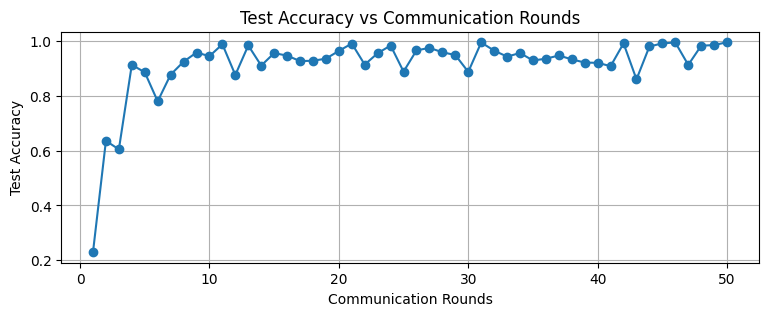

In [ ]:
def plot_accuracy_vs_rounds():
    if test_accuracies:
        plt.figure(figsize=(9,3))
        plt.plot(range(1, len(test_accuracies) + 1), test_accuracies, marker='o', linestyle='-')
        plt.title('Test Accuracy vs Communication Rounds')
        plt.xlabel('Communication Rounds')
        plt.ylabel('Test Accuracy')
        plt.grid(True)
        plt.savefig('accuracy_vs_rounds.png')
        plt.show()
    else:
        print("No accuracy data collected to plot.")

plot_accuracy_vs_rounds()